# Load The Data

In [1]:
import sys
import pymongo
import pandas as pd
from bson import ObjectId
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import re
from datetime import datetime
import matplotlib.pyplot as plt
import string
from datetime import datetime

In [2]:
# MongoDB connection setup
client = pymongo.MongoClient('mongodb://localhost:27017/')
db = client['Annapolis_New']
collection = db['PD_New']

# Retrieve all documents from MongoDB
documents = list(collection.find())

# Create a DataFrame
df = pd.DataFrame(documents)

# Rename columns for clarity
df = df.rename(columns={'_id': 'document_id', 'message': 'content', 'scraping_link': 'source_url'})

df['document_id'] = df['document_id'].astype(str)
df = df.reset_index(drop=True)

In [3]:
df.columns

Index(['document_id', 'title', 'date_sent', 'link', 'content'], dtype='object')

In [4]:
def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%m/%d/%y').date()
    except ValueError:
        try:
            return datetime.strptime(date_str, '%m/%d/%Y').date()
        except ValueError:
            # Handle three-digit year case
            parts = date_str.split('/')
            if len(parts) == 3 and len(parts[2]) == 3:
                corrected_date_str = f"{parts[0]}/{parts[1]}/2{parts[2]}"
                try:
                    return datetime.strptime(corrected_date_str, '%m/%d/%Y').date()
                except ValueError:
                    pass
    return None


In [5]:
# Define regular expression patterns with improved robustness
dash_pattern = r'[-–—]'

# Named groups for clarity
incident_pattern = rf'(?P<incident_id>\d{{12}})\s*{dash_pattern}\s*(?P<incident_text>.*?)(?=\d{{12}}\s*{dash_pattern}|Hiring Entry Level|Annapolis Police Department Daily Report|$)'
hiring_pattern = r'(Hiring Entry Level.*?)(?=Submitting Anonymous Tips|Programs Offered by the Community Services Unit|$)'
tips_pattern = r'(Submitting Anonymous Tips.*?)(?=Programs Offered by the Community Services Unit|$)'
programs_pattern = r'(Programs Offered by the Community Services Unit.*?)(?=Contact Us|$)'
contact_pattern = r'(Contact Us.*?)(?=Share on Facebook|Copyright|$)'

# Compile regex patterns with case-insensitive and dotall flags
compiled_incident = re.compile(incident_pattern, re.DOTALL | re.IGNORECASE)
compiled_hiring = re.compile(hiring_pattern, re.DOTALL | re.IGNORECASE)
compiled_tips = re.compile(tips_pattern, re.DOTALL | re.IGNORECASE)
compiled_programs = re.compile(programs_pattern, re.DOTALL | re.IGNORECASE)
compiled_contact = re.compile(contact_pattern, re.DOTALL | re.IGNORECASE)


# F1 Data

In [6]:
def create_f1_data(df):
    f1_test_records = []
    
    for _, row in df.iterrows():
        document_id = row['document_id']
        content = row['content'].lower()
        link = row['link']
        
        # Extract report date
        report_date_match = re.search(
            r'(?:daily report\s*[-–—]?\s*|^)(\d{1,2}/\d{1,2}/\d{2,4})',
            content,
            re.IGNORECASE
        )
        report_date = parse_date(report_date_match.group(1)) if report_date_match else None
        
        # Extract incidents
        for match in compiled_incident.finditer(content):
            incident_id = match.group('incident_id')
            incident_text = match.group('incident_text').strip()
            
            # Extract incident date
            incident_date_match = re.search(r'\d{1,2}/\d{1,2}/\d{2,4}', incident_text)
            incident_date = parse_date(incident_date_match.group()) if incident_date_match else None
            
            f1_test_records.append({
                'document_id': document_id,
                'incident_id': incident_id,
                'incident_date': incident_date,
                'report_date': report_date,
                'section': 'incident',
                'text': incident_text,
                'link': link
            })
        
        # Extract hiring section
        hiring_match = compiled_hiring.search(content)
        if hiring_match:
            hiring_text = hiring_match.group(1).strip()
            f1_test_records.append({
                'document_id': document_id,
                'incident_id': None,
                'incident_date': None,
                'report_date': report_date,
                'section': 'hiring',
                'text': hiring_text,
                'link': link
            })
        
        # Extract tips section
        tips_match = compiled_tips.search(content)
        if tips_match:
            tips_text = tips_match.group(1).strip()
            f1_test_records.append({
                'document_id': document_id,
                'incident_id': None,
                'incident_date': None,
                'report_date': report_date,
                'section': 'tips',
                'text': tips_text,
                'link': link
            })
        
        # Extract programs section
        programs_match = compiled_programs.search(content)
        if programs_match:
            programs_text = programs_match.group(1).strip()
            f1_test_records.append({
                'document_id': document_id,
                'incident_id': None,
                'incident_date': None,
                'report_date': report_date,
                'section': 'programs',
                'text': programs_text,
                'link': link
            })
        
        # Extract contact section
        contact_match = compiled_contact.search(content)
        if contact_match:
            contact_text = contact_match.group(1).strip()
            f1_test_records.append({
                'document_id': document_id,
                'incident_id': None,
                'incident_date': None,
                'report_date': report_date,
                'section': 'contact',
                'text': contact_text,
                'link': link
            })
    
    # Create the DataFrame
    f1_data_test_full = pd.DataFrame(f1_test_records)
    
    # Reorder columns
    f1_data_test_full = f1_data_test_full[['document_id', 'incident_id', 'incident_date', 'report_date', 'section', 'text', 'link']]
    
    # Ensure proper data types
    f1_data_test_full['incident_id'] = f1_data_test_full['incident_id'].astype(str).replace('nan', None)
    
    return f1_data_test_full

f1_data = create_f1_data(df)
print("f1_data Sample:")
f1_data.head()

f1_data Sample:


document_id   incident_id incident_date report_date   section  \
0  6755cb5d93a273b79e58426d  202400025855    2024-12-05  2024-12-06  incident   
1  6755cb5d93a273b79e58426d          None          None  2024-12-06    hiring   
2  6755cb5d93a273b79e58426d          None          None  2024-12-06      tips   
3  6755cb5d93a273b79e58426d          None          None  2024-12-06  programs   
4  6755cb5d93a273b79e58426d          None          None  2024-12-06   contact   

                                                text  \
0  domestic assault - 105 francis noel way 12/5/2...   
1  hiring entry level & lateral police officersdo...   
2  submitting anonymous tips to metro crime stopp...   
3  programs offered by the community services uni...   
4  contact us at police@annapolis.gov. victims' a...   

                                                link  
0  https://www.annapolis.gov/CivicSend/ViewMessag...  
1  https://www.annapolis.gov/CivicSend/ViewMessag...  
2  https://www.annapolis.gov/CivicSend/ViewMessag...  
3  https://www.annapolis.gov/CivicSend/ViewMessag...  
4  https://www.annapolis.gov/CivicSend/ViewMessag...

In [7]:
df.shape

(2131, 5)

In [8]:
df.to_csv(r'C:\Users\bengb\OneDrive\Documents\AnnapolisPD\Text_Analytics_Final_Project\data\F0_Annapolis_PD.csv', index = False)

Extracts sections, 
preprocesses text (stopwords, digits, punctuation), 
parses dates, 
organizes structured data into a deduplicated DataFrame called f1_data.

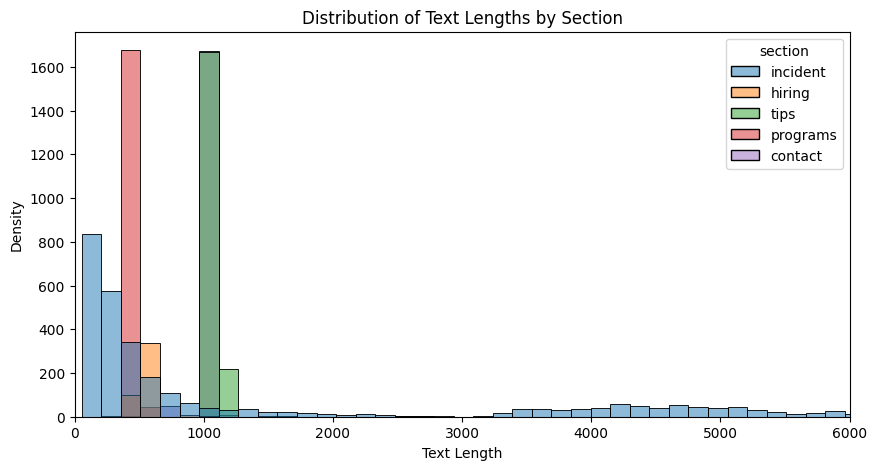

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(data=f1_data, x=f1_data['text'].str.len(), hue='section', palette='tab10', bins=80)
plt.title('Distribution of Text Lengths by Section')
plt.xlabel('Text Length')
plt.ylabel('Density')
plt.xlim(0, 6000)
plt.grid(False)
plt.show()

In [10]:
f1_data.to_csv(r'C:\Users\bengb\OneDrive\Documents\AnnapolisPD\Text_Analytics_Final_Project\data\f1_data.csv', index = False)

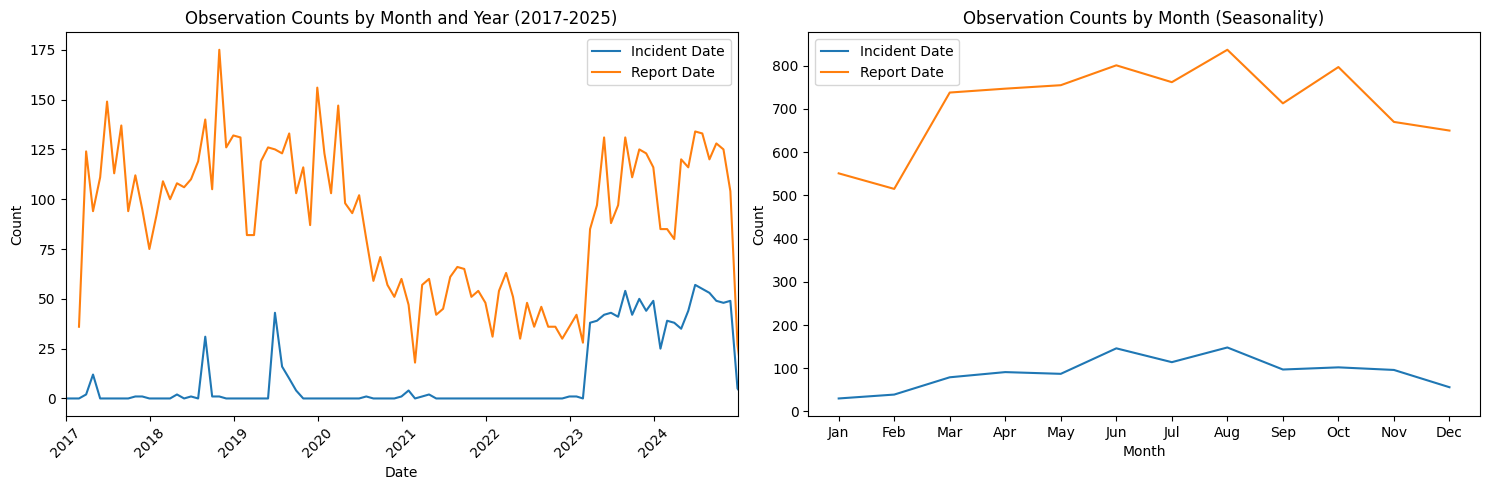

In [11]:
f1_data['incident_date'] = pd.to_datetime(f1_data['incident_date'], errors='coerce')
f1_data['report_date'] = pd.to_datetime(f1_data['report_date'], errors='coerce')

# Filter dates to be between 2017 and 2025
start_date = '2017-01-01'
end_date = '2024-12-31'
filtered_data = f1_data[
    ((f1_data['incident_date'] >= start_date) & (f1_data['incident_date'] <= end_date)) |
    ((f1_data['report_date'] >= start_date) & (f1_data['report_date'] <= end_date))
]

# Grouping filtered data by month and year
incident_monthly = filtered_data.groupby(pd.Grouper(key='incident_date', freq='M')).size()
report_monthly = filtered_data.groupby(pd.Grouper(key='report_date', freq='M')).size()

# Grouping by months (across all years for seasonality)
f1_data['incident_month'] = f1_data['incident_date'].dt.month
f1_data['report_month'] = f1_data['report_date'].dt.month

incident_seasonal = f1_data.groupby('incident_month').size()
report_seasonal = f1_data.groupby('report_month').size()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(incident_monthly.index, incident_monthly.values, label='Incident Date')
axes[0].plot(report_monthly.index, report_monthly.values, label='Report Date')
axes[0].set_title('Observation Counts by Month and Year (2017-2025)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(False)
axes[0].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

axes[1].plot(incident_seasonal.index, incident_seasonal.values, label='Incident Date')
axes[1].plot(report_seasonal.index, report_seasonal.values, label='Report Date')
axes[1].set_title('Observation Counts by Month (Seasonality)')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count')
axes[1].set_xticks(ticks=range(1, 13))
axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1].legend()
axes[1].grid(False)
plt.tight_layout()
plt.show()

# Create F2 Format

In [12]:
# Create LIBRARY table
library_df = f1_data[['document_id', 'incident_id', 'incident_date', 'report_date', 'link']].copy()
library_df['doc_length'] = f1_data['text'].str.len()  # Add document length
library_df['word_count'] = f1_data['text'].str.split().str.len()  # Add word count
library_df.head(1)

document_id   incident_id incident_date report_date  \
0  6755cb5d93a273b79e58426d  202400025855    2024-12-05  2024-12-06   

                                                link  doc_length  word_count  
0  https://www.annapolis.gov/CivicSend/ViewMessag...         348          58

In [13]:
# Add metadata fields that might help with analysis
library_df['year'] = library_df['report_date'].dt.year
library_df['month'] = library_df['report_date'].dt.month
library_df['day_of_week'] = library_df['report_date'].dt.day_name()

# Add a field for time delta between incident and report
library_df['report_delay'] = (library_df['report_date'] - library_df['incident_date']).dt.days
library_df.head(1)

document_id   incident_id incident_date report_date  \
0  6755cb5d93a273b79e58426d  202400025855    2024-12-05  2024-12-06   

                                                link  doc_length  word_count  \
0  https://www.annapolis.gov/CivicSend/ViewMessag...         348          58   

     year  month day_of_week  report_delay  
0  2024.0   12.0      Friday           1.0

In [14]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

def create_basic_token_table(f1_data):
    """
    Creates the basic F2 token table structure capturing the fundamental elements:
    - Which tokens appear in which documents
    - Where they appear (position and sentence)
    - Maintains links to source documents and incidents
    """
    token_records = []
    for _, row in f1_data.iterrows():
        sentences = sent_tokenize(row['text'])
        for sent_idx, sentence in enumerate(sentences):
            tokens = word_tokenize(sentence)
            for pos_idx, token in enumerate(tokens):
                token_records.append({
                    'doc_id': row['document_id'],
                    'incident_id': row['incident_id'],
                    'token_id': f"{row['document_id']}_{sent_idx}_{pos_idx}",
                    'token': token.lower(),
                    'position': pos_idx,
                    'sentence_id': sent_idx
                })
    return pd.DataFrame(token_records)

# Create our basic F2 token table
token_df = create_basic_token_table(f1_data)
token_df.head(1)

doc_id   incident_id                      token_id  \
0  6755cb5d93a273b79e58426d  202400025855  6755cb5d93a273b79e58426d_0_0   

      token  position  sentence_id  
0  domestic         0            0

In [15]:
def create_vocab_table(token_df):
    # Get unique terms and their frequencies
    vocab_df = token_df.groupby('token').agg({
        'doc_id': 'nunique',  # Number of documents containing term
        'token_id': 'count'   # Total frequency
    }).reset_index()
    
    vocab_df.columns = ['term', 'doc_frequency', 'total_frequency']
    vocab_df['term_id'] = range(len(vocab_df))  # Add term_id
    return vocab_df

vocab_df = create_vocab_table(token_df)
vocab_df.head(1)

term  doc_frequency  total_frequency  term_id
0    !            148              375        0

In [16]:
def clean_tokens_for_analysis(token_df, vocab_df):
    """
    Cleans and filters tokens while maintaining the relationship between token_df and vocab_df.
    
    This function processes both tables together because:
    1. When we remove tokens from token_df, we need to update vocab_df accordingly
    2. Term frequencies and document frequencies in vocab_df need to be recalculated
    3. The relationship between tokens and their vocabulary entries must stay intact
    
    Parameters:
        token_df: DataFrame containing individual token occurrences
        vocab_df: DataFrame containing vocabulary statistics
        
    Returns:
        tuple: (cleaned_token_df, cleaned_vocab_df)
    """
    # Create copies to avoid modifying the originals
    cleaned_token_df = token_df.copy()
    
    # Define domain-specific stopwords
    domain_stopwords = {
        # Location-specific terms
        'annapolis', 'maryland', 'md', 
        # Department-specific terms
        'police', 'officer', 'officers', 'dept', 'department',
    }
    
    # Combine with standard English stopwords
    from nltk.corpus import stopwords
    all_stopwords = set(stopwords.words('english')).union(domain_stopwords)
    
    def clean_token(token):
        """
        Cleans an individual token according to our rules.
        Returns None for tokens that should be removed.
        """
        # Convert to lowercase
        token = str(token).lower()
        
        # Remove all punctuation from anywhere in the token
        import string
        token = ''.join(char for char in token if char not in string.punctuation)
        
        # After punctuation removal, check if anything remains
        if not token:
            return None
            
        # Remove numbers and timestamps
        if token.isdigit():
            return None
            
        # Remove very short tokens
        if len(token) < 3:
            return None
            
        # Remove stopwords
        if token in all_stopwords:
            return None
        
        return token
    
    # Apply cleaning to tokens
    cleaned_token_df['clean_token'] = cleaned_token_df['token'].apply(clean_token)
    
    # Remove rows where cleaning resulted in None
    cleaned_token_df = cleaned_token_df.dropna(subset=['clean_token'])
    
    # Replace original token with cleaned version
    cleaned_token_df['token'] = cleaned_token_df['clean_token']
    cleaned_token_df = cleaned_token_df.drop('clean_token', axis=1)
    
    # Now rebuild vocab_df based on the cleaned tokens
    # First, get document frequencies
    doc_freq = cleaned_token_df.groupby('token')['doc_id'].nunique().reset_index()
    doc_freq.columns = ['term', 'doc_frequency']
    
    # Then, get total frequencies
    total_freq = cleaned_token_df['token'].value_counts().reset_index()
    total_freq.columns = ['term', 'total_frequency']
    
    # Combine frequencies into new vocab DataFrame
    cleaned_vocab_df = pd.merge(doc_freq, total_freq, on='term')
    
    # Add term_id to match original vocab_df structure
    cleaned_vocab_df['term_id'] = range(len(cleaned_vocab_df))
    
    # Ensure cleaned_vocab_df has the same columns as the original
    for col in vocab_df.columns:
        if col not in cleaned_vocab_df.columns and col not in ['term', 'doc_frequency', 'total_frequency', 'term_id']:
            cleaned_vocab_df[col] = None
            
    return cleaned_token_df, cleaned_vocab_df

# Apply the cleaning to both tables
print("Starting token and vocabulary cleaning...")
token_df_clean, vocab_df_clean = clean_tokens_for_analysis(token_df, vocab_df)

# Show cleaning statistics
print("\nCleaning statistics:")
print(f"Original token count: {len(token_df)}")
print(f"Cleaned token count: {len(token_df_clean)}")
print(f"Original vocabulary size: {len(vocab_df)}")
print(f"Cleaned vocabulary size: {len(vocab_df_clean)}")

# Show the impact of cleaning
print("\nMost frequent tokens before cleaning:")
print(token_df['token'].value_counts().head(10))
print("\nMost frequent tokens after cleaning:")
print(token_df_clean['token'].value_counts().head(10))

print("\nVocabulary sample before cleaning:")
print(vocab_df.head())
print("\nVocabulary sample after cleaning:")
print(vocab_df_clean.head())

Starting token and vocabulary cleaning...

Cleaning statistics:
Original token count: 1645203
Cleaned token count: 760979
Original vocabulary size: 12677
Cleaned vocabulary size: 10269

Most frequent tokens before cleaning:
token
.       76440
,       54818
the     52381
to      40601
a       37391
:       28056
or      26866
your    26052
you     25204
for     24368
Name: count, dtype: int64

Most frequent tokens after cleaning:
token
crime           19112
information     17200
contact         17069
tip             15635
stoppers        13710
metro           11122
app              9942
vehicle          9840
annapolisgov     9814
tips             9725
Name: count, dtype: int64

Vocabulary sample before cleaning:
  term  doc_frequency  total_frequency  term_id
0    !            148              375        0
1    #             90              164        1
2    $           1901             4330        2
3    %             25               26        3
4    &           1723             3035

In [17]:
token_df, vocab_df = clean_tokens_for_analysis(token_df, vocab_df)

In [18]:
vocab_df.head()

term  doc_frequency  total_frequency  term_id
0      008y36              1                1        0
1    0107food              1                1        1
2  01082024on              1                1        2
3  01102024on              1                1        3
4    011224on              1                1        4

# F3 Claude

In [19]:
import spacy
nlp = spacy.load('en_core_web_sm')

def enhance_token_table_f3(token_df):
    """
    Enhances our F2 token table with NLP annotations. We process the text document by document
    to maintain the proper context for linguistic analysis, then merge these features back
    with our original token structure.
    """
    doc_texts = token_df.groupby('doc_id')['token'].apply(' '.join)
    
    nlp_features = []
    for doc_id, text in doc_texts.items():
        doc = nlp(text)
        for token in doc:
            nlp_features.append({
                'doc_id': doc_id,
                'token': token.text.lower(),
                'pos': token.pos_,        # Part of speech like NOUN, VERB
                'tag': token.tag_,        # Detailed tag like singular noun, past tense verb
                'dep': token.dep_,        # Syntactic dependency relationship
                'is_stop': token.is_stop, # Whether it's a common stop word
                'lemma': token.lemma_,    # Base form of the word
                'ent_type': token.ent_type_ if token.ent_type_ else 'O'  # Named entity type
            })
    
    enhanced_features = pd.DataFrame(nlp_features)
    
    # Merge while preserving our original F2 structure
    token_df_f3 = token_df.merge(
        enhanced_features[['doc_id', 'token', 'pos', 'tag', 'dep', 'is_stop', 'lemma', 'ent_type']], 
        on=['doc_id', 'token'],
        how='left'
    )
    return token_df_f3

token_df_f3 = enhance_token_table_f3(token_df)
token_df_f3.head(1)

doc_id   incident_id                      token_id  \
0  6755cb5d93a273b79e58426d  202400025855  6755cb5d93a273b79e58426d_0_0   

      token  position  sentence_id  pos tag   dep is_stop     lemma ent_type  
0  domestic         0            0  ADJ  JJ  amod   False  domestic        O

In [20]:
def enhance_vocab_table_f3(vocab_df, token_df_f3):
    """
    Enhances our F2 vocabulary table with aggregated NLP information.
    Uses a more robust approach to handle aggregations.
    """
    def safe_mode(x):
        # Safe way to get most common value, returns None if series is empty
        if len(x) == 0:
            return None
        counts = x.value_counts()
        return counts.iloc[0] if not counts.empty else None

    # Get most common part of speech for each token
    pos_counts = token_df_f3.groupby('token').agg({
        'pos': safe_mode
    }).reset_index()
    pos_counts.columns = ['term', 'common_pos']
    
    # Get most common entity type for each token
    ent_counts = token_df_f3.groupby('token').agg({
        'ent_type': safe_mode
    }).reset_index()
    ent_counts.columns = ['term', 'common_ent_type']
    
    # Get canonical form (lemma) for each token
    lemma_counts = token_df_f3.groupby('token').agg({
        'lemma': safe_mode
    }).reset_index()
    lemma_counts.columns = ['term', 'canonical_form']
    
    # Combine all features - using left joins to preserve all vocab terms
    vocab_df_f3 = vocab_df.copy()
    vocab_df_f3 = vocab_df_f3.merge(pos_counts, on='term', how='left')
    vocab_df_f3 = vocab_df_f3.merge(ent_counts, on='term', how='left')
    vocab_df_f3 = vocab_df_f3.merge(lemma_counts, on='term', how='left')
    
    return vocab_df_f3

vocab_df_f3 = enhance_vocab_table_f3(vocab_df, token_df_f3)
vocab_df_f3.head(10)

term  doc_frequency  total_frequency  term_id  common_pos  \
0      008y36              1                1        0         1.0   
1    0107food              1                1        1         1.0   
2  01082024on              1                1        2         1.0   
3  01102024on              1                1        3         1.0   
4    011224on              1                1        4         1.0   
5    011324on              1                1        5         1.0   
6     01138ch              1                1        6         1.0   
7  01142024on              1                1        7         1.0   
8  01152024on              1                2        8         4.0   
9  01172024on              1                1        9         1.0   

   common_ent_type  canonical_form  
0              1.0             1.0  
1              1.0             1.0  
2              1.0             1.0  
3              1.0             1.0  
4              1.0             1.0  
5              1.0             1.0  
6              1.0             1.0  
7              1.0             1.0  
8              4.0             4.0  
9              1.0             1.0

In [21]:
def enhance_library_table_f3(library_df, token_df_f3):
    """
    Enhances our F2 library table with document-level linguistic summaries.
    Handles the column name difference by first aligning the naming convention.
    """
    # Create a working copy of token_df_f3 with renamed column
    working_tokens = token_df_f3.copy()
    working_tokens = working_tokens.rename(columns={'doc_id': 'document_id'})
    
    # Calculate document-level summaries using the renamed column
    doc_summaries = working_tokens.groupby('document_id').agg({
        'pos': lambda x: x.value_counts().to_dict(),  # Distribution of parts of speech
        'ent_type': lambda x: x.value_counts().to_dict(),  # Distribution of entity types
        'is_stop': 'mean'  # Proportion of stop words
    }).reset_index()
    
    # Merge with original library table
    library_df_f3 = library_df.merge(doc_summaries, on='document_id', how='left')
    
    return library_df_f3

library_df_f3 = enhance_library_table_f3(library_df, token_df_f3)
library_df_f3.head(1)

document_id   incident_id incident_date report_date  \
0  6755cb5d93a273b79e58426d  202400025855    2024-12-05  2024-12-06   

                                                link  doc_length  word_count  \
0  https://www.annapolis.gov/CivicSend/ViewMessag...         348          58   

     year  month day_of_week  report_delay  \
0  2024.0   12.0      Friday           1.0   

                                                 pos  \
0  {'NOUN': 376, 'VERB': 69, 'ADJ': 55, 'PROPN': ...   

                                            ent_type   is_stop  
0  {'O': 518, 'PERSON': 13, 'FAC': 8, 'ORG': 7, '...  0.041219

# Claude F4

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

def calculate_incident_tfidf(token_df):
    """
    Calculates TF-IDF scores treating each incident as a document.
    
    first:
    1. Group all tokens by incident_id to create our documents
    2. Calculate TF-IDF across these incident-level documents
    3. Map the scores back to individual tokens
    """
    # Group tokens by incident to create our documents
    incident_texts = token_df.groupby('incident_id')['token'].apply(
        lambda x: ' '.join(x.str.lower())
    )
    
    # Create and configure our TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        stop_words='english',
        max_df=0.95,    # Ignore terms appearing in >95% of incidents
        min_df=2        # Ignore terms appearing in just one incident
    )
    
    # Calculate TF-IDF at the incident level
    tfidf_matrix = vectorizer.fit_transform(incident_texts)
    
    # Get our terms and their IDF scores
    terms = vectorizer.get_feature_names_out()
    idfs = vectorizer.idf_
    
    # Create a dictionary of scores for each term in each incident
    incident_term_scores = {}
    for incident_idx, incident_id in enumerate(incident_texts.index):
        doc_vector = tfidf_matrix[incident_idx].toarray()[0]
        for term_idx, score in enumerate(doc_vector):
            if score > 0:  # Only store non-zero scores
                term = terms[term_idx]
                incident_term_scores[(incident_id, term)] = score
    
    # Add scores back to our token dataframe
    token_df_f4 = token_df.copy()
    token_df_f4['tfidf'] = token_df_f4.apply(
        lambda row: incident_term_scores.get(
            (row['incident_id'], row['token'].lower()),
            0
        ),
        axis=1
    )
    
    # Let's add some useful statistics about each token's importance
    token_stats = pd.DataFrame([
        {
            'term': term,
            'idf': idf,
            'num_incidents': (tfidf_matrix.T[idx] != 0).sum(),
            'avg_tfidf': tfidf_matrix.T[idx].mean()
        }
        for idx, (term, idf) in enumerate(zip(terms, idfs))
    ])
    
    return token_df_f4, token_stats

token_df_f4, token_stats = calculate_incident_tfidf(token_df_f3)

In [23]:
print("\nMost significant terms across all incidents:")
print(token_stats.nlargest(20, 'avg_tfidf')[['term', 'num_incidents', 'avg_tfidf']])

print("\nSample of TF-IDF scores within a single incident:")
sample_incident = token_df_f4['incident_id'].iloc[0]
print(token_df_f4[token_df_f4['incident_id'] == sample_incident]
      [['token', 'tfidf']]
      .sort_values('tfidf', ascending=False)
      .drop_duplicates('token')
      .head(20))


Most significant terms across all incidents:
              term  num_incidents  avg_tfidf
5228       vehicle           1762   0.202720
2810   information            821   0.113326
1696         crime            735   0.110886
1588       contact            761   0.099849
4758        stolen           1638   0.083190
1055         block           1521   0.075034
4996           tip            680   0.070795
4951         theft           1639   0.063098
2684          home           1053   0.056867
4766      stoppers            682   0.055707
5250        victim            795   0.051799
4864       suspect            653   0.039470
3322         metro            682   0.037331
749   annapolisgov            701   0.033852
3964       program            667   0.030973
776            app            646   0.029951
4997          tips            670   0.027996
1515     community            800   0.026753
1032       bicycle            275   0.026357
2717         hours            777   0.024028

Sample o

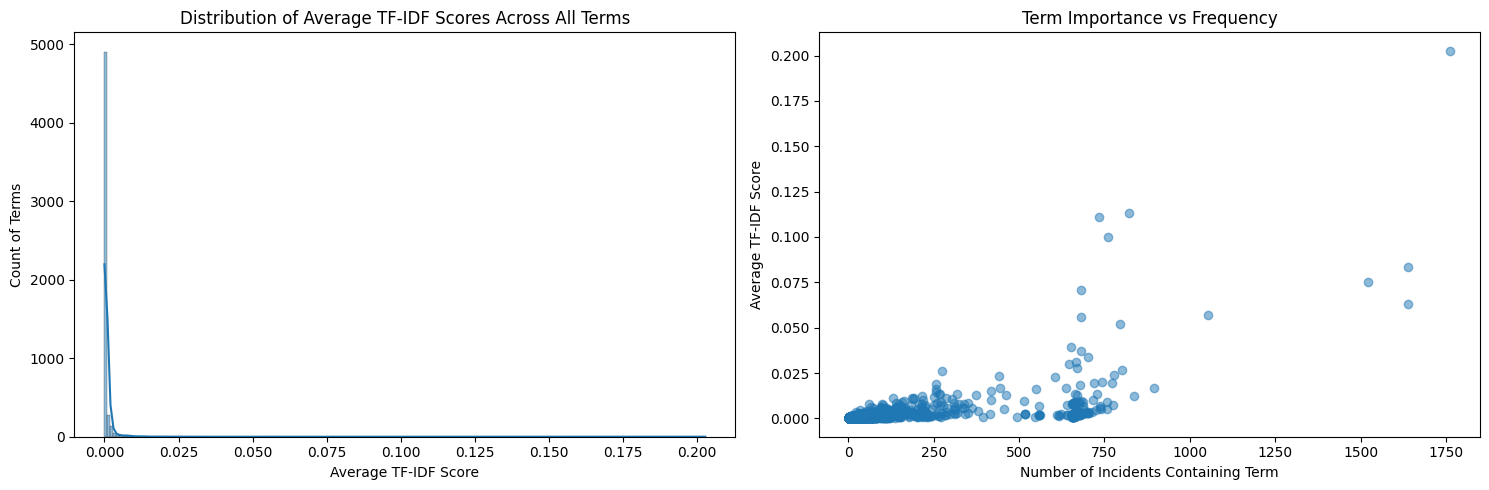


Terms grouped by importance and frequency:

Very Important, Moderately Common Terms (potential incident type indicators):
               term  num_incidents  avg_tfidf
1032        bicycle            275   0.026357
1169       burglary            441   0.023211
643         advised            256   0.018766
5162        unknown            444   0.016460
2031       eastport            255   0.016207
5155           unit            418   0.015233
4808        subject            256   0.014302
808   approximately            268   0.013641
4866       suspects            266   0.013444
1049          black            318   0.013377
2100        entered            462   0.012983
1953           door            375   0.012784
5231       vehicles            215   0.012079
4284        robbery            251   0.012000
4529          shots            187   0.011466

Incidents with unusually high average TF-IDF scores (might be unique cases):
incident_id
201900005251    0.762728
201900002231    0.727656
2

In [43]:
def analyze_tfidf_patterns(token_df_f4, token_stats):
    """
    Analyzes patterns in TF-IDF scores to understand our incident corpus.
    We'll look at both corpus-wide patterns and incident-specific patterns.
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Distribution of Average TF-IDF Scores Across All Terms
    sns.histplot(data=token_stats, x='avg_tfidf', bins=25, kde=True, ax=axes[0],binwidth=0.001,binrange=(0,0.01), )
    axes[0].set_title('Distribution of Average TF-IDF Scores Across All Terms')
    axes[0].set_xlabel('Average TF-IDF Score')
    axes[0].set_ylabel('Count of Terms')
    
    # Plot 2: Term Importance vs Frequency
    axes[1].scatter(token_stats['num_incidents'], token_stats['avg_tfidf'], alpha=0.5)
    axes[1].set_xlabel('Number of Incidents Containing Term')
    axes[1].set_ylabel('Average TF-IDF Score')
    axes[1].set_title('Term Importance vs Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Let's identify clusters of similar terms based on their TF-IDF patterns
    high_value_terms = token_stats[token_stats['avg_tfidf'] > token_stats['avg_tfidf'].mean()]
    print("\nTerms grouped by importance and frequency:")
    print("\nVery Important, Moderately Common Terms (potential incident type indicators):")
    print(high_value_terms[
        (high_value_terms['num_incidents'] > 100) & 
        (high_value_terms['num_incidents'] < 500)
    ][['term', 'num_incidents', 'avg_tfidf']].sort_values('avg_tfidf', ascending=False).head(15))

    # Calculate average TF-IDF scores per incident to identify 'unusual' incidents
    incident_avg_tfidf = token_df_f4.groupby('incident_id')['tfidf'].mean()
    
    print("\nIncidents with unusually high average TF-IDF scores (might be unique cases):")
    print(incident_avg_tfidf.nlargest(5))

analyze_tfidf_patterns(token_df_f4, token_stats)

document sparse matrix

In [25]:
from scipy.sparse import csr_matrix

def create_document_term_matrix(token_df_f4):
    """
    Creates a document-term matrix using our TF-IDF scores.
    This will be useful for F5 analyses (PCA, LDA, etc.).
    """
    # Create a pivot table of our TF-IDF values
    doc_term_matrix = pd.pivot_table(
        token_df_f4,
        values='tfidf',
        index='incident_id',
        columns='token',
        fill_value=0
    )
    
    # Convert to sparse matrix for efficiency
    sparse_matrix = csr_matrix(doc_term_matrix.values)
    
    return doc_term_matrix, sparse_matrix

# Create and save our document-term matrix for F5
doc_term_matrix, sparse_matrix = create_document_term_matrix(token_df_f4)

print("\nDocument-term matrix shape:", doc_term_matrix.shape)
print("Number of non-zero entries:", sparse_matrix.getnnz())


Document-term matrix shape: (2885, 10269)
Number of non-zero entries: 231029


In [26]:
def analyze_incident_language_patterns(token_df_f4, doc_term_matrix):
    """
    Analyzes patterns in how language is used across different police incidents.
    This helps us understand both common and distinctive features of incident reports.
    """
    # First, let's look at vocabulary usage per incident
    terms_per_incident = (doc_term_matrix > 0).sum(axis=1)
    
    # Find incidents with unusually rich vocabulary
    rich_vocabulary = terms_per_incident.nlargest(5)
    print("\nIncidents with largest vocabulary:")
    print(rich_vocabulary)
    
    # Look at term co-occurrences in incidents
    # This can reveal common patterns in incident descriptions
    high_value_terms = token_df_f4[token_df_f4['tfidf'] > token_df_f4['tfidf'].mean()]
    term_pairs = pd.DataFrame(columns=['term1', 'term2', 'co_occurrences'])
    
    # Get the most common pairs of important terms
    term_groups = high_value_terms.groupby('incident_id')['token'].unique()
    pair_counts = {}
    
    for terms in term_groups:
        for i, term1 in enumerate(terms):
            for term2 in terms[i+1:]:
                if term1 < term2:  # Avoid counting pairs twice
                    pair = (term1, term2)
                else:
                    pair = (term2, term1)
                pair_counts[pair] = pair_counts.get(pair, 0) + 1
    
    # Convert to DataFrame and show top pairs
    term_pairs = pd.DataFrame([
        {'term1': t1, 'term2': t2, 'co_occurrences': count}
        for (t1, t2), count in pair_counts.items()
    ]).sort_values('co_occurrences', ascending=False)
    
    print("\nMost common important term pairs (might indicate incident patterns):")
    print(term_pairs.head(15))
    
    # Look at average TF-IDF scores by position in report
    # This can show how information is typically structured
    token_df_f4['normalized_position'] = token_df_f4.groupby('incident_id')['token_id'].transform(
        lambda x: (x.rank() / len(x))
    )
    
    position_importance = token_df_f4.groupby(
        pd.cut(token_df_f4['normalized_position'], bins=10)
    )['tfidf'].mean()
    
    print("\nTF-IDF importance by position in report:")
    print(position_importance)

    return terms_per_incident, term_pairs, position_importance

# Run our analysis
vocab_stats, term_pairs, position_stats = analyze_incident_language_patterns(
    token_df_f4, 
    doc_term_matrix
)


Incidents with largest vocabulary:
incident_id
None            585
201900005282    373
201900006006    371
201800005296    369
202000001422    363
dtype: int64

Most common important term pairs (might indicate incident patterns):
            term1        term2  co_occurrences
5         contact  information             691
3           crime  information             675
14        contact        crime             674
13          crime          tip             646
4     information          tip             644
15        contact          tip             644
88          crime     stoppers             563
86    information     stoppers             561
87        contact     stoppers             561
89       stoppers          tip             538
22         stolen      vehicle             265
53          theft      vehicle             190
223         block      vehicle             170
1266        block        theft             112
184         block       stolen             104

TF-IDF importanc

C:\Users\bengb\AppData\Local\Temp\ipykernel_87364\2743880458.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  position_importance = token_df_f4.groupby(


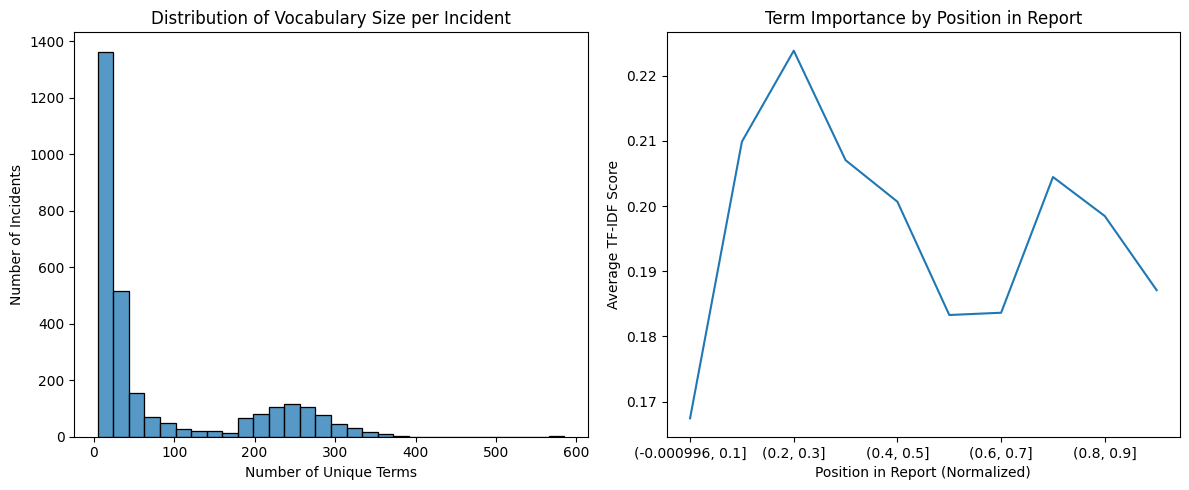

In [44]:
def visualize_incident_patterns(vocab_stats, term_pairs, position_stats):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot vocabulary distribution
    sns.histplot(vocab_stats, bins=30, ax=ax1)
    ax1.set_title('Distribution of Vocabulary Size per Incident')
    ax1.set_xlabel('Number of Unique Terms')
    ax1.set_ylabel('Number of Incidents')
    
    # Plot term importance by position
    position_stats.plot(kind='line', ax=ax2)
    ax2.set_title('Term Importance by Position in Report')
    ax2.set_xlabel('Position in Report (Normalized)')
    ax2.set_ylabel('Average TF-IDF Score')
    
    plt.tight_layout()
    plt.show()

# Create visualizations
visualize_incident_patterns(vocab_stats, term_pairs, position_stats)

These analyses and visualizations help us understand:

How police officers write their reports
What patterns exist in different types of incidents
How information is typically structured in reports
Which incidents might be unusual or particularly complex

Would you like to explore any particular aspect of these patterns in more detail? For example, we could:

Deep dive into specific types of incidents
Look more closely at report structure
Analyze seasonal or temporal patterns
Examine relationships between report length and incident complexity

Variance explained by each component:
   Component  Explained_Variance  Cumulative_Variance
0          1            2.205297             2.205297
1          2            0.906588             3.111885
2          3            0.826759             3.938644
3          4            0.739323             4.677967
4          5            0.663934             5.341901
5          6            0.657202             5.999103
6          7            0.649832             6.648935
7          8            0.620757             7.269692
8          9            0.601244             7.870936
9         10            0.595460             8.466395

Most influential terms for each component:
                   Component_1                                  Component_2  \
0             herefree (0.089)                            unordered (0.141)   
1        unitannapolis (0.089)                      formattingspell (0.141)   
2          appointment (0.089)                              checker (0.141)   
3       

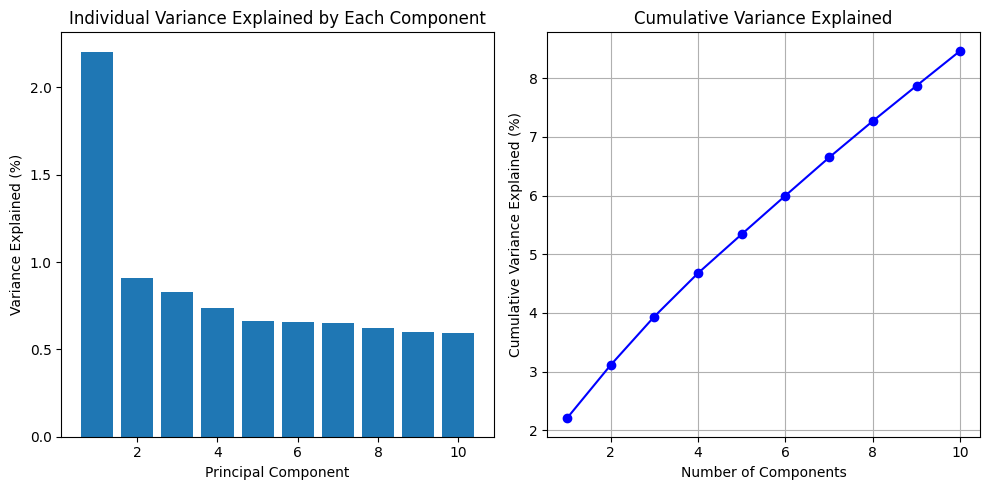

In [45]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def apply_pca_analysis(doc_term_matrix, n_components=10):
    """
    Applies PCA to our document-term matrix to find the main themes in our incidents.
    
    This function helps us understand the underlying patterns in incident reports by:
    1. Normalizing our term frequencies so all terms are on the same scale
    2. Finding the principal components that explain the most variance
    3. Identifying which terms contribute most to each component
    """
    # Convert DataFrame to numpy array for processing
    data_array = doc_term_matrix.values
    
    # Normalize our data - this is important because different terms occur at different frequencies
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_array)
    
    # Apply PCA to find the main components
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(scaled_data)
    
    # Create DataFrame showing how each document relates to the components
    component_df = pd.DataFrame(
        components,
        index=doc_term_matrix.index,
        columns=[f'Component_{i+1}' for i in range(n_components)]
    )
    
    # Analyze which terms are most important for each component
    feature_names = doc_term_matrix.columns
    component_terms = pd.DataFrame()
    
    for idx, component in enumerate(pca.components_):
        # Find the terms with the highest absolute weights in this component
        top_term_indices = np.abs(component).argsort()[-10:][::-1]
        
        # Store the terms and their weights
        component_terms[f'Component_{idx+1}'] = [
            f"{feature_names[i]} ({component[i]:.3f})"
            for i in top_term_indices
        ]
    
    # Calculate how much variance each component explains
    explained_variance = pd.DataFrame({
        'Component': range(1, n_components + 1),
        'Explained_Variance': pca.explained_variance_ratio_ * 100,
        'Cumulative_Variance': np.cumsum(pca.explained_variance_ratio_ * 100)
    })
    
    print("Variance explained by each component:")
    print(explained_variance)
    
    print("\nMost influential terms for each component:")
    print(component_terms)
    
    return component_df, component_terms, explained_variance

# Apply PCA to our document-term matrix
pca_results, component_terms, variance_explained = apply_pca_analysis(doc_term_matrix)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(variance_explained['Component'], variance_explained['Explained_Variance'])
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('Individual Variance Explained by Each Component')

plt.subplot(1, 2, 2)
plt.plot(variance_explained['Component'], 
         variance_explained['Cumulative_Variance'],
         'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained (%)')
plt.title('Cumulative Variance Explained')
plt.grid(True)
plt.tight_layout()
plt.show()

## LDA

In [46]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

def perform_topic_modeling_with_gensim(token_df, n_topics=10):
    """
    Performs topic modeling using Gensim's implementation of LDA, which works well
    with pyLDAvis for interactive visualization. This approach allows us to explore
    how topics relate to each other and how words contribute to different topics.
    """
    # First, let's prepare our documents in a format Gensim can use
    # We'll group tokens by incident to recreate our documents
    documents = token_df.groupby('incident_id')['token'].apply(list).values
    
    # Create a dictionary mapping words to their IDs
    # This is like creating a vocabulary for our analysis
    dictionary = corpora.Dictionary(documents)
    
    # Convert our documents to a bag-of-words format
    # This counts how many times each word appears in each document
    corpus = [dictionary.doc2bow(doc) for doc in documents]
    
    # Create and train our LDA model
    lda_model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=n_topics,
        random_state=42,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True
    )
    
    # Create the interactive visualization
    print("Preparing visualization...")
    lda_viz = gensimvis.prepare(lda_model, corpus, dictionary)
    
    # Get topic distributions for documentsß
    doc_topics = [lda_model.get_document_topics(doc) for doc in corpus]
    
    # Convert topic distributions to a more readable DataFrame
    doc_topic_matrix = np.zeros((len(documents), n_topics))
    for i, topics in enumerate(doc_topics):
        for topic_id, weight in topics:
            doc_topic_matrix[i, topic_id] = weight
    
    doc_topics_df = pd.DataFrame(
        doc_topic_matrix,
        columns=[f'Topic_{i+1}' for i in range(n_topics)]
    )
    
    # Print the top words for each topic with their probabilities
    print("\nTop words in each topic:")
    topics_words = {}
    for idx in range(n_topics):
        topic_words = lda_model.show_topic(idx, topn=10)
        topics_words[f'Topic_{idx+1}'] = [f"{word} ({prob:.3f})" for word, prob in topic_words]
        print(f"\nTopic {idx+1}:")
        for word, prob in topic_words:
            print(f"  - {word}: {prob:.3f}")
    
    return doc_topics_df, lda_model, lda_viz, dictionary, corpus

# Perform the topic modeling
print("Starting topic modeling analysis...")
doc_topics_df, lda_model, lda_viz, dictionary, corpus = perform_topic_modeling_with_gensim(token_df_f4)

# Display the interactive visualization
pyLDAvis.enable_notebook()
lda_viz

# Let's also look at some example documents for each topic
def analyze_example_documents(doc_topics_df, token_df, n_examples=2):
    """
    Examines documents that are most representative of each topic, helping us
    understand what kinds of incidents each topic represents in practical terms.
    """
    for topic_idx in range(doc_topics_df.shape[1]):
        topic_col = f'Topic_{topic_idx+1}'
        print(f"\nExamples for {topic_col}:")
        
        # Find documents that are strongly associated with this topic
        top_docs = doc_topics_df.nlargest(n_examples, topic_col).index
        
        for doc_idx in top_docs:
            # Get the original text of the document
            doc_text = token_df[token_df['incident_id'] == doc_idx]['token'].str.cat(sep=' ')
            
            # Show the topic probability and a preview of the document
            print(f"\nDocument {doc_idx}")
            print(f"Topic probability: {doc_topics_df.iloc[doc_idx][topic_col]:.3f}")
            print(f"Text preview: {doc_text[:200]}...")

analyze_example_documents(doc_topics_df, token_df_f4)

Starting topic modeling analysis...
Preparing visualization...

Top words in each topic:

Topic 1:
  - december: 0.125
  - november: 0.094
  - city: 0.077
  - monday: 0.047
  - september: 0.034
  - citizen: 0.032
  - march: 0.030
  - street: 0.027
  - april: 0.023
  - festival: 0.023

Topic 2:
  - align: 0.230
  - community: 0.085
  - list: 0.058
  - sullivan: 0.023
  - coffee: 0.022
  - new: 0.015
  - hours: 0.014
  - formattingspell: 0.014
  - familyarialgeorgiaimpacttahomatimes: 0.014
  - charactersinsert: 0.014

Topic 3:
  - crime: 0.105
  - contact: 0.090
  - information: 0.081
  - tip: 0.072
  - stoppers: 0.055
  - metro: 0.036
  - app: 0.030
  - tips: 0.029
  - annapolisgov: 0.029
  - program: 0.029

Topic 4:
  - vehicle: 0.394
  - theft: 0.073
  - stolen: 0.054
  - subject: 0.045
  - unknown: 0.025
  - said: 0.020
  - entered: 0.013
  - items: 0.011
  - reported: 0.011
  - report: 0.010

Topic 5:
  - victim: 0.296
  - suspect: 0.191
  - assault: 0.041
  - male: 0.030
  - phone:

# PCA

In [47]:
def create_pca_features(token_df_f4, vocab_df_f3, n_components=8):
    """
    Creates PCA features from our TF-IDF vectors to understand main themes in police reports.
    
    We're using:
    - token_df_f4: Contains our tokens with TF-IDF scores
    - vocab_df_f3: Our most recent vocabulary table with NLP annotations
    
    This analysis helps us understand the main patterns in how incidents are described.
    """
    # First, create document-term matrix from our TF-IDF values
    doc_term_matrix = pd.pivot_table(
        token_df_f4,
        values='tfidf',
        index='doc_id',
        columns='token',
        fill_value=0
    )
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    doc_components = pca.fit_transform(doc_term_matrix)
    
    # Create DataFrame of document components
    doc_components_df = pd.DataFrame(
        doc_components,
        index=doc_term_matrix.index,
        columns=[f'Component_{i+1}' for i in range(n_components)]
    )
    
    # Get term loadings (how much each term contributes to each component)
    term_loadings = pd.DataFrame(
        pca.components_.T,
        index=doc_term_matrix.columns,
        columns=[f'Component_{i+1}' for i in range(n_components)]
    )
    
    # Calculate explained variance for each component
    explained_variance = pd.DataFrame({
        'Component': range(1, n_components + 1),
        'ExplainedVariance': pca.explained_variance_ratio_ * 100,
        'CumulativeVariance': np.cumsum(pca.explained_variance_ratio_ * 100)
    })
    
    print("Variance explained by components:")
    print(explained_variance)
    
    # Show top terms for each component
    print("\nMost influential terms per component:")
    for i in range(n_components):
        component = term_loadings[f'Component_{i+1}']
        top_terms = component.nlargest(10)
        print(f"\nComponent {i+1}:")
        for term, loading in top_terms.items():
            print(f"  {term}: {loading:.3f}")
    
    return doc_components_df, term_loadings, explained_variance

# Apply PCA analysis with our correct DataFrames
doc_components_df, term_loadings, explained_variance = create_pca_features(token_df_f4, vocab_df_f3)

Variance explained by components:
   Component  ExplainedVariance  CumulativeVariance
0          1           6.930478            6.930478
1          2           3.216696           10.147174
2          3           2.736755           12.883929
3          4           2.091603           14.975532
4          5           1.580957           16.556489
5          6           1.505953           18.062442
6          7           1.256853           19.319294
7          8           1.157205           20.476499

Most influential terms per component:

Component 1:
  vehicle: 0.390
  victim: 0.303
  stolen: 0.268
  suspect: 0.256
  contact: 0.242
  block: 0.190
  theft: 0.163
  bicycle: 0.144
  burglary: 0.137
  home: 0.134

Component 2:
  victim: 0.403
  suspect: 0.261
  block: 0.151
  advised: 0.147
  approximately: 0.113
  assault: 0.108
  store: 0.107
  subject: 0.098
  responded: 0.082
  auto: 0.081

Component 3:
  eastport: 0.249
  stolen: 0.239
  bicycle: 0.175
  unlocked: 0.130
  vehicle: 0.106

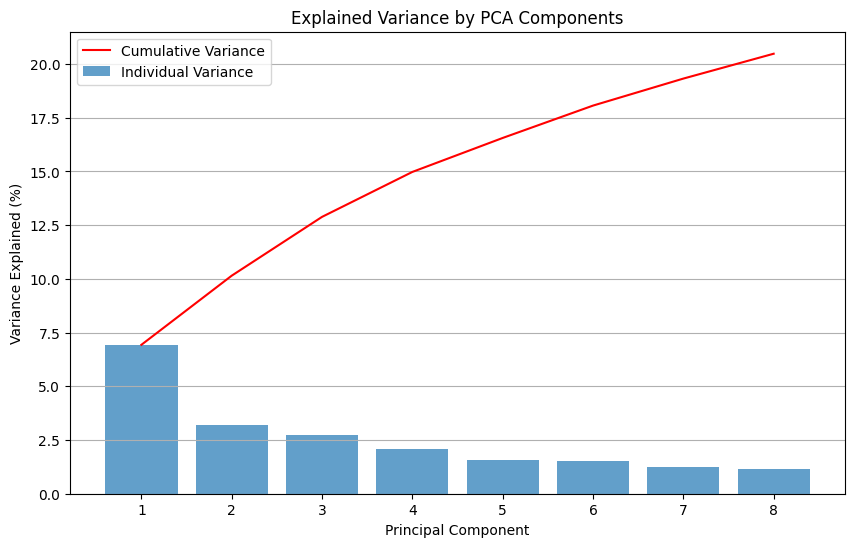

In [48]:
plt.figure(figsize=(10, 6))
plt.bar(explained_variance['Component'], explained_variance['ExplainedVariance'], alpha=0.7, label='Individual Variance')
plt.plot(explained_variance['Component'], explained_variance['CumulativeVariance'], color='red', label='Cumulative Variance')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('Explained Variance by PCA Components')
plt.legend()
plt.grid(axis='y')
plt.show()

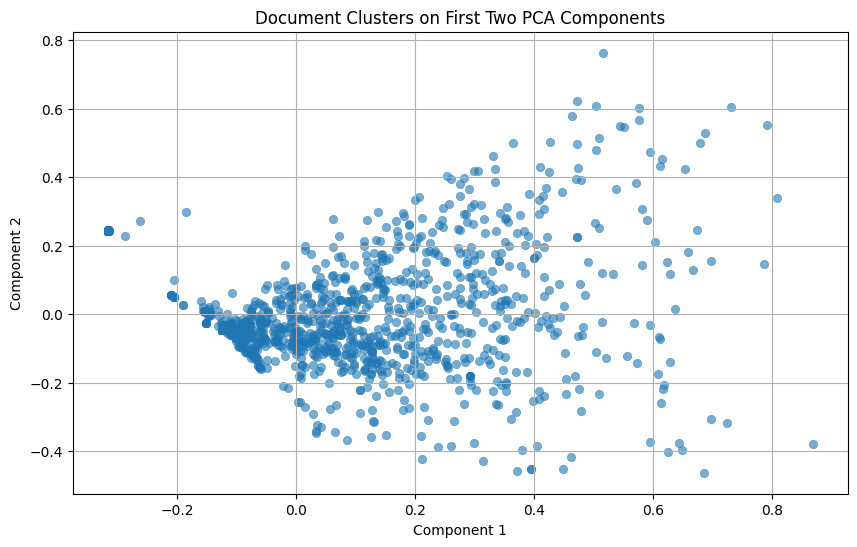

In [49]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=doc_components_df['Component_1'], y=doc_components_df['Component_2'], alpha=0.6, edgecolor=None)
plt.title('Document Clusters on First Two PCA Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid()
plt.show()

Might need to bring the clusters back to the dataset

# Sentiment

In [50]:
from textblob import TextBlob

def analyze_sentiment(library_df):
    """
    Add sentiment polarity and subjectivity to library_df.
    """
    polarity = []
    subjectivity = []
    
    # Assuming 'text' is a column in library_df containing the document text
    for text in library_df['text']:
        blob = TextBlob(text)
        polarity.append(blob.sentiment.polarity)
        subjectivity.append(blob.sentiment.subjectivity)
    
    # Add results to the DataFrame
    library_df['sentiment_polarity'] = polarity
    library_df['sentiment_subjectivity'] = subjectivity
    return library_df

# Analyze sentiment
f1_data = analyze_sentiment(f1_data)

# Display results
f1_data[['document_id', 'sentiment_polarity', 'sentiment_subjectivity']].head()

document_id  sentiment_polarity  sentiment_subjectivity
0  6755cb5d93a273b79e58426d           -0.037500                0.075000
1  6755cb5d93a273b79e58426d            0.233333                0.391667
2  6755cb5d93a273b79e58426d            0.101786                0.492857
3  6755cb5d93a273b79e58426d            0.082071                0.492593
4  6755cb5d93a273b79e58426d            0.033333                0.350000

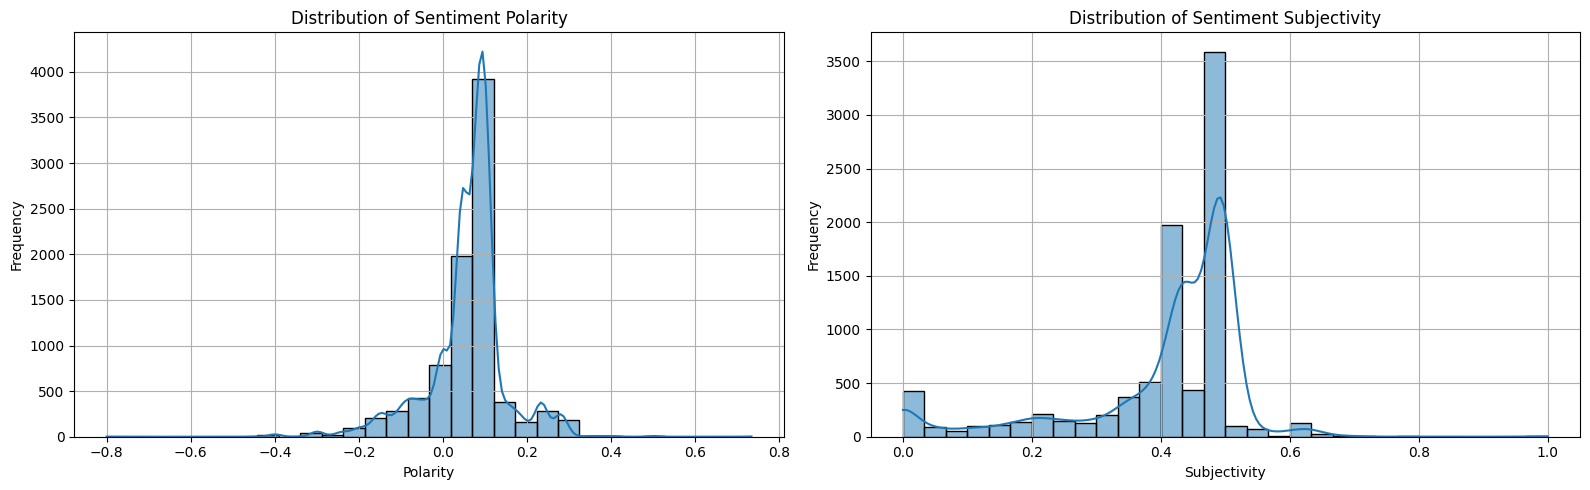

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(f1_data['sentiment_polarity'], kde=True, bins=30, ax=axes[0])
axes[0].set_title('Distribution of Sentiment Polarity')
axes[0].set_xlabel('Polarity')
axes[0].set_ylabel('Frequency')
axes[0].grid()

sns.histplot(f1_data['sentiment_subjectivity'], kde=True, bins=30, ax=axes[1])
axes[1].set_title('Distribution of Sentiment Subjectivity')
axes[1].set_xlabel('Subjectivity')
axes[1].set_ylabel('Frequency')
axes[1].grid()
plt.tight_layout()
plt.show()

C:\Users\bengb\AppData\Local\Temp\ipykernel_87364\4032548995.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['month'] = filtered_data['incident_date'].dt.to_period('M')


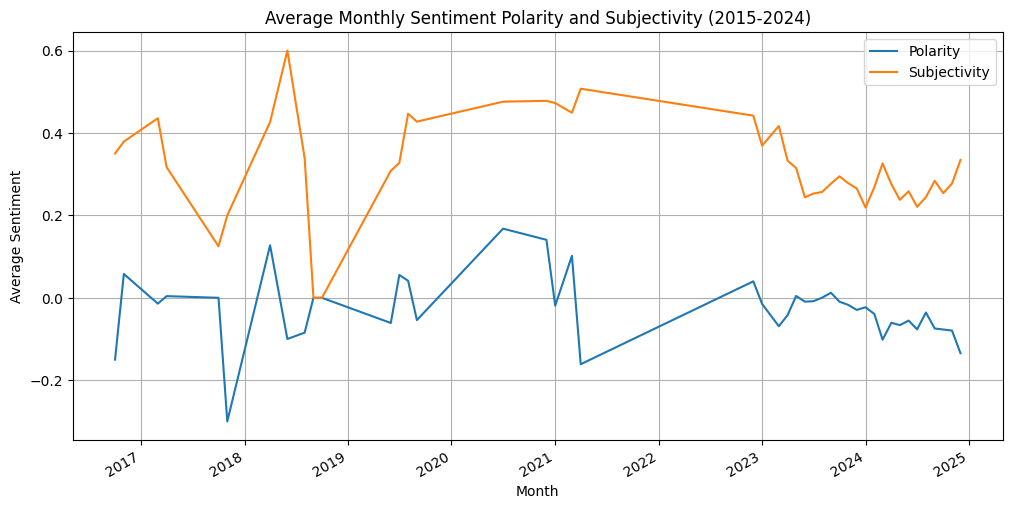

In [52]:
f1_data['incident_date'] = pd.to_datetime(f1_data['incident_date'])

# Filter the date range
start_date = '2015-01-01'
end_date = '2024-12-31'
filtered_data = f1_data[(f1_data['incident_date'] >= start_date) & (f1_data['incident_date'] <= end_date)]

# Calculate monthly average sentiment polarity and subjectivity
filtered_data['month'] = filtered_data['incident_date'].dt.to_period('M')
avg_monthly_sentiment_polarity = filtered_data.groupby('month')['sentiment_polarity'].mean()
avg_monthly_sentiment_subjectivity = filtered_data.groupby('month')['sentiment_subjectivity'].mean()

# Convert back to datetime for plotting
avg_monthly_sentiment_polarity.index = avg_monthly_sentiment_polarity.index.to_timestamp()
avg_monthly_sentiment_subjectivity.index = avg_monthly_sentiment_subjectivity.index.to_timestamp()

plt.figure(figsize=(12, 6))
avg_monthly_sentiment_polarity.plot(label='Polarity')
avg_monthly_sentiment_subjectivity.plot(label='Subjectivity')
plt.title('Average Monthly Sentiment Polarity and Subjectivity (2015-2024)')
plt.xlabel('Month')
plt.ylabel('Average Sentiment')
plt.legend()
plt.grid()
plt.show()

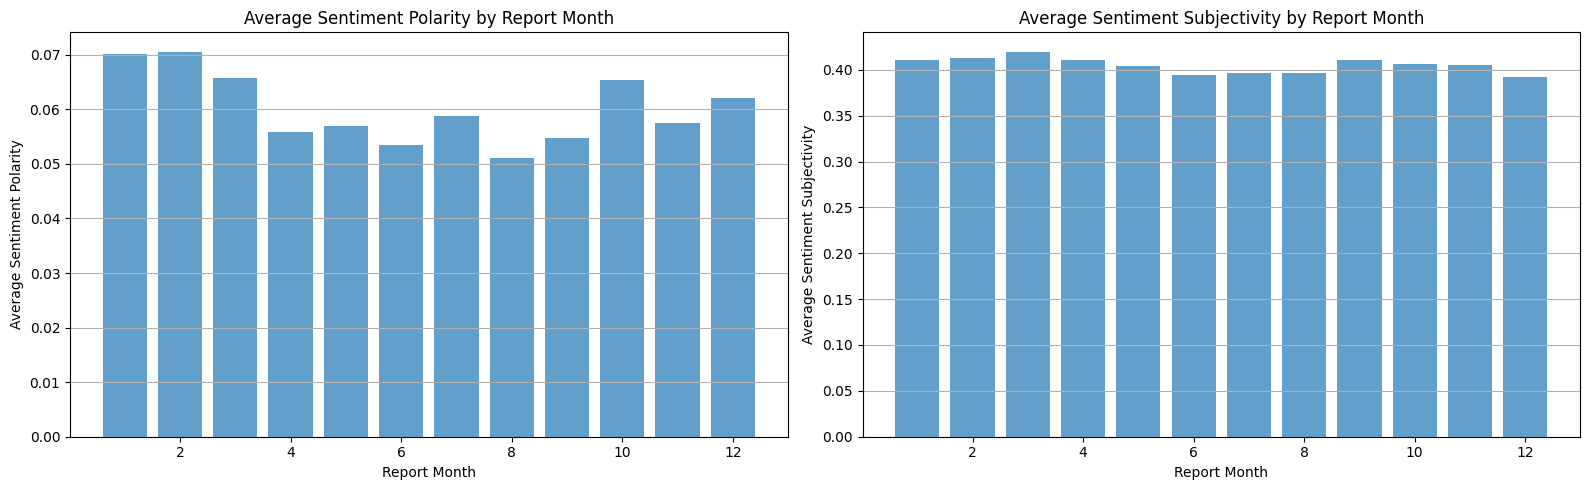

In [53]:
avg_sentiment_polarity_by_month = f1_data.groupby('report_month')['sentiment_polarity'].mean().sort_index()
avg_sentiment_subjectivity_by_month = f1_data.groupby('report_month')['sentiment_subjectivity'].mean().sort_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

axes[0].bar(avg_sentiment_polarity_by_month.index, avg_sentiment_polarity_by_month, alpha=0.7)
axes[0].set_title('Average Sentiment Polarity by Report Month')
axes[0].set_xlabel('Report Month')
axes[0].set_ylabel('Average Sentiment Polarity')
axes[0].grid(axis='y')

axes[1].bar(avg_sentiment_subjectivity_by_month.index, avg_sentiment_subjectivity_by_month, alpha=0.7)
axes[1].set_title('Average Sentiment Subjectivity by Report Month')
axes[1].set_xlabel('Report Month')
axes[1].set_ylabel('Average Sentiment Subjectivity')
axes[1].grid(axis='y')
plt.tight_layout()
plt.show()

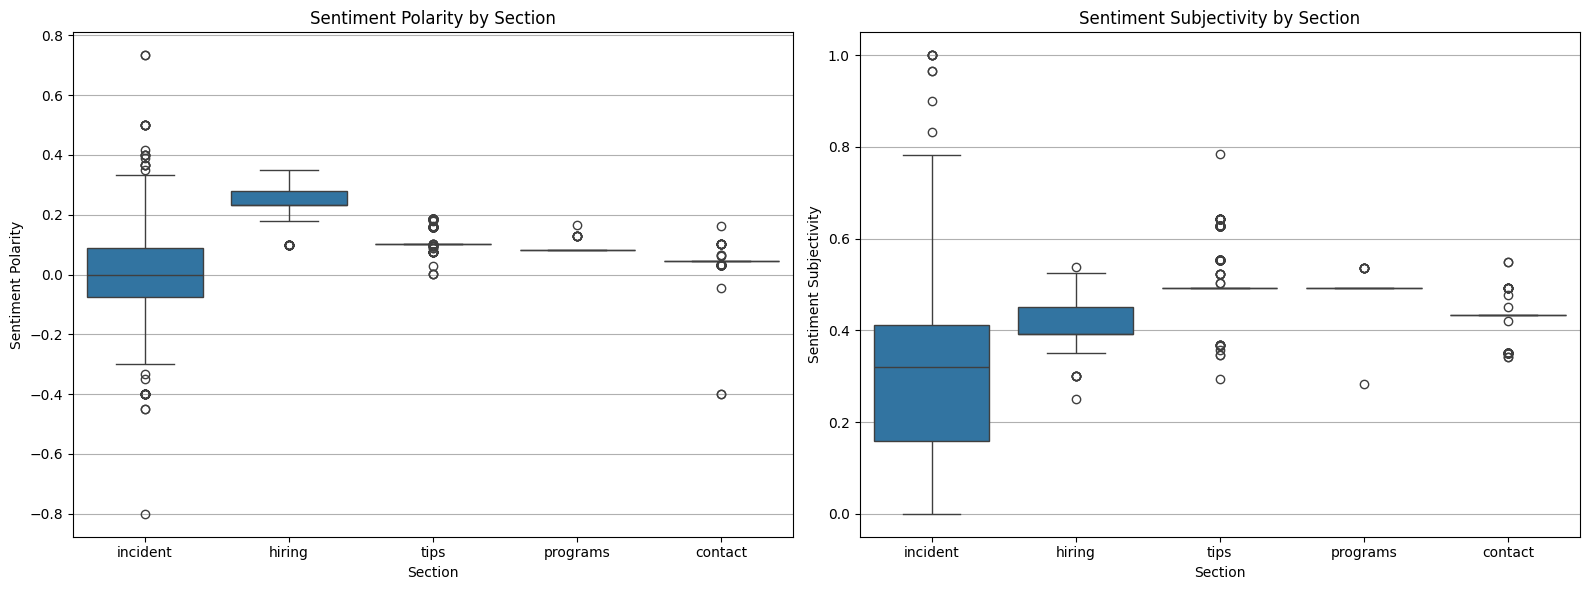

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.boxplot(x='section', y='sentiment_polarity', data=f1_data, ax=axes[0])
axes[0].set_title('Sentiment Polarity by Section')
axes[0].set_xlabel('Section')
axes[0].set_ylabel('Sentiment Polarity')
axes[0].grid(axis='y')

sns.boxplot(x='section', y='sentiment_subjectivity', data=f1_data, ax=axes[1])
axes[1].set_title('Sentiment Subjectivity by Section')
axes[1].set_xlabel('Section')
axes[1].set_ylabel('Sentiment Subjectivity')
axes[1].grid(axis='y')
plt.tight_layout()
plt.show()

## Sentiment

In [57]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import download
import pandas as pd
import numpy as np

# Download the VADER lexicon
download('vader_lexicon')

def add_sentiment_analysis(token_df, vocab_df, library_df):
    """
    Adds sentiment analysis at both the term level (VOCAB) and document level (LIBRARY).
    
    Parameters:
    - token_df: uses 'doc_id' for document identification
    - vocab_df: vocabulary DataFrame
    - library_df: uses 'document_id' for document identification
    """
    # Initialize VADER
    sid = SentimentIntensityAnalyzer()
    
    # Add sentiment scores to vocabulary terms
    print("Calculating term-level sentiment...")
    vocab_sentiments = []
    for term in vocab_df['term']:
        scores = sid.polarity_scores(str(term))
        vocab_sentiments.append({
            'term': term,
            'sentiment_score': scores['compound'],
            'negative_emotion': scores['neg'],
            'neutral_emotion': scores['neu'],
            'positive_emotion': scores['pos']
        })
    
    vocab_sentiment_df = pd.DataFrame(vocab_sentiments)
    vocab_df_enhanced = pd.merge(vocab_df, vocab_sentiment_df, on='term', how='left')
    
    # Calculate document-level sentiment
    print("Calculating document-level sentiment...")
    doc_sentiments = []
    
    # Group tokens by document
    for doc_id, group in token_df.groupby('doc_id'):
        # Concatenate all tokens in the document
        text = ' '.join(group['token'].astype(str))
        scores = sid.polarity_scores(text)
        
        doc_sentiments.append({
            'document_id': doc_id,  # Changed from 'doc_id' to 'document_id' to match library_df
            'sentiment_compound': scores['compound'],
            'sentiment_pos': scores['pos'],
            'sentiment_neu': scores['neu'],
            'sentiment_neg': scores['neg'],
            'sentiment_category': 'positive' if scores['compound'] > 0.05 
                                else 'negative' if scores['compound'] < -0.05 
                                else 'neutral'
        })
    
    doc_sentiment_df = pd.DataFrame(doc_sentiments)
    library_df_enhanced = pd.merge(library_df, doc_sentiment_df, on='document_id', how='left')
    
    # Print some summary statistics
    print("\nDocument Sentiment Distribution:")
    print(doc_sentiment_df['sentiment_category'].value_counts())
    
    print("\nAverage sentiment scores across documents:")
    print(f"Compound: {doc_sentiment_df['sentiment_compound'].mean():.3f}")
    print(f"Positive: {doc_sentiment_df['sentiment_pos'].mean():.3f}")
    print(f"Negative: {doc_sentiment_df['sentiment_neg'].mean():.3f}")
    
    # Look at most positive and negative terms
    print("\nMost positive terms:")
    print(vocab_df_enhanced.nlargest(10, 'sentiment_score')[['term', 'sentiment_score']])
    
    print("\nMost negative terms:")
    print(vocab_df_enhanced.nsmallest(10, 'sentiment_score')[['term', 'sentiment_score']])
    
    return vocab_df_enhanced, library_df_enhanced

# Apply sentiment analysis to our data
vocab_df_sentiment, library_df_sentiment = add_sentiment_analysis(token_df_f4, vocab_df_f3, library_df_f3)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bengb\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Calculating term-level sentiment...
Calculating document-level sentiment...

Document Sentiment Distribution:
sentiment_category
negative    1900
positive       3
Name: count, dtype: int64

Average sentiment scores across documents:
Compound: -0.997
Positive: 0.045
Negative: 0.307

Most positive terms:
                 term  sentiment_score
2582             best           0.6369
4888          freedom           0.6369
6263             love           0.6369
5121            great           0.6249
5066         gorgeous           0.6124
7042      outstanding           0.6124
2522        beautiful           0.5994
3514  congratulations           0.5994
4334          ecstasy           0.5994
6264            loved           0.5994

Most negative terms:
          term  sentiment_score
5913      kill          -0.6908
6683    murder          -0.6908
7729      rape          -0.6908
7730     raped          -0.6808
4651  fatality          -0.6705
5914    killed          -0.6705
9006  suicidal       

# Word2Vec

In [63]:
from gensim.models import Word2Vec
import numpy as np

def create_word_embeddings(token_df, vocab_df, vector_size=100):
    """
    Creates word embeddings with improved preprocessing for better semantic relationships.
    """
    print("Preprocessing tokens for word2vec...")
    
    def preprocess_token(token):
        """Clean individual tokens"""
        token = str(token).lower()
        # Split concatenated words (based on camelCase or other patterns)
        # Remove numbers unless they're part of important codes
        # Remove any remaining special characters
        return token
    
    # Group tokens by document and preprocess
    sentences = []
    for _, group in token_df.groupby('doc_id'):
        sentence = [preprocess_token(token) for token in group['token']]
        # Filter out None or empty strings
        sentence = [token for token in sentence if token and len(token) > 1]
        sentences.append(sentence)
    
    print(f"Training Word2Vec model on {len(sentences)} documents...")
    model = Word2Vec(
        sentences,
        vector_size=vector_size,
        window=7,          # Increased context window
        min_count=5,       # Ignore rarer words
        workers=4,
        sg=1,             # Skip-gram
        epochs=20         # More training epochs
    )
    
    print("Creating embeddings table...")
    embedding_cols = [f'embed_{i}' for i in range(vector_size)]
    embeddings = []
    
    for term in vocab_df['term']:
        try:
            vector = model.wv[str(term).lower()]
        except KeyError:
            vector = np.zeros(vector_size)
        embeddings.append(vector)
    
    embeddings_df = pd.DataFrame(
        embeddings,
        columns=embedding_cols,
        index=vocab_df.index
    )
    
    vocab_df_enhanced = pd.concat([vocab_df, embeddings_df], axis=1)
    
    # Analyze semantic relationships
    test_words = ['vehicle', 'victim', 'theft', 'assault', 'suspect', 'officer']
    print("\nKey term relationships:")
    for word in test_words:
        try:
            similar = model.wv.most_similar(word, topn=5)
            print(f"\nTerms related to '{word}':")
            for similar_word, score in similar:
                print(f"  - {similar_word}: {score:.3f}")
        except KeyError:
            print(f"'{word}' not found in vocabulary")
    
    # Analyze specific crime categories
    crime_types = ['theft', 'robbery', 'assault', 'burglary']
    print("\nCrime type analysis:")
    for crime in crime_types:
        try:
            # Get related terms
            related = model.wv.most_similar(positive=[crime], topn=5)
            print(f"\nTerms associated with {crime}:")
            for term, score in related:
                print(f"  - {term}: {score:.3f}")
            
            # Try to find victim/suspect patterns
            context = model.wv.most_similar(
                positive=[crime, 'victim'],
                negative=['report'],
                topn=3
            )
            print(f"Common context ({crime} + victim):")
            for term, score in context:
                print(f"  - {term}: {score:.3f}")
        except KeyError:
            continue
    
    return vocab_df_enhanced, model

# Create embeddings with improved preprocessing
vocab_df_with_embeddings, word2vec_model = create_word_embeddings(token_df_f4, vocab_df_f3)

Preprocessing tokens for word2vec...
Training Word2Vec model on 1903 documents...
Creating embeddings table...

Key term relationships:

Terms related to 'vehicle':
  - lexus: 0.585
  - disabled: 0.582
  - window: 0.578
  - driven: 0.571
  - nationwide: 0.564

Terms related to 'victim':
  - stabbed: 0.708
  - finger: 0.651
  - laceration: 0.648
  - stab: 0.639
  - bat: 0.637

Terms related to 'theft':
  - auto: 0.618
  - burglary: 0.565
  - prevent: 0.527
  - helps: 0.524
  - boucher: 0.519

Terms related to 'assault':
  - aggravated: 0.759
  - cruelty: 0.631
  - agg: 0.614
  - endangerment: 0.608
  - deg: 0.606

Terms related to 'suspect':
  - couch: 0.560
  - fell: 0.546
  - brandishing: 0.538
  - doorbell: 0.530
  - implied: 0.530
'officer' not found in vocabulary

Crime type analysis:

Terms associated with theft:
  - auto: 0.618
  - burglary: 0.565
  - prevent: 0.527
  - helps: 0.524
  - boucher: 0.519
Common context (theft + victim):
  - laceration: 0.469
  - envelope: 0.447
  - 

# Misc Plots

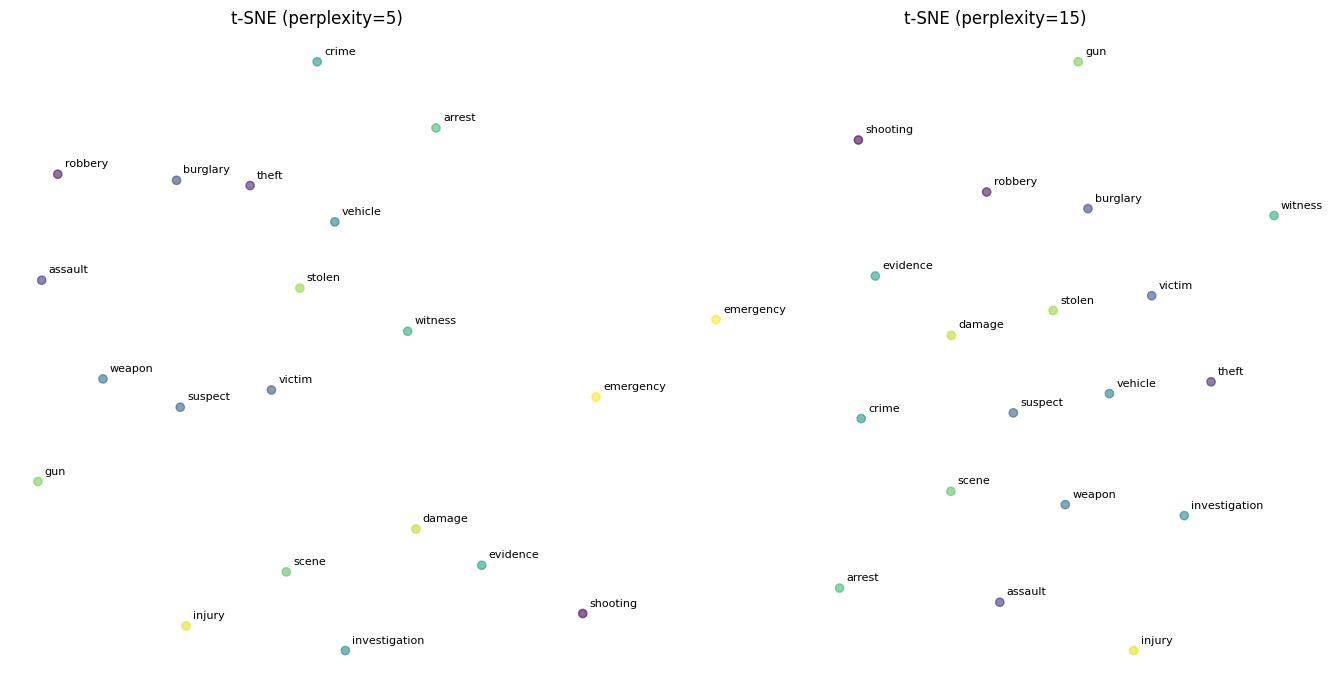

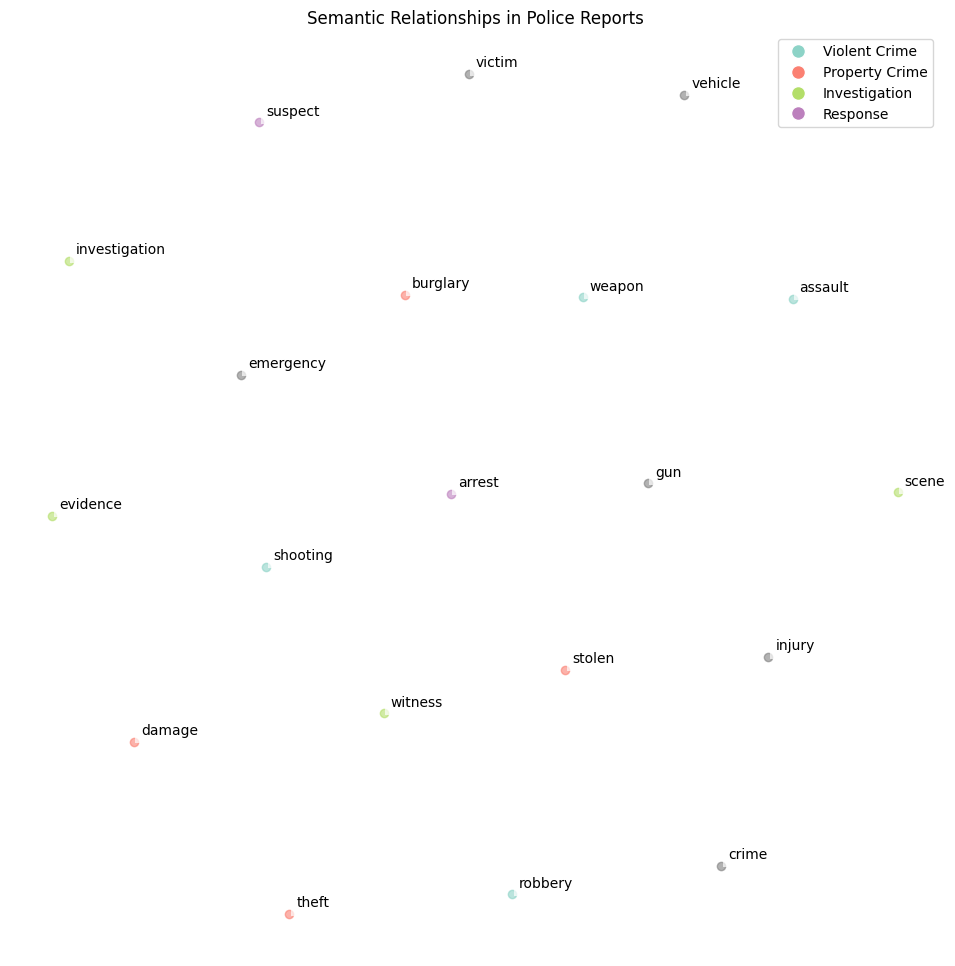

In [68]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_enhanced_tsne_plot(word2vec_model, focus_terms=None, perplexity=30, n_iter=3000):
    """
    Creates an enhanced t-SNE visualization of word embeddings with:
    - Careful parameter selection
    - Multiple perplexity values comparison
    - Cluster analysis
    - Semantic relationship visualization
    """
    # First, get our word vectors
    if focus_terms:
        # Use specified terms if provided
        words = [w for w in focus_terms if w in word2vec_model.wv]
        vectors = [word2vec_model.wv[w] for w in words]
    else:
        # Otherwise use most common words
        words = word2vec_model.wv.index_to_key[:100]
        vectors = [word2vec_model.wv[word] for word in words]
    
    vectors = np.array(vectors)
    
    # Try different perplexity values
    perplexities = [5, 15, 30]
    plt.figure(figsize=(20, 7))
    
    for idx, perp in enumerate(perplexities, 1):
        # Ensure perplexity is valid for our sample size
        if perp >= len(vectors):
            continue
            
        plt.subplot(1, 3, idx)
        
        # Apply t-SNE with current perplexity
        tsne = TSNE(
            n_components=2,
            perplexity=perp,
            n_iter=n_iter,
            random_state=42,
            learning_rate='auto',
            init='pca'  # Initialize with PCA for more stability
        )
        
        vectors_tsne = tsne.fit_transform(vectors)
        
        # Create scatter plot
        scatter = plt.scatter(
            vectors_tsne[:, 0],
            vectors_tsne[:, 1],
            alpha=0.6,
            c=range(len(vectors)),  # Color points by word frequency
            cmap='viridis'
        )
        
        # Add labels with better visibility
        for i, word in enumerate(words):
            plt.annotate(
                word,
                xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                bbox=dict(
                    facecolor='white',
                    edgecolor='none',
                    alpha=0.7,
                    pad=2
                )
            )
        
        plt.title(f't-SNE (perplexity={perp})')
        plt.grid(True, alpha=0.3)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Create focused semantic relationships plot
    if focus_terms:
        # Group terms by category
        categories = {
            'Violent Crime': ['shooting', 'assault', 'robbery', 'weapon'],
            'Property Crime': ['theft', 'burglary', 'stolen', 'damage'],
            'Investigation': ['evidence', 'witness', 'investigation', 'scene'],
            'Response': ['officer', 'police', 'arrest', 'suspect']
        }
        
        # Create t-SNE with optimal perplexity
        tsne = TSNE(
            n_components=2,
            perplexity=min(30, len(vectors) - 1),
            n_iter=n_iter,
            random_state=42,
            init='pca'
        )
        
        vectors_tsne = tsne.fit_transform(vectors)
        
        # Plot with category-based coloring
        plt.figure(figsize=(12, 12))
        
        # Create color map for categories
        category_colors = {}
        for i, category in enumerate(categories.keys()):
            category_colors[category] = plt.cm.Set3(i / len(categories))
        
        # Plot points with category colors
        for word, coords in zip(words, vectors_tsne):
            # Find category for word
            category = next(
                (cat for cat, terms in categories.items() if word in terms),
                'Other'
            )
            color = category_colors.get(category, 'gray')
            
            plt.scatter(coords[0], coords[1], color=color, alpha=0.6)
            plt.annotate(
                word,
                coords,
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=10,
                bbox=dict(
                    facecolor='white',
                    edgecolor='none',
                    alpha=0.7
                )
            )
        
        # Add legend
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=color, label=cat, markersize=10)
            for cat, color in category_colors.items()
        ]
        plt.legend(handles=legend_elements, loc='best')
        
        plt.title('Semantic Relationships in Police Reports')
        plt.grid(True, alpha=0.3)
        plt.axis('off')
        plt.show()

# Define terms to focus on
crime_terms = [
    'shooting', 'robbery', 'theft', 'assault', 'burglary',
    'victim', 'suspect', 'weapon', 'vehicle', 'officer',
    'investigation', 'crime', 'evidence', 'witness',
    'arrest', 'scene', 'police', 'gun', 'stolen',
    'damage', 'injury', 'emergency'
]

# Create visualizations
create_enhanced_tsne_plot(word2vec_model, crime_terms)

Preparing vectors for t-SNE...
Creating t-SNE plot for 3932 words...


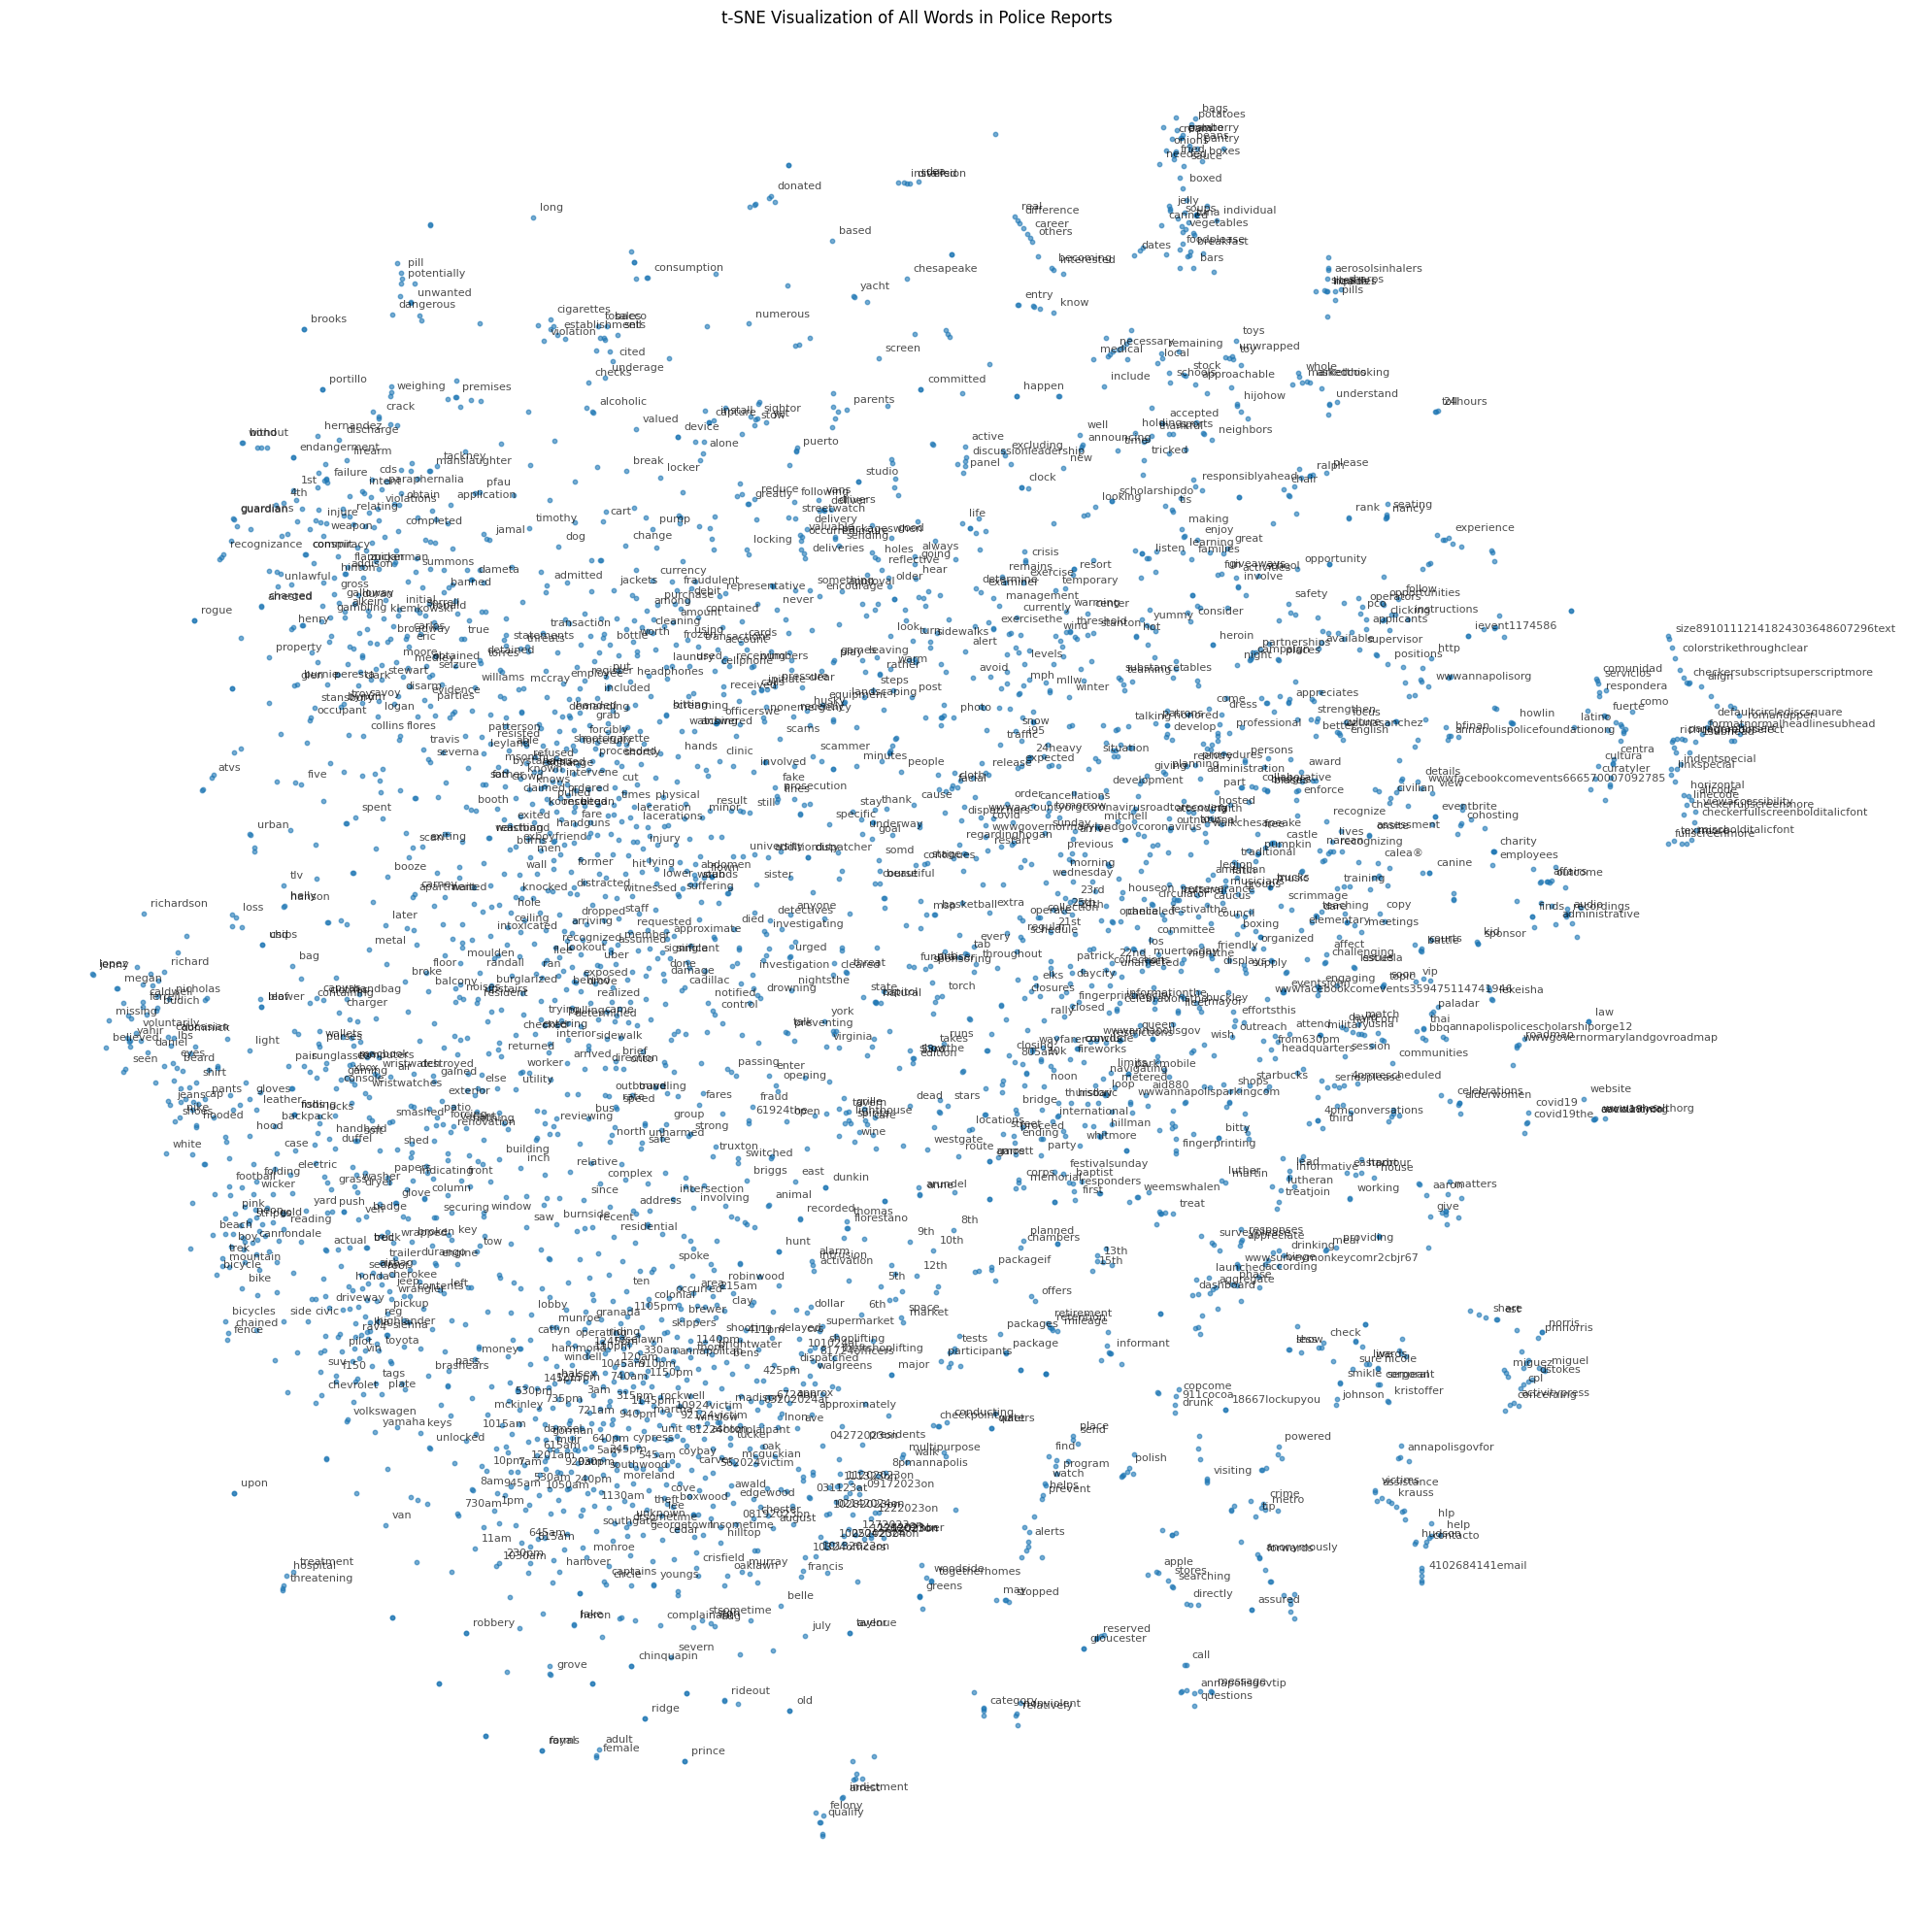


Total words visualized: 3932


In [69]:
def create_full_tsne_plot(word2vec_model, min_freq=5):
    """
    Creates t-SNE visualization for all words in the vocabulary,
    with some basic frequency filtering to keep the plot readable.
    """
    print("Preparing vectors for t-SNE...")
    words = []
    vectors = []
    
    # Get vectors for all words that appear at least min_freq times
    for word in word2vec_model.wv.index_to_key:
        vectors.append(word2vec_model.wv[word])
        words.append(word)
    
    vectors = np.array(vectors)
    
    print(f"Creating t-SNE plot for {len(words)} words...")
    
    # Apply t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=min(30, len(vectors) - 1),
        n_iter=2000,
        random_state=42,
        init='pca'  # Use PCA initialization for stability
    )
    
    vectors_tsne = tsne.fit_transform(vectors)
    
    # Create the visualization
    plt.figure(figsize=(20, 20))
    
    # Create scatter plot
    scatter = plt.scatter(
        vectors_tsne[:, 0],
        vectors_tsne[:, 1],
        alpha=0.6,
        s=10  # Smaller point size for better visibility with many points
    )
    
    # Add labels with some filtering to prevent overcrowding
    for i, word in enumerate(words):
        if i % 3 == 0:  # Only label every third word to reduce clutter
            plt.annotate(
                word,
                xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                alpha=0.7
            )
    
    plt.title('t-SNE Visualization of All Words in Police Reports')
    plt.grid(True, alpha=0.3)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print some statistics about the visualization
    print(f"\nTotal words visualized: {len(words)}")
    
    return vectors_tsne, words

# Create the visualization
vectors_tsne, words = create_full_tsne_plot(word2vec_model)

Preparing vectors for t-SNE...
Creating t-SNE plot for 3932 words...

Total words visualized: 3932
Number of labels shown: 159


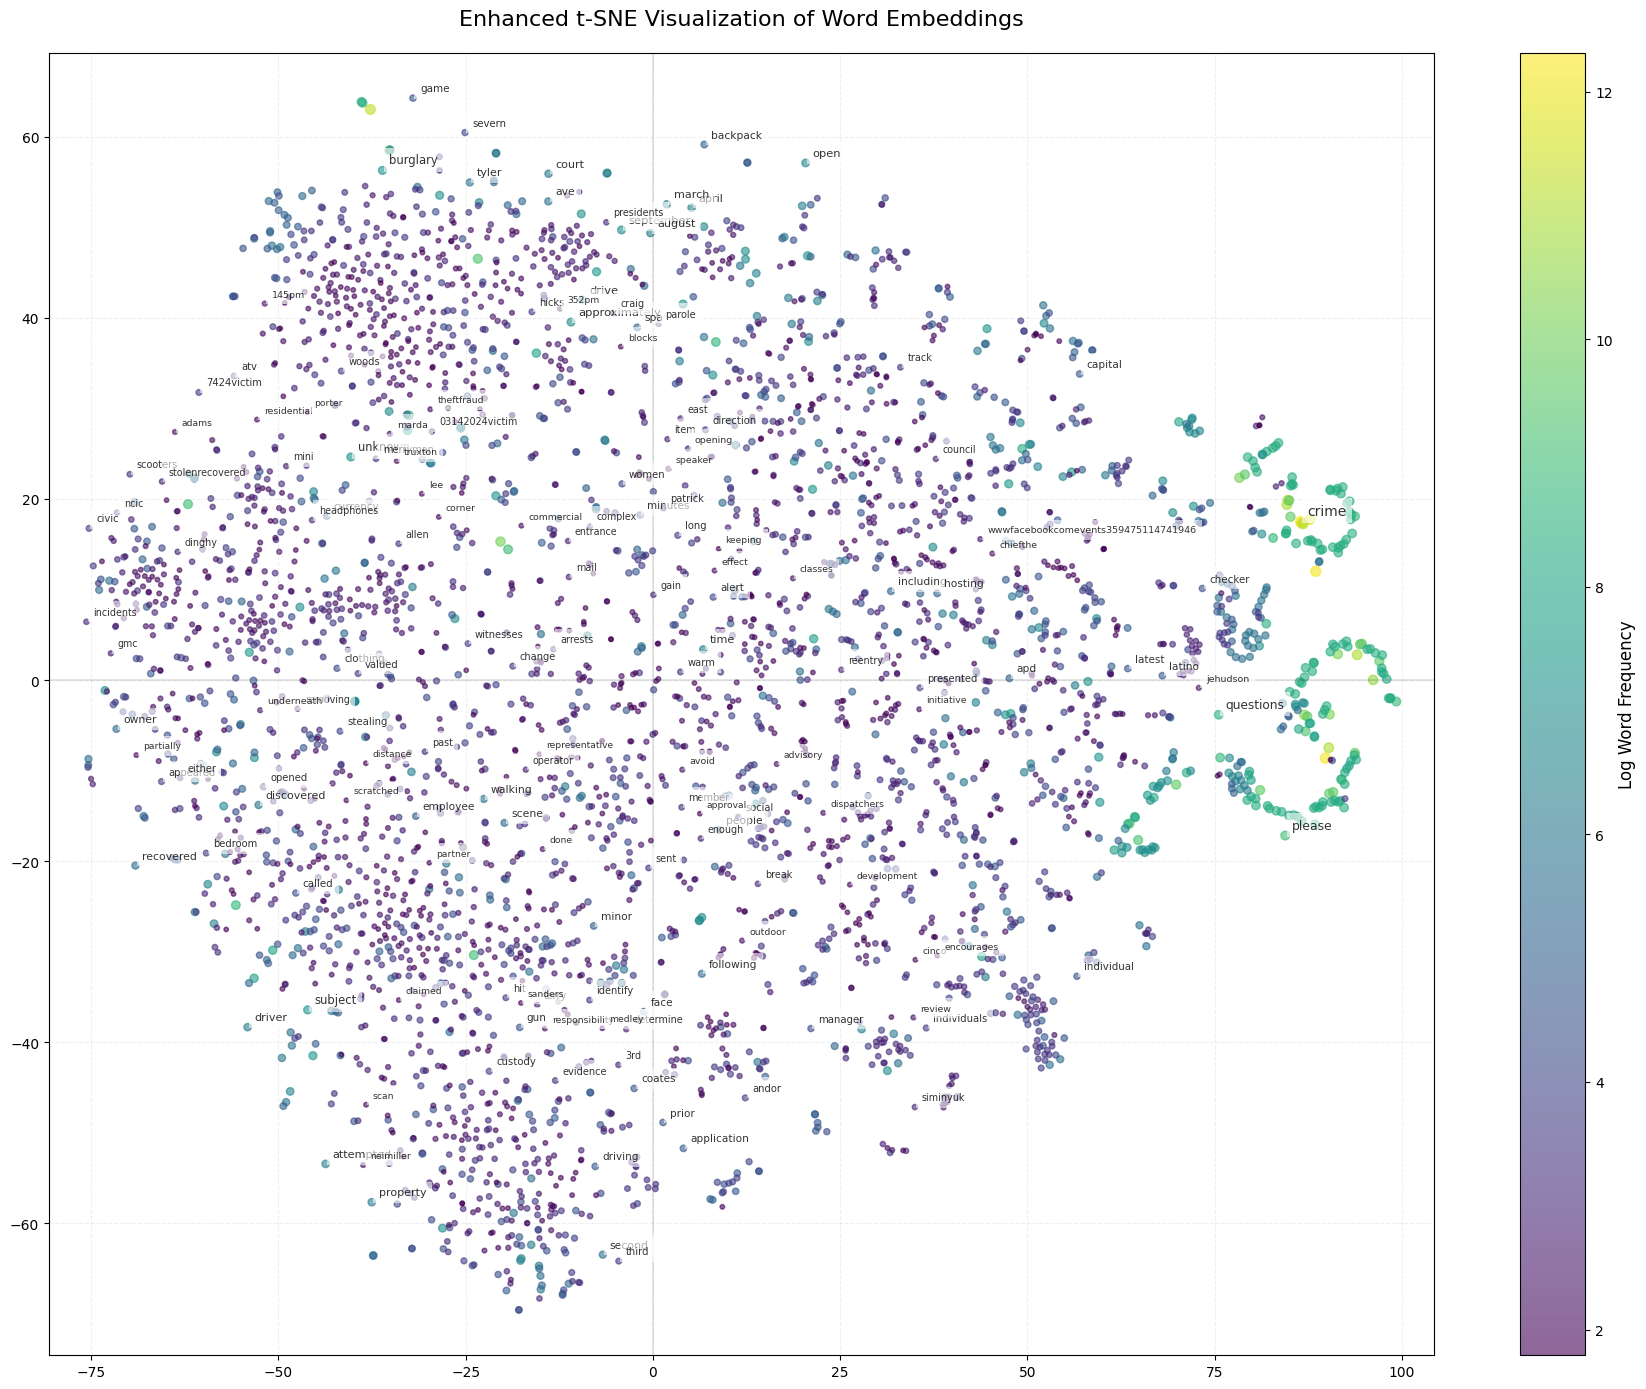

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree

def create_enhanced_tsne_plot(word2vec_model, min_freq=5, max_labels=300, perplexity=40):
    """
    Creates an enhanced t-SNE visualization with improved clustering and labeling.
    
    Parameters:
    - word2vec_model: Trained Word2Vec model
    - min_freq: Minimum frequency threshold for words
    - max_labels: Maximum number of labels to show
    - perplexity: t-SNE perplexity parameter
    """
    print("Preparing vectors for t-SNE...")
    words = []
    vectors = []
    frequencies = []
    
    # Collect data
    for word in word2vec_model.wv.index_to_key:
        freq = word2vec_model.wv.get_vecattr(word, "count")
        vectors.append(word2vec_model.wv[word])
        words.append(word)
        frequencies.append(freq)
    
    vectors = np.array(vectors)
    frequencies = np.array(frequencies)
    
    # Normalize vectors
    scaler = StandardScaler()
    vectors_normalized = scaler.fit_transform(vectors)
    
    print(f"Creating t-SNE plot for {len(words)} words...")
    
    # Enhanced t-SNE parameters
    tsne = TSNE(
        n_components=2,
        perplexity=min(perplexity, len(vectors) - 1),
        n_iter=5000,  # Increased iterations
        random_state=42,
        init='pca',
        early_exaggeration=20.0,  # Increased for better separation
        learning_rate='auto',
        metric='cosine',
        n_jobs=-1  # Use all available cores
    )
    
    vectors_tsne = tsne.fit_transform(vectors_normalized)
    
    # Create figure with specific dimensions
    plt.figure(figsize=(18, 14))
    
    # Enhanced point sizing
    log_frequencies = np.log1p(frequencies)  # Log scale for better size distribution
    sizes = 50 * (log_frequencies / np.max(log_frequencies)) + 3
    
    # Create main scatter plot
    scatter = plt.scatter(
        vectors_tsne[:, 0],
        vectors_tsne[:, 1],
        alpha=0.6,
        s=sizes,
        c=log_frequencies,
        cmap='viridis'
    )
    
    # Smart label placement using KD-tree
    tree = cKDTree(vectors_tsne)
    
    # Find points to label
    labeled_points = set()
    min_distance = 2.0  # Minimum distance between labeled points
    
    # Sort points by frequency for priority labeling
    sorted_indices = np.argsort(frequencies)[::-1]
    
    for idx in sorted_indices:
        if len(labeled_points) >= max_labels:
            break
            
        # Check if point is too close to already labeled points
        if labeled_points:
            distances, _ = tree.query(vectors_tsne[idx], k=2)
            if distances[1] < min_distance:
                continue
                
        labeled_points.add(idx)
        
        # Dynamic font size based on frequency
        font_size = min(10, 6 + np.log1p(frequencies[idx]) / np.log1p(np.max(frequencies)) * 4)
        
        plt.annotate(
            words[idx],
            (vectors_tsne[idx, 0], vectors_tsne[idx, 1]),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=font_size,
            alpha=0.8,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6)
        )
    
    # Enhance plot aesthetics
    plt.title('Enhanced t-SNE Visualization of Word Embeddings', pad=20, fontsize=16)
    plt.grid(True, alpha=0.2, linestyle='--')
    
    # Add colorbar with frequency legend
    cbar = plt.colorbar(scatter, label='Log Word Frequency')
    cbar.ax.set_ylabel('Log Word Frequency', fontsize=12)
    
    # Set axis limits with some padding
    plt.xlim(vectors_tsne[:, 0].min() - 5, vectors_tsne[:, 0].max() + 5)
    plt.ylim(vectors_tsne[:, 1].min() - 5, vectors_tsne[:, 1].max() + 5)
    
    # Add subtle axes
    plt.axhline(y=0, color='k', alpha=0.1)
    plt.axvline(x=0, color='k', alpha=0.1)
    
    plt.tight_layout()
    
    print(f"\nTotal words visualized: {len(words)}")
    print(f"Number of labels shown: {len(labeled_points)}")
    
    plt.show()
    
    return vectors_tsne, words, frequencies

# Create the visualization
vectors_tsne, words, frequencies = create_enhanced_tsne_plot(word2vec_model)

Preparing vectors for t-SNE...


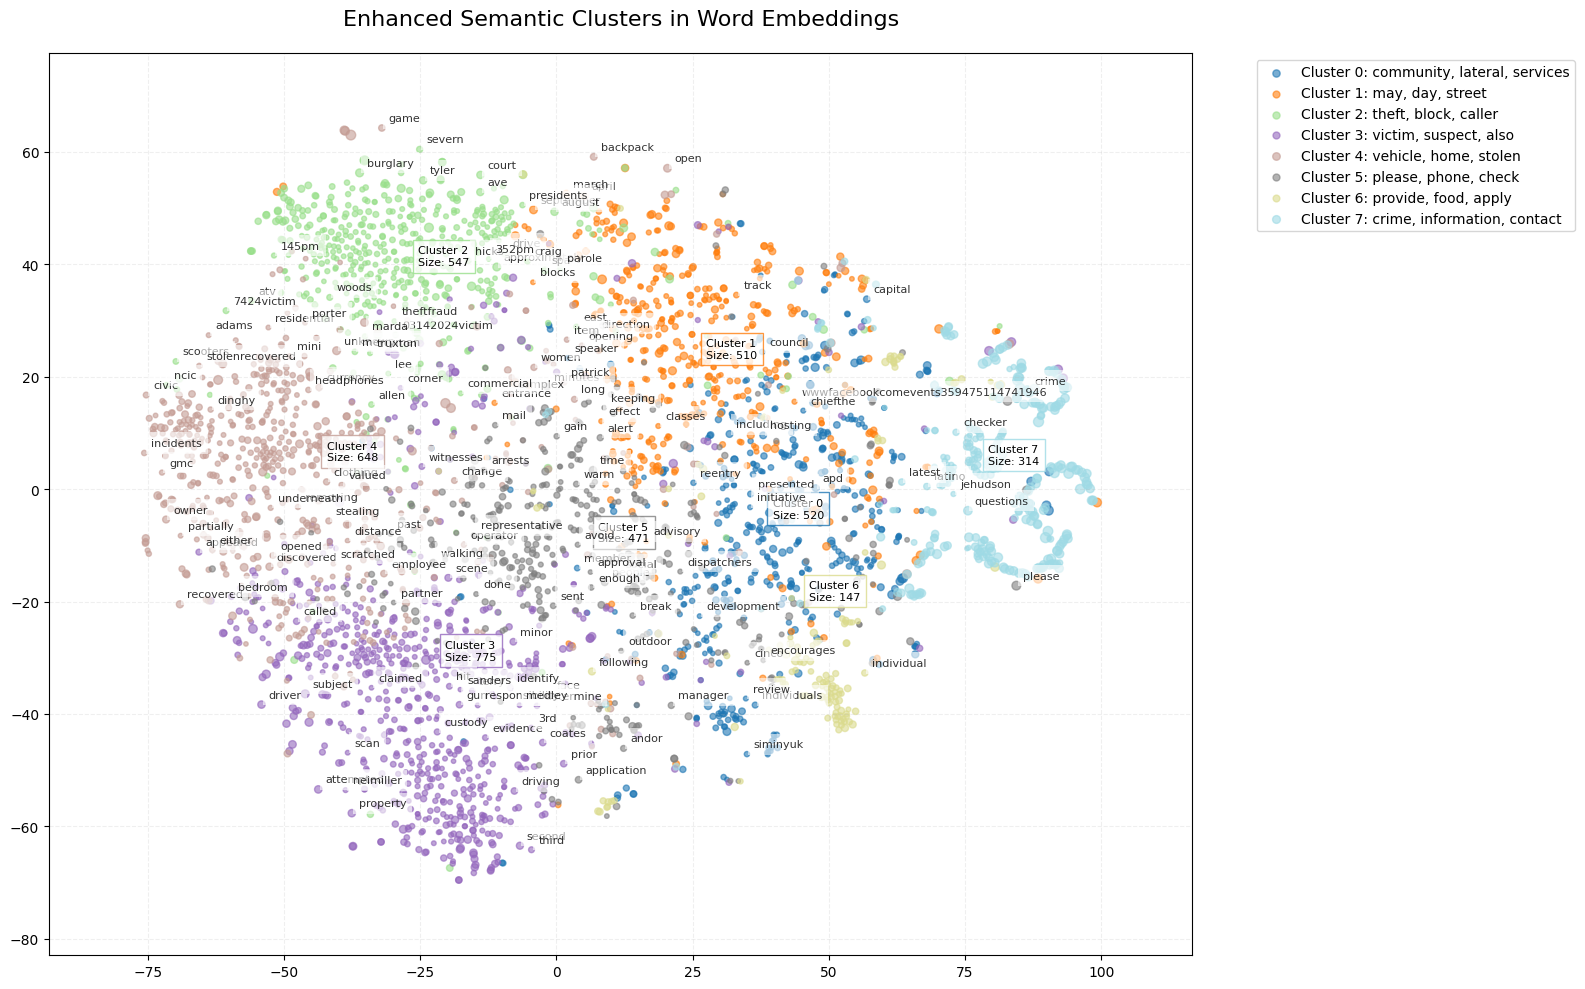

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree

def create_zoomed_semantic_tsne(word2vec_model, min_freq=5, n_clusters=8, perplexity=40, max_labels=300):
    """
    Creates a zoomed-in t-SNE visualization with semantic clustering.
    """
    print("Preparing vectors for t-SNE...")
    words = []
    vectors = []
    frequencies = []
    
    for word in word2vec_model.wv.index_to_key:
        freq = word2vec_model.wv.get_vecattr(word, "count")
        vectors.append(word2vec_model.wv[word])
        words.append(word)
        frequencies.append(freq)
    
    vectors = np.array(vectors)
    frequencies = np.array(frequencies)
    
    # Normalize vectors
    scaler = StandardScaler()
    vectors_normalized = scaler.fit_transform(vectors)
    
    # Enhanced t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=min(perplexity, len(vectors) - 1),
        n_iter=5000,
        random_state=42,
        init='pca',
        early_exaggeration=20.0,
        learning_rate='auto',
        metric='cosine',
        n_jobs=-1
    )
    
    vectors_tsne = tsne.fit_transform(vectors_normalized)
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(vectors_normalized)
    
    # Create figure
    plt.figure(figsize=(16, 10))
    
    # Generate colors for clusters
    colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))
    
    # Plot clusters
    for i in range(n_clusters):
        mask = cluster_labels == i
        
        # Get cluster statistics
        cluster_words = [words[j] for j in range(len(words)) if cluster_labels[j] == i]
        cluster_freqs = [frequencies[j] for j in range(len(frequencies)) if cluster_labels[j] == i]
        top_words = [w for _, w in sorted(zip(cluster_freqs, cluster_words), reverse=True)[:5]]
        
        # Calculate cluster metrics
        avg_freq = np.mean(cluster_freqs)
        cluster_size = np.sum(mask)
        
        # Plot points
        sizes = 50 * (np.log1p(frequencies[mask]) / np.max(np.log1p(frequencies))) + 3
        plt.scatter(
            vectors_tsne[mask, 0],
            vectors_tsne[mask, 1],
            c=[colors[i]],
            alpha=0.6,
            s=sizes,
            label=f'Cluster {i}: {", ".join(top_words[:3])}'
        )
        
        # Add compact cluster annotation
        center = np.mean(vectors_tsne[mask], axis=0)
        stats_text = f'Cluster {i}\nSize: {cluster_size}'
        plt.annotate(
            stats_text,
            xy=(center[0], center[1]),
            xytext=(5, 5),
            textcoords='offset points',
            bbox=dict(facecolor='white', edgecolor=colors[i], alpha=0.8),
            fontsize=8,
            ha='left',
            va='bottom'
        )
    
    # Add labels for selected points
    tree = cKDTree(vectors_tsne)
    labeled_points = set()
    min_distance = 2.0
    
    sorted_indices = np.argsort(frequencies)[::-1]
    for idx in sorted_indices:
        if len(labeled_points) >= max_labels:
            break
            
        if labeled_points:
            distances, _ = tree.query(vectors_tsne[idx], k=2)
            if distances[1] < min_distance:
                continue
                
        labeled_points.add(idx)
        plt.annotate(
            words[idx],
            (vectors_tsne[idx, 0], vectors_tsne[idx, 1]),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            alpha=0.8,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6)
        )
    
    # Calculate padding as a percentage of data range
    padding = 0.1  # 10% padding
    x_range = vectors_tsne[:, 0].max() - vectors_tsne[:, 0].min()
    y_range = vectors_tsne[:, 1].max() - vectors_tsne[:, 1].min()
    
    # Set tight limits with small padding
    plt.xlim(
        vectors_tsne[:, 0].min() - x_range * padding,
        vectors_tsne[:, 0].max() + x_range * padding
    )
    plt.ylim(
        vectors_tsne[:, 1].min() - y_range * padding,
        vectors_tsne[:, 1].max() + y_range * padding
    )
    
    plt.title('Enhanced Semantic Clusters in Word Embeddings', pad=20, fontsize=16)
    plt.grid(True, alpha=0.2, linestyle='--')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return vectors_tsne, words, cluster_labels

# Create the visualization
vectors_tsne, words, clusters = create_zoomed_semantic_tsne(word2vec_model)

# heres my old code here - good stuff here

## Data Lineage and Table Operations

### 1. DOC Table
- **Source**: `f1_data`
- **Operations**:
  - Reset index to add `doc_id`.
  - Extract relevant columns: `doc_id`, `document_id`, `incident_id`, `incident_date`, `report_date`, `link`.

### 2. TOKEN Table
- **Source**: `f1_data`
- **Operations**:
  - Tokenize `text` from `f1_data`.
  - Remove stopwords, lemmatize tokens, assign `position`.
  - Create records: `doc_id`, `incident_id`, `position`, `token_text`.
  - Merge with `term_table` to add `term_id`.
  - Assign `token_id`.

### 3. TERM Table
- **Source**: `token_table`
- **Operations**:
  - Extract unique `token_text` for `term_id`.
  - Calculate `document_frequency` (unique `doc_id` per term).
  - Calculate `collection_frequency` (total occurrences of each term).
  - Merge frequencies back into `term_table`.

### 4. Data Lineage
- `f1_data` → `doc_table`, `token_table` → `term_table` (via token and frequency operations).

- **Final Tables**: 
  - `doc_table`
  - `token_table`
  - `term_table`

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize
lemmatizer = WordNetLemmatizer()

# Default English stopwords
stop_words = set(stopwords.words('english'))

# 1. DOC table
f1_data = f1_data.reset_index(drop=True)
f1_data['doc_id'] = f1_data.index + 1  # Starting from 1

doc_table = f1_data[['doc_id', 'document_id', 'incident_id',
                     'incident_date', 'report_date', 'link', 'text']]

# 2. TOKEN table
token_records = []

for _, row in f1_data.iterrows():
    doc_id = row['doc_id']
    incident_id = row['incident_id']
    text = row['text'] 

    # Tokenize the text
    tokens = word_tokenize(text)

    for pos, token in enumerate(tokens):
        token_records.append({
            'doc_id': doc_id,
            'incident_id': incident_id,
            'position': pos + 1,  # Positions starting from 1
            'token_text': token
        })

token_table = pd.DataFrame(token_records)

# Assign term IDs
unique_terms = token_table['token_text'].unique()
term_table = pd.DataFrame({
    'term_id': range(1, len(unique_terms) + 1),
    'term_text': unique_terms
})

# Merge term_id back into token_table using 'token_text' and 'term_text' as keys
token_table = token_table.merge(term_table, left_on='token_text', right_on='term_text', how='left')

# 3. TERM table with frequencies
# Document frequency
doc_freq = token_table.groupby('term_id')['doc_id'].nunique().reset_index()
doc_freq = doc_freq.rename(columns={'doc_id': 'document_frequency'})

# Collection frequency
col_freq = token_table.groupby('term_id').size().reset_index(name='collection_frequency')

# Merge frequencies into term_table
term_table = term_table.merge(doc_freq, on='term_id', how='left')
term_table = term_table.merge(col_freq, on='term_id', how='left')

# Reorder columns in token_table
token_table = token_table[['doc_id', 'incident_id', 'position', 'term_id', 'token_text']]

# Optional: Reset index for token_table and assign token_id
token_table = token_table.reset_index(drop=True)
token_table['token_id'] = token_table.index + 1  # Starting from 1
token_table = token_table[['token_id', 'doc_id', 'incident_id', 'position', 'term_id', 'token_text']]

# Reorder columns in term_table
term_table = term_table[['term_id', 'term_text', 'document_frequency', 'collection_frequency']]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bengb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bengb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bengb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Tables

In [ ]:
print("DOC Table:")
doc_table.head(1)
#doc_table.to_csv(r'C:\Users\bengb\OneDrive\Documents\AnnapolisPD\Text_Analytics_Final_Project\data\F2_doc_table.csv', index = False)

DOC Table:


doc_id               document_id   incident_id incident_date report_date  \
0       1  6755cb5d93a273b79e58426d  202400025855    2024-12-05  2024-12-06   

                                                link  \
0  https://www.annapolis.gov/CivicSend/ViewMessag...   

                                                text  
0  domestic assault - 105 francis noel way 12/5/2...

In [ ]:
print("\nTOKEN Table:")
token_table.head()
#token_table.to_csv(r'C:\Users\bengb\OneDrive\Documents\AnnapolisPD\Text_Analytics_Final_Project\data\F2_token_table.csv', index = False)


TOKEN Table:


token_id  doc_id   incident_id  position  term_id token_text
0         1       1  202400025855         1        1   domestic
1         2       1  202400025855         2        2    assault
2         3       1  202400025855         3        3          -
3         4       1  202400025855         4        4        105
4         5       1  202400025855         5        5    francis
5         6       1  202400025855         6        6       noel
6         7       1  202400025855         7        7        way
7         8       1  202400025855         8        8  12/5/24on
8         9       1  202400025855         9        9    12/5/24
9        10       1  202400025855        10       10   officers

In [ ]:
print("\nTERM Table:")
term_table.head()
#term_table.to_csv(r'C:\Users\bengb\OneDrive\Documents\AnnapolisPD\Text_Analytics_Final_Project\data\F2_term_table.csv', index = False)


TERM Table:


term_id  term_text  document_frequency  collection_frequency
0        1   domestic                  17                    22
1        2    assault                 131                   218
2        3          -                 784                  1616
3        4        105                   1                     1
4        5    francis                  14                    17
5        6       noel                   5                     8
6        7        way                  29                    35
7        8  12/5/24on                   1                     1
8        9    12/5/24                   1                     1
9       10   officers                 736                  1869

In [ ]:
def validate_stadm_tables(doc_table, token_table, term_table):
    validation_results = {
        'total_documents': doc_table['doc_id'].nunique(),
        'total_tokens': len(token_table),
        'unique_terms': len(term_table),
        'missing_term_ids': token_table['term_id'].isnull().sum(),
        'tokens_per_doc': len(token_table) / doc_table['doc_id'].nunique(),
        'terms_coverage': len(term_table) / len(token_table)
    }
    
    print("STADM Validation Summary:")
    for metric, value in validation_results.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.2f}")
    
    return validation_results

In [ ]:
validation_results = validate_stadm_tables(doc_table, token_table, term_table)

STADM Validation Summary:
Total Documents: 1235.00
Total Tokens: 291042.00
Unique Terms: 9861.00
Missing Term Ids: 0.00
Tokens Per Doc: 235.66
Terms Coverage: 0.03


# Define domain-specific stopwords and regex patterns
domain_stopwords = set([
    'annapolis', 'maryland', 'police', 'department', 'metro', 'crime',
    'stoppers', 'caller', 'anonymous', 'tips', 'ward', 'report', 'incident',
    'daily', 'contact', 'community', 'service', 'unit', 'joe hudson', 'the annapolis police department',
    'md','annapolis police','departmentmedia'
])

# F3

Parallel Sentiment, Emotion, and NER Analysis:
Processes each unique document to compute sentiment scores (compound, positive, neutral, negative) using NLTK's VADER, extract emotions (negative, positive) with NRCLex, and identify named entities via spaCy.

Integration into Structured Tables: Merges the computed annotations into doc_table, assigns sentiment scores to token_table, and aggregates term frequencies by sentiment category into term_table, ensuring seamless integration of sentiment and emotion features into the data pipeline.

- Merge results into doc_table, token_table, term_table
- Aggregate sentiment and term frequencies


Udated Outputs:
- doc_table
- token_table
- term_table

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

# Create our F3 tables as copies
f3_doc = doc_table.copy()
f3_token = token_table.copy()
f3_term = term_table.copy()

# Create text series for processing
text_series = f1_data.set_index('doc_id')['text']

def enrich_tokens(f3_token, original_text_series):
    """
    Enrich tokens with linguistic annotations using spaCy.
    This function adds linguistic features like lemmas, parts of speech,
    and syntactic dependencies to each token in our dataset.
    """
    print(f"\nEnriching {len(f3_token)} tokens with linguistic annotations...")
    
    enriched_tokens = f3_token.copy()
    
    # Initialize new linguistic columns we'll be adding
    linguistic_columns = ['lemma', 'pos', 'tag', 'dep', 'is_stop', 'is_alpha', 'is_punct']
    for col in linguistic_columns:
        enriched_tokens[col] = None
    
    # Process each document's tokens
    for doc_id, doc_text in original_text_series.items():
        doc_tokens = enriched_tokens[enriched_tokens['doc_id'] == doc_id]
        doc = nlp(doc_text)
        
        # Match spaCy's analysis with our tokens
        for i, (spacy_token, token_idx) in enumerate(zip(doc, doc_tokens.index)):
            enriched_tokens.loc[token_idx, 'lemma'] = spacy_token.lemma_
            enriched_tokens.loc[token_idx, 'pos'] = spacy_token.pos_
            enriched_tokens.loc[token_idx, 'tag'] = spacy_token.tag_
            enriched_tokens.loc[token_idx, 'dep'] = spacy_token.dep_
            enriched_tokens.loc[token_idx, 'is_stop'] = spacy_token.is_stop
            enriched_tokens.loc[token_idx, 'is_alpha'] = spacy_token.is_alpha
            enriched_tokens.loc[token_idx, 'is_punct'] = spacy_token.is_punct
    
    return enriched_tokens

# Enrich tokens first
print("Starting token enrichment...")
f3_token = enrich_tokens(f3_token, text_series)

# Verify token enrichment worked
print("\nVerifying token enrichment:")
print("Columns in f3_token:", f3_token.columns.tolist())
print("\nSample enriched token:")
f3_token.head(1)

Starting token enrichment...

Enriching 291042 tokens with linguistic annotations...

Verifying token enrichment:
Columns in f3_token: ['token_id', 'doc_id', 'incident_id', 'position', 'term_id', 'token_text', 'lemma', 'pos', 'tag', 'dep', 'is_stop', 'is_alpha', 'is_punct']

Sample enriched token:


token_id  doc_id   incident_id  position  term_id token_text     lemma  \
0         1       1  202400025855         1        1   domestic  domestic   

   pos tag   dep is_stop is_alpha is_punct  
0  ADJ  JJ  amod   False     True    False

In [ ]:
def enrich_f3_term(f3_term, f3_token):
    """
    Enrich the F3 term table with aggregated linguistic information from tokens.
    This function takes our enriched tokens and summarizes their linguistic features
    at the term level, showing how words typically function across all their uses.
    """
    print(f"\nEnriching {len(f3_term)} terms with linguistic information...")
    
    # Let's see what our enriched tokens look like before aggregation
    print("\nSample of enriched tokens we're working with:")
    sample_columns = ['term_id', 'token_text', 'lemma', 'pos', 'dep', 'is_stop', 'is_alpha']
    print(f3_token[sample_columns].head())
    
    # Aggregate token-level linguistic features to the term level
    term_linguistics = f3_token.groupby('term_id').agg({
        # Most common form for these features
        'lemma': 'first',        # Base form of the word
        'pos': 'first',          # Part of speech
        'dep': 'first',          # Syntactic dependency
        'is_stop': 'first',      # Stopword status
        'is_alpha': 'first',     # Is it alphabetic?
        
        # We might also want to know how consistently these features appear
        'doc_id': 'nunique',     # How many documents contain this term
        'token_id': 'count'      # How many times the term appears total
    }).reset_index()
    
    # Rename the counting columns to be more clear
    term_linguistics = term_linguistics.rename(columns={
        'doc_id': 'num_documents',
        'token_id': 'total_occurrences'
    })
    
    # Merge these linguistic features with our original term table
    enriched_terms = f3_term.merge(term_linguistics, on='term_id', how='left')
    
    print("\nColumns in enriched term table:")
    print(enriched_terms.columns.tolist())
    print("\nSample of enriched terms:")
    print(enriched_terms.head())
    
    return enriched_terms

print("\nStarting term enrichment...")
f3_term = enrich_f3_term(f3_term, f3_token)


Starting term enrichment...

Enriching 9861 terms with linguistic information...

Sample of enriched tokens we're working with:
   term_id token_text     lemma    pos       dep is_stop is_alpha
0        1   domestic  domestic    ADJ      amod   False     True
1        2    assault   assault   NOUN  compound   False     True
2        3          -         -  PUNCT     punct   False    False
3        4        105       105    NUM    nummod   False    False
4        5    francis   francis  PROPN  compound   False     True

Columns in enriched term table:
['term_id', 'term_text', 'document_frequency', 'collection_frequency', 'lemma', 'pos', 'dep', 'is_stop', 'is_alpha', 'num_documents', 'total_occurrences']

Sample of enriched terms:
   term_id term_text  document_frequency  collection_frequency     lemma  \
0        1  domestic                  17                    22  domestic   
1        2   assault                 131                   218   assault   
2        3         -            

In [ ]:
#f3copy = f3_term.copy()
# Filter rows where is_stop is False
f3_term = f3_term[f3_term['is_stop'] == False]
f3_term = f3_term[f3_term['pos'] != 'PUNCT']
f3_term.sort_values('collection_frequency', ascending=False).head(10)

term_id    term_text  document_frequency  collection_frequency  \
309       310       police                 324                  3103   
308       309    annapolis                 406                  2486   
625       626  information                 297                  2042   
9          10     officers                 736                  1869   
644       645        crime                 252                  1826   
273       274      vehicle                 626                  1798   
1297     1298      contact                 292                  1733   
3304     3305          tip                 237                  1409   
74         75        block                 855                  1342   
4392     4393     stoppers                 236                  1247   

            lemma    pos       dep is_stop is_alpha  num_documents  \
309        police  PROPN  compound   False     True            324   
308     annapolis  PROPN  compound   False     True            406   
625   information   NOUN      ROOT   False     True            297   
9         officer   NOUN     nsubj   False     True            736   
644         crime   VERB      nmod   False     True            252   
273       vehicle   NOUN      pobj   False     True            626   
1297      contact   VERB      conj   False     True            292   
3304        40.00    NUM      ROOT   False    False            237   
74          block   NOUN  compound   False     True            855   
4392        crime   NOUN  compound   False     True            236   

      total_occurrences  
309                3103  
308                2486  
625                2042  
9                  1869  
644                1826  
273                1798  
1297               1733  
3304               1409  
74                 1342  
4392               1247

In [ ]:
f3_token = f3_token[f3_token['pos'] != 'PUNCT']
f3_token.head(10)

token_id  doc_id   incident_id  position  term_id token_text      lemma  \
0          1       1  202400025855         1        1   domestic   domestic   
1          2       1  202400025855         2        2    assault    assault   
3          4       1  202400025855         4        4        105        105   
4          5       1  202400025855         5        5    francis    francis   
5          6       1  202400025855         6        6       noel       noel   
6          7       1  202400025855         7        7        way        way   
7          8       1  202400025855         8        8  12/5/24on  12/5/24on   
8          9       1  202400025855         9        9    12/5/24    12/5/24   
9         10       1  202400025855        10       10   officers    officer   
10        11       1  202400025855        11       11  responded    respond   

      pos  tag       dep is_stop is_alpha is_punct  
0     ADJ   JJ      amod   False     True    False  
1    NOUN   NN  compound   False     True    False  
3     NUM   CD    nummod   False    False    False  
4   PROPN  NNP  compound   False     True    False  
5   PROPN  NNP  compound   False     True    False  
6    NOUN   NN  npadvmod   False     True    False  
7     NUM   CD  compound   False    False    False  
8     NUM   CD    nummod   False    False    False  
9    NOUN  NNS     nsubj   False     True    False  
10   VERB  VBD      ROOT   False     True    False

In [ ]:
f3_term.to_csv(r'C:\Users\bengb\OneDrive\Documents\AnnapolisPD\Text_Analytics_Final_Project\data\f3_term.csv', index = False)
f3_token.to_csv(r'C:\Users\bengb\OneDrive\Documents\AnnapolisPD\Text_Analytics_Final_Project\data\f3_token.csv', index = False)

# So this was where I stopped

## Evaluate to make sure that Vader is not using grammar stripped text.
evaluate to include emotion type, sentiment poliarity, magnitude

In [68]:
from nltk.sentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from joblib import Parallel, delayed
import spacy
import multiprocessing
from tqdm import tqdm

tqdm.pandas()

# Download necessary NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Define relevant emotions
relevant_emotions = ['negative', 'positive']

# Initialize spaCy model as None
nlp = None

def get_spacy_model():
    global nlp
    if nlp is None:
        nlp = spacy.load('en_core_web_sm')
    return nlp

# Function to compute sentiment polarity using VADER
def compute_vader_sentiment(text):
    return sia.polarity_scores(text)

# Function to compute emotions using NRCLex
def compute_nrc_emotions(text):
    emotions = NRCLex(text).raw_emotion_scores 
    return {emotion: emotions.get(emotion, 0) for emotion in relevant_emotions}

# Function to extract named entities using spaCy
def extract_entities(text):
    nlp_model = get_spacy_model()
    doc = nlp_model(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Function to process sentiment, emotions, and NER in parallel
def process_sentiment_emotions_ner(text):
    vader_scores = compute_vader_sentiment(text)
    nrc_emotions = compute_nrc_emotions(text)
    entities = extract_entities(text)
    return {**vader_scores, **nrc_emotions, 'entities': entities}

# Step 1: Precompute Sentiment Scores, Emotions, and Entities for All Documents
unique_docs = f1_data[['doc_id', 'text']].drop_duplicates(subset=['doc_id']).reset_index(drop=True)

# Parallel processing for sentiment, emotions, and NER
num_cores = multiprocessing.cpu_count()

print("Computing sentiment, emotions, and NER...")
results = Parallel(n_jobs=num_cores)(
    delayed(process_sentiment_emotions_ner)(text) for text in tqdm(unique_docs['text'], desc="Sentiment, Emotion & NER")
)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df['entities'] = [res.pop('entities') for res in results]

# Rename sentiment columns to include 'sentiment_' prefix
results_df = results_df.rename(columns={
    'compound': 'sentiment_compound',
    'pos': 'sentiment_pos',
    'neu': 'sentiment_neu',
    'neg': 'sentiment_neg'
})

# Combine with unique_docs
unique_docs = pd.concat([unique_docs, results_df], axis=1)

# Step 2: Create and Populate DOC Table
doc_table = f1_data[['doc_id', 'document_id', 'incident_id', 
                    'incident_date', 'report_date', 'link']].drop_duplicates().reset_index(drop=True)

doc_table = doc_table.merge(unique_docs, on='doc_id', how='left')

# Select only relevant sentiment, emotion, and entities columns
sentiment_columns = ['sentiment_compound', 'sentiment_pos', 'sentiment_neu', 'sentiment_neg',
                    'negative', 'positive', 'entities']


doc_table = doc_table[['doc_id', 'document_id', 'incident_id', 
                       'incident_date', 'report_date', 'link'] + sentiment_columns]

# Step 3: Integrate Sentiment Scores into TOKEN Table
# Merge only 'sentiment_compound' first
token_table = token_table.merge(
    unique_docs[['doc_id', 'sentiment_compound']],
    on='doc_id',
    how='left'
)
token_table.rename(columns={'sentiment_compound': 'sentiment_score'}, inplace=True)

# Remove any duplicate columns if they exist
token_table = token_table.loc[:, ~token_table.columns.duplicated()]

# Verify 'sentiment_score' is a single column
print("Sample sentiment_score from token_table:")
print(token_table['sentiment_score'].head())

# Step 4: Create 'sentiment_category' in unique_docs
threshold = 0.05  # Example threshold; adjust as needed
unique_docs['sentiment_category'] = unique_docs['sentiment_compound'].apply(
    lambda x: 'positive' if x > threshold else ('negative' if x < -threshold else 'neutral')
)

# Step 5: Merge 'sentiment_category' into token_table
token_table = token_table.merge(
    unique_docs[['doc_id', 'sentiment_category']],
    on='doc_id',
    how='left'
)

# Check for duplicate 'sentiment_category' columns
duplicate_sentiment_cols = [col for col in token_table.columns if 'sentiment_category' in col and col != 'sentiment_category']
if duplicate_sentiment_cols:
    # If duplicates exist, decide which one to keep
    # Here, we prioritize 'sentiment_category_y' over 'sentiment_category_x'
    token_table['sentiment_category'] = token_table['sentiment_category'].fillna(token_table[duplicate_sentiment_cols[0]])
    # Drop the duplicate columns
    token_table = token_table.drop(columns=duplicate_sentiment_cols)

# Ensure no duplicate columns remain
token_table = token_table.loc[:, ~token_table.columns.duplicated()]

# Step 6: Aggregate Sentiment Features to TERM Table (VOCAB)
# Calculate term frequency per sentiment category
term_sentiment_freq = token_table.groupby(['term_id', 'sentiment_category']).size().unstack(fill_value=0).reset_index()

# Rename columns appropriately
term_sentiment_freq.columns = ['term_id', 'negative_freq', 'neutral_freq', 'positive_freq']

# Merge into TERM table
term_table = term_table.merge(term_sentiment_freq, on='term_id', how='left')

# Fill NaN with 0
term_table[['negative_freq', 'neutral_freq', 'positive_freq']] = term_table[['negative_freq', 'neutral_freq', 'positive_freq']].fillna(0)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bengb\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bengb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bengb\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bengb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Computing sentiment, emotions, and NER...


Sentiment, Emotion & NER:   0%|          | 0/1235 [00:00<?, ?it/s]

Sentiment, Emotion & NER: 100%|██████████| 1235/1235 [00:41<00:00, 29.99it/s]


Sample sentiment_score from token_table:
0   -0.9766
1   -0.9766
2   -0.9766
3   -0.9766
4   -0.9766
Name: sentiment_score, dtype: float64


In [ ]:
print("Sample TERM Table after merging:")
term_table.sort_values(by='negative_freq', ascending=False).head(10)

Sample TERM Table after merging:


term_id    term_text  document_frequency  collection_frequency  \
332      333      vehicle                2053                  6019   
6          7      officer                1754                  7575   
10        11       victim                1606                  3821   
207      208        block                1568                  2108   
246      247       stolen                1665                  2070   
185      186        theft                1957                  2601   
48        49  information                1133                  8356   
21        22      suspect                 916                  1803   
62        63          tip                1060                  6304   
73        74            u                1095                  5551   

     negative_freq  neutral_freq  positive_freq  
332           2557            53           3409  
6             2234            42           5299  
10            1615            19           2187  
207           1489            10            609  
246           1413             9            648  
185           1356            26           1219  
48            1302            35           7019  
21            1253            11            539  
62             982            30           5292  
73             866            25           4660

In [ ]:
token_table.head(10)

token_id  doc_id   incident_id  position  term_id token_text  \
0         1       1  202400025855         1        1   domestic   
1         2       1  202400025855         2        2    assault   
2         3       1  202400025855         3        3    francis   
3         4       1  202400025855         4        4       noel   
4         5       1  202400025855         5        5        way   
5         6       1  202400025855         6        6       24on   
6         7       1  202400025855         7        7    officer   
7         8       1  202400025855         8        8  responded   
8         9       1  202400025855         9        9    address   
9        10       1  202400025855        10        1   domestic   

   sentiment_score sentiment_category  
0          -0.9146           negative  
1          -0.9146           negative  
2          -0.9146           negative  
3          -0.9146           negative  
4          -0.9146           negative  
5          -0.9146           negative  
6          -0.9146           negative  
7          -0.9146           negative  
8          -0.9146           negative  
9          -0.9146           negative

In [ ]:
# Ensure sentiment_category is created in doc_table
if 'sentiment_category' not in doc_table.columns:
    doc_table['sentiment_category'] = doc_table['sentiment_compound'].apply(
        lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral')
    )

doc_table.head()

doc_id               document_id          section  \
0       1  6755cb5d93a273b79e58426d  Incident Report   
1       2  6755cb5d93a273b79e58426e  Incident Report   
2       3  6755cb5d93a273b79e58426e  Incident Report   
3       4  6755cb5d93a273b79e58426e  Incident Report   
4       5  6755cb5d93a273b79e584270  Incident Report   

                                       mdu_id   incident_id incident_date  \
0  6755cb5d93a273b79e58426d-Incident Report-1  202400025855    2024-12-05   
1  6755cb5d93a273b79e58426e-Incident Report-1  202400025813    2024-12-04   
2  6755cb5d93a273b79e58426e-Incident Report-2  202400025816    2024-12-04   
3  6755cb5d93a273b79e58426e-Incident Report-3  202400025818    2024-12-04   
4  6755cb5d93a273b79e584270-Incident Report-1  202400025682    2024-12-02   

  report_date                                               link  \
0  2024-12-06  https://www.annapolis.gov/CivicSend/ViewMessag...   
1  2024-12-05  https://www.annapolis.gov/CivicSend/ViewMessag...   
2  2024-12-05  https://www.annapolis.gov/CivicSend/ViewMessag...   
3  2024-12-05  https://www.annapolis.gov/CivicSend/ViewMessag...   
4  2024-12-03  https://www.annapolis.gov/CivicSend/ViewMessag...   

   sentiment_compound  sentiment_pos  sentiment_neu  sentiment_neg  negative  \
0             -0.9146          0.072          0.827          0.101        16   
1              0.1779          0.065          0.889          0.046         2   
2             -0.2500          0.055          0.862          0.083         1   
3              0.8094          0.082          0.853          0.065        11   
4              0.6846          0.075          0.863          0.062        12   

   positive                                           entities  \
0        35  [(francis noel, PERSON), (24on, DATE), (7locku...   
1         1  [(24the, CARDINAL), (n ruth, PRODUCT), (overni...   
2         2           [(24on, DATE), (approximately am, TIME)]   
3        33  [(24the, CARDINAL), (7lockup, PRODUCT), (andro...   
4        33  [(24on, ORDINAL), (approximately pm, TIME), (t...   

  sentiment_category  
0           negative  
1           positive  
2           negative  
3           positive  
4           positive

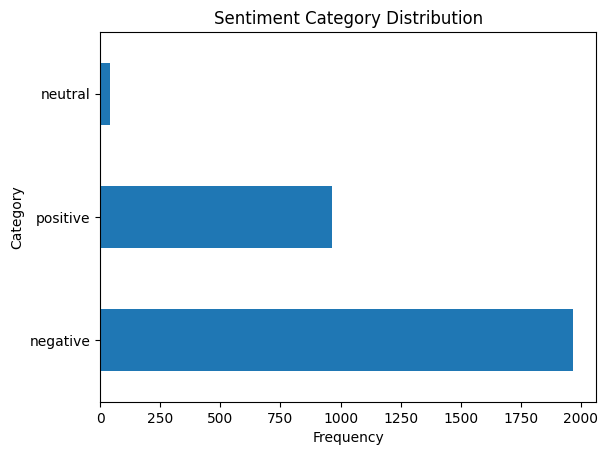

In [ ]:
unique_docs['sentiment_category'].value_counts().plot(kind='barh')
plt.title('Sentiment Category Distribution')
plt.xlabel('Frequency')
plt.ylabel('Category')
plt.show()

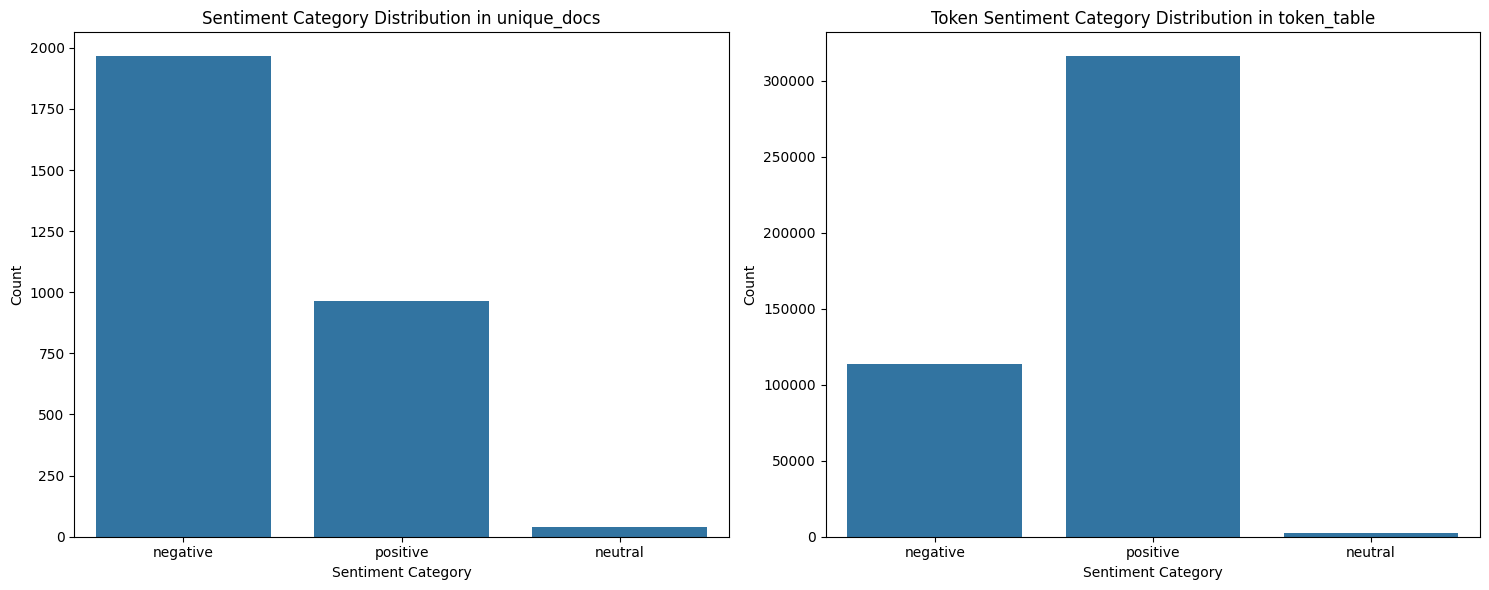

In [ ]:
import seaborn as sns

# Create a figure with 2 column subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Sentiment distribution in unique_docs
sns.countplot(data=unique_docs, x='sentiment_category', ax=axes[0])
axes[0].set_title('Sentiment Category Distribution in unique_docs')
axes[0].set_xlabel('Sentiment Category')
axes[0].set_ylabel('Count')

# Sentiment distribution in token_table
sns.countplot(data=token_table, x='sentiment_category', ax=axes[1])
axes[1].set_title('Token Sentiment Category Distribution in token_table')
axes[1].set_xlabel('Sentiment Category')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# F4

Reconstructs documents from tokens, calculating TFIDF scores for each term, merging these scores into the token_table, and aggregating average TFIDF values into the term_table for comprehensive term-level analysis.


Outputs:
- token_table: Includes tfidf column with the TF-IDF score for each token.
- term_table: Includes a new column, average_tfidf, showing mean TFIDF score for each term across documents

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: Reconstruct Documents from TOKEN Table
reconstructed_text = token_table.groupby('doc_id')['token_text'].apply(lambda tokens: ' '.join(tokens)).reset_index()
reconstructed_text = reconstructed_text.rename(columns={'token_text': 'reconstructed_text'})

reconstructed_text = reconstructed_text.merge(
    doc_table[['doc_id', 'sentiment_category']],
    on='doc_id',
    how='left'
)

# Step 2: Initialize and Fit TFIDF Vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(reconstructed_text['reconstructed_text'])
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=reconstructed_text['doc_id'], columns=feature_names)

# Step 3: Melt TFIDF DataFrame for Merging
tfidf_melted = tfidf_df.reset_index().melt(id_vars='doc_id', var_name='term_text', value_name='tfidf')

# Step 4: Merge TFIDF Scores with TOKEN Table
token_table = token_table.merge(
    tfidf_melted,
    left_on=['doc_id', 'token_text'],
    right_on=['doc_id', 'term_text'],
    how='left'
)

# Step 5: Fill NaN TFIDF with 0 and Drop Redundant Column
token_table['tfidf'] = token_table['tfidf'].fillna(0)
token_table.drop('term_text', axis=1, inplace=True)

# Add Average TFIDF to TERM Table (optional)
average_tfidf = token_table.groupby('term_id')['tfidf'].mean().reset_index()
average_tfidf = average_tfidf.rename(columns={'tfidf': 'average_tfidf'})
term_table = term_table.merge(average_tfidf, on='term_id', how='left')
term_table['average_tfidf'] = term_table['average_tfidf'].fillna(0)

In [ ]:
tfidf_df.head(1)

008y36  00am  00am00am  00am00pm  00amsunday  00pm  00pm00pmwhere  \
doc_id                                                                      
1          0.0   0.0       0.0       0.0         0.0   0.0            0.0   

        00pmthe  01138ch  0122hrs  ...  zodiac  zone  zooma  zoya   zu  \
doc_id                             ...                                   
1           0.0      0.0      0.0  ...     0.0   0.0    0.0   0.0  0.0   

        zuckerman  zuma  zx636  zx6r  zydeco  
doc_id                                        
1             0.0   0.0    0.0   0.0     0.0  

[1 rows x 8469 columns]

In [ ]:
doc_table.head(1)

doc_id               document_id          section  \
0       1  6755cb5d93a273b79e58426d  Incident Report   

                                       mdu_id   incident_id incident_date  \
0  6755cb5d93a273b79e58426d-Incident Report-1  202400025855    2024-12-05   

  report_date                                               link  \
0  2024-12-06  https://www.annapolis.gov/CivicSend/ViewMessag...   

   sentiment_compound  sentiment_pos  sentiment_neu  sentiment_neg  negative  \
0             -0.9146          0.072          0.827          0.101        16   

   positive                                           entities  \
0        35  [(francis noel, PERSON), (24on, DATE), (7locku...   

  sentiment_category  
0           negative

In [ ]:
token_table.head()

token_id  doc_id   incident_id  position  term_id token_text  \
0         1       1  202400025855         1        1   domestic   
1         2       1  202400025855         2        2    assault   
2         3       1  202400025855         3        3    francis   
3         4       1  202400025855         4        4       noel   
4         5       1  202400025855         5        5        way   

   sentiment_score sentiment_category     tfidf  
0          -0.9146           negative  0.225271  
1          -0.9146           negative  0.133102  
2          -0.9146           negative  0.104765  
3          -0.9146           negative  0.131220  
4          -0.9146           negative  0.085194

In [ ]:
term_table.head()

term_id term_text  document_frequency  collection_frequency  negative_freq  \
0        1  domestic                  18                    23             22   
1        2   assault                 225                   337            300   
2        3   francis                  28                    32             12   
3        4      noel                   6                    10              8   
4        5       way                  82                    99             40   

   neutral_freq  positive_freq  average_tfidf  
0             0              1       0.166215  
1             1             36       0.151244  
2             0             20       0.120350  
3             0              2       0.230270  
4             1             58       0.116271

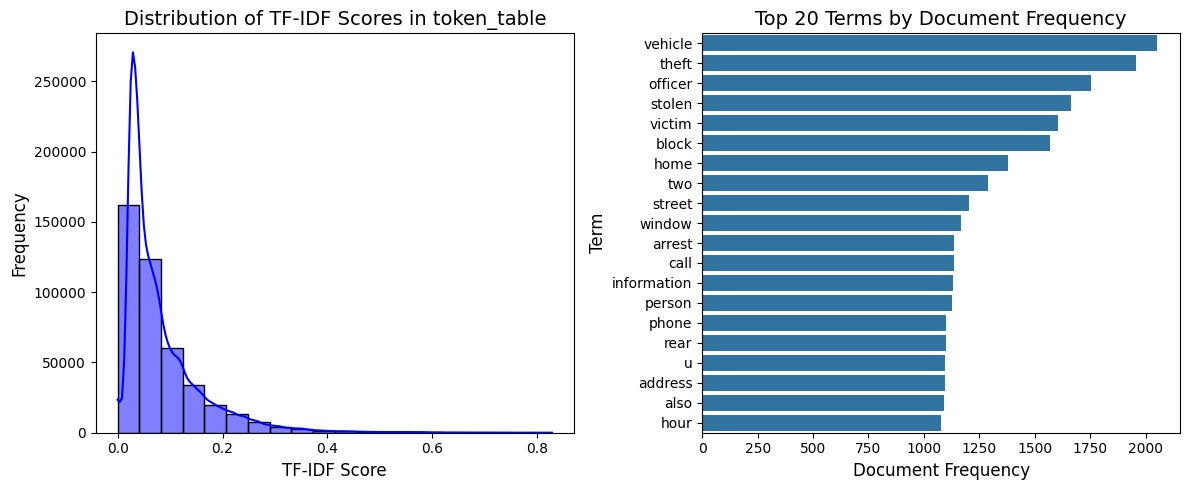

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Distribution of TF-IDF scores in token_table
sns.histplot(token_table['tfidf'], bins=20, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of TF-IDF Scores in token_table', fontsize=14)
axes[0].set_xlabel('TF-IDF Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Plot 2: Top 20 terms by document_frequency in term_table
top_terms_by_doc_freq = term_table.sort_values(by='document_frequency', ascending=False).head(20)
sns.barplot(data=top_terms_by_doc_freq, x='document_frequency', y='term_text', ax=axes[1])
axes[1].set_title('Top 20 Terms by Document Frequency', fontsize=14)
axes[1].set_xlabel('Document Frequency', fontsize=12)
axes[1].set_ylabel('Term', fontsize=12)

plt.tight_layout()
plt.show()

# F5

### PCA

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA on the TFIDF matrix
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# Add PCA results to the reconstructed_text DataFrame
reconstructed_text['PCA_1'] = pca_result[:, 0]
reconstructed_text['PCA_2'] = pca_result[:, 1]

c:\Users\bengb\AppData\Local\Programs\Python\Python310\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


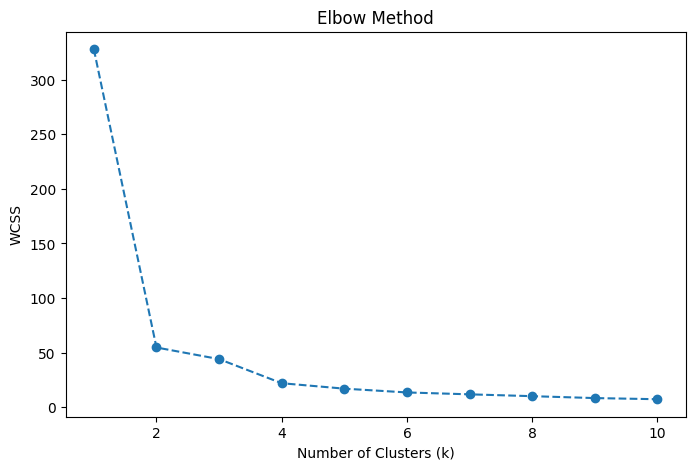

In [ ]:
from sklearn.cluster import KMeans

wcss = []
for k in range(1, 11):  # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_result)  # Assuming PCA data
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

2 or 3

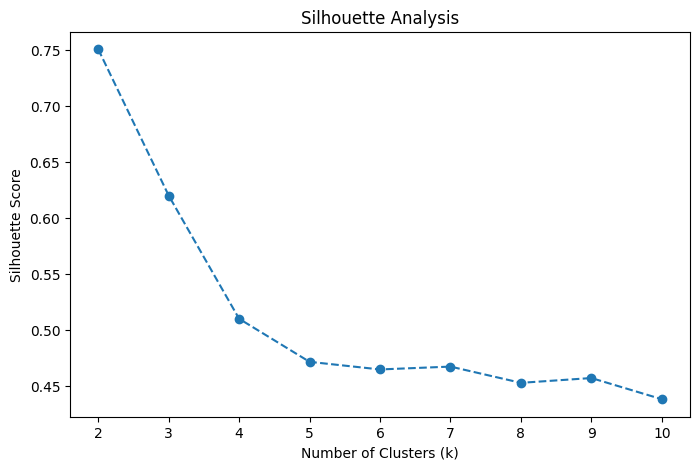

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):  # Silhouette requires at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pca_result)
    silhouette_scores.append(silhouette_score(pca_result, labels))

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Analysis')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

~3 clusters

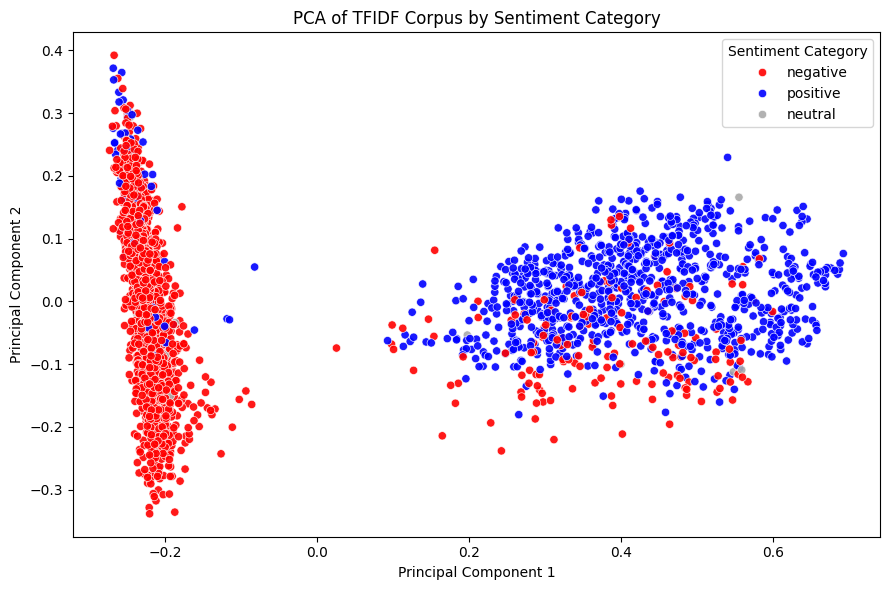

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA on the TFIDF matrix
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# Add PCA results to the reconstructed_text DataFrame
reconstructed_text['PCA_1'] = pca_result[:, 0]
reconstructed_text['PCA_2'] = pca_result[:, 1]

# Merge sentiment_category into reconstructed_text only if it doesn't already exist
if 'sentiment_category' not in reconstructed_text.columns:
    reconstructed_text = reconstructed_text.merge(
        doc_table[['doc_id', 'sentiment_category']],
        on='doc_id',
        how='left'
    )

# Define a custom color palette
custom_palette = {
    'negative': 'red',
    'positive': 'blue',
    'neutral': 'darkgrey'
}

# Plot PCA with sentiment_category as hue
plt.figure(figsize=(9, 6))
sns.scatterplot(
    x='PCA_1', y='PCA_2',
    data=reconstructed_text,
    hue='sentiment_category',  # Color points by sentiment category
    palette=custom_palette,  # Use the custom color palette
    alpha=0.9
)
plt.title('PCA of TFIDF Corpus by Sentiment Category')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Sentiment Category', loc='upper right')
plt.tight_layout()
plt.show()

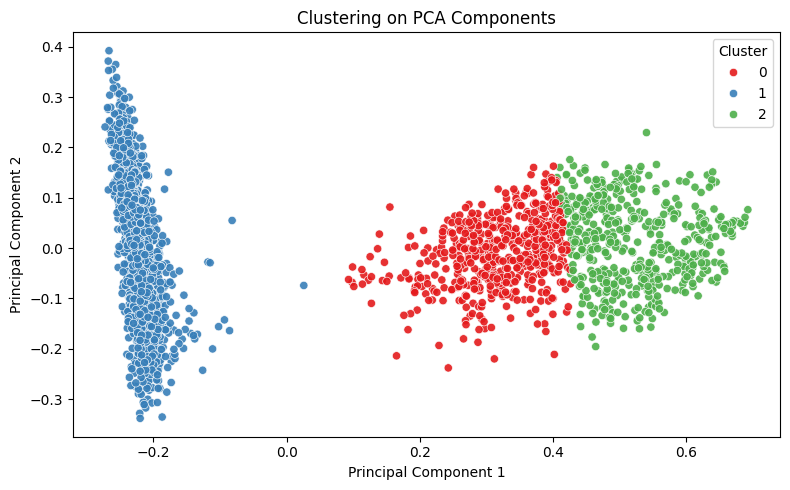

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
reconstructed_text['cluster'] = kmeans.fit_predict(pca_result)

# Plot clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x='PCA_1', y='PCA_2',
    data=reconstructed_text,
    hue='cluster',
    palette='Set1',
    alpha=0.9
)
plt.title('Clustering on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.tight_layout()
plt.show()

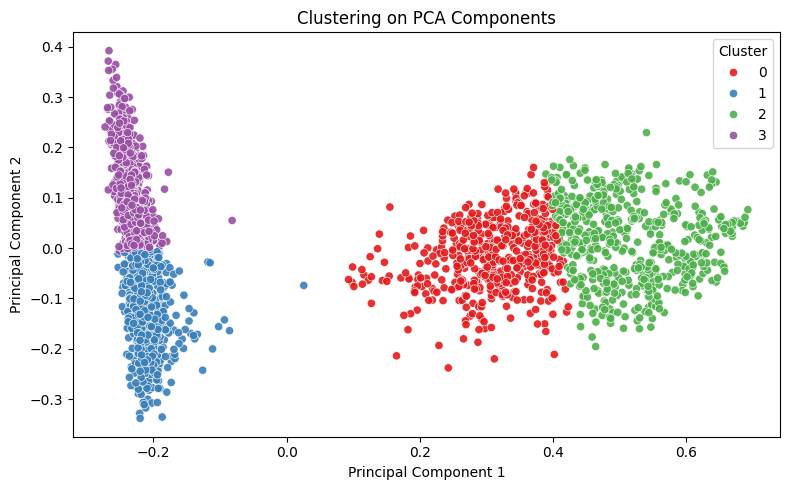

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
reconstructed_text['cluster'] = kmeans.fit_predict(pca_result)

# Plot clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x='PCA_1', y='PCA_2',
    data=reconstructed_text,
    hue='cluster',
    palette='Set1',
    alpha=0.9
)
plt.title('Clustering on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.tight_layout()
plt.show()

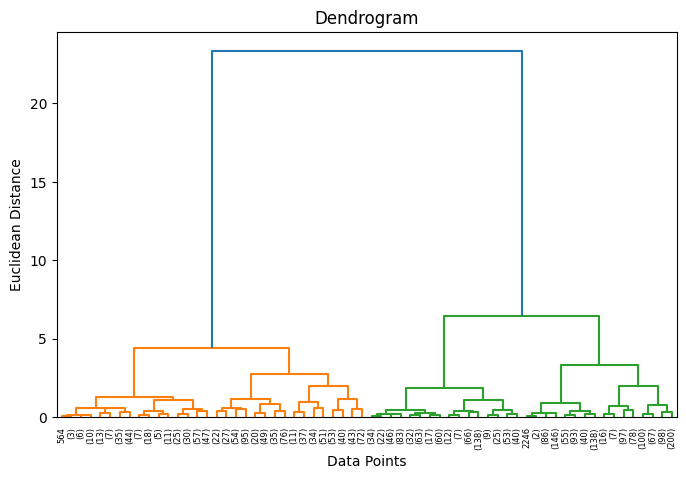

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# scipy.cluster.hierarchy.dendrogram()

# Perform hierarchical clustering
linked = linkage(pca_result, method='ward')

plt.figure(figsize=(8, 5))
dendrogram(linked, truncate_mode='level', p=5)  # Adjust `p` to zoom in/out
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.show()

3 clusters

In [ ]:
# Tag clusters back to the original doc_table
doc_table = doc_table.merge(
    reconstructed_text[['doc_id', 'cluster']],
    on='doc_id',
    how='left'
)

doc_table.head(2)

doc_id               document_id          section  \
0       1  6755cb5d93a273b79e58426d  Incident Report   
1       2  6755cb5d93a273b79e58426e  Incident Report   

                                       mdu_id   incident_id incident_date  \
0  6755cb5d93a273b79e58426d-Incident Report-1  202400025855    2024-12-05   
1  6755cb5d93a273b79e58426e-Incident Report-1  202400025813    2024-12-04   

  report_date                                               link  \
0  2024-12-06  https://www.annapolis.gov/CivicSend/ViewMessag...   
1  2024-12-05  https://www.annapolis.gov/CivicSend/ViewMessag...   

   sentiment_compound  sentiment_pos  sentiment_neu  sentiment_neg  negative  \
0             -0.9146          0.072          0.827          0.101        16   
1              0.1779          0.065          0.889          0.046         2   

   positive                                           entities  \
0        35  [(francis noel, PERSON), (24on, DATE), (7locku...   
1         1  [(24the, CARDINAL), (n ruth, PRODUCT), (overni...   

  sentiment_category  cluster  
0           negative        2  
1           positive        1

## LDA Today

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Create a CountVectorizer for LDA (raw term frequency)
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(reconstructed_text['reconstructed_text'])

# Get feature names (terms)
terms = count_vectorizer.get_feature_names_out()

# Initialize and fit the LDA model
n_topics = 5  # Define the number of topics
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(count_matrix)

# Get topic-term matrix
topic_term_matrix = lda_model.components_

# Get document-topic matrix
doc_topic_matrix = lda_model.transform(count_matrix)

# Create a DataFrame for document-topic concentrations
doc_topic_df = pd.DataFrame(
    doc_topic_matrix,
    columns=[f'Topic_{i}' for i in range(n_topics)],
    index=reconstructed_text['doc_id']
).reset_index()

# Rename columns
doc_topic_df = doc_topic_df.rename(columns={'index': 'doc_id'})

# Merge back with doc_table
doc_table = doc_table.merge(doc_topic_df, on='doc_id', how='left')
doc_table.head(1)

doc_id               document_id          section  \
0       1  6755cb5d93a273b79e58426d  Incident Report   

                                       mdu_id   incident_id incident_date  \
0  6755cb5d93a273b79e58426d-Incident Report-1  202400025855    2024-12-05   

  report_date                                               link  \
0  2024-12-06  https://www.annapolis.gov/CivicSend/ViewMessag...   

   sentiment_compound  sentiment_pos  ...  negative  positive  \
0             -0.9146          0.072  ...        16        35   

                                            entities  sentiment_category  \
0  [(francis noel, PERSON), (24on, DATE), (7locku...            negative   

  cluster   Topic_0   Topic_1   Topic_2   Topic_3   Topic_4  
0       2  0.000811  0.093971  0.903584  0.000825  0.000808  

[1 rows x 22 columns]

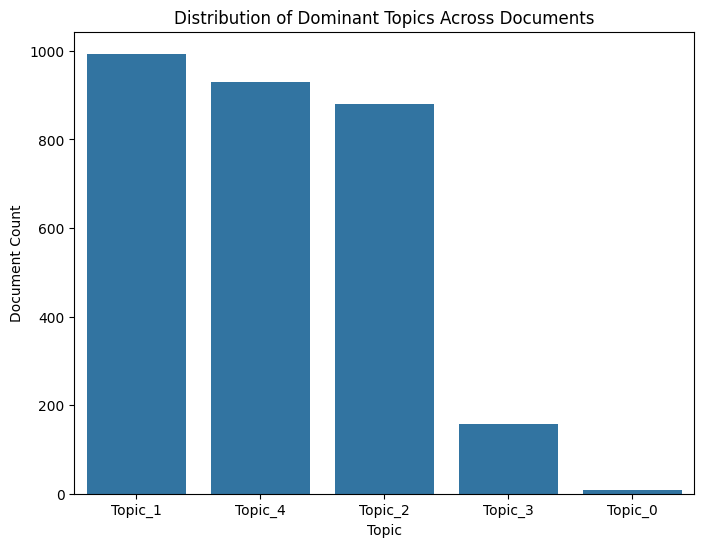

In [ ]:
# Get dominant topic for each document
doc_table['dominant_topic'] = doc_table[[f'Topic_{i}' for i in range(n_topics)]].idxmax(axis=1)

# Count the number of documents for each dominant topic
dominant_topic_counts = doc_table['dominant_topic'].value_counts().reset_index()
dominant_topic_counts.columns = ['Topic', 'Document Count']

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(data=dominant_topic_counts, x='Topic', y='Document Count')
plt.title('Distribution of Dominant Topics Across Documents')
plt.xlabel('Topic')
plt.ylabel('Document Count')
plt.show()

-- Dominant Topics Distribution Across Documents
- Observation: Topic_4 is the most prevalent, followed by Topic_0 and Topic_3, while Topic_1 and Topic_2 appear significantly less frequently. This indicates that a large proportion of the corpus is heavily skewed towards a few dominant topics.

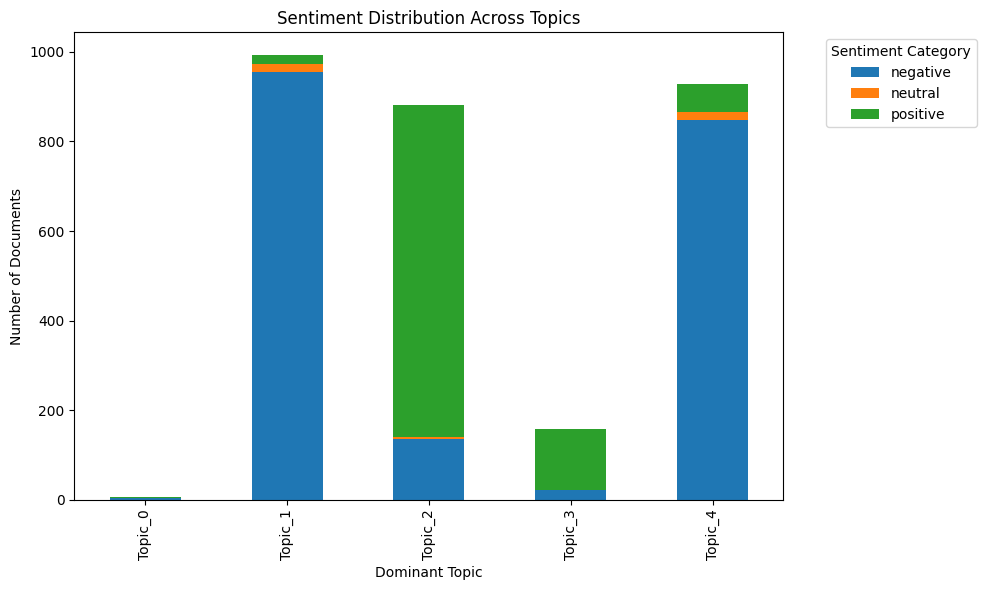

In [ ]:
# Group by dominant topic and sentiment category
sentiment_topic_counts = doc_table.groupby(['dominant_topic', 'sentiment_category']).size().unstack(fill_value=0)

# Plot stacked bar chart
sentiment_topic_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Distribution Across Topics')
plt.xlabel('Dominant Topic')
plt.ylabel('Number of Documents')
plt.legend(title='Sentiment Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Graphic 2: Sentiment Distribution Across Topics
- Observation: Topics show distinct sentiment distributions. Topic_0 has a high proportion of positive sentiment, while Topic_4 is dominated by negative sentiment. Topics like Topic_3 show a mix of sentiments, suggesting that sentiment is tied closely to certain thematic content.

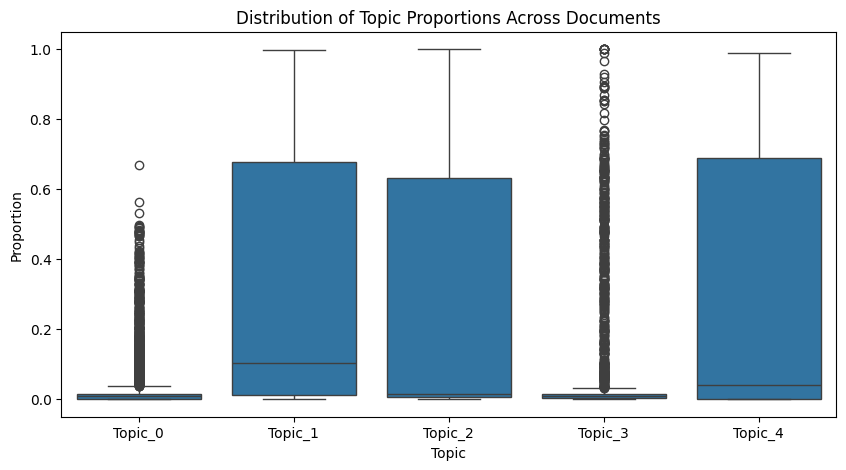

In [ ]:
# Melt document-topic proportions for a long-form DataFrame
topic_proportions = doc_table.melt(
    id_vars=['doc_id'], 
    value_vars=[f'Topic_{i}' for i in range(n_topics)], 
    var_name='Topic', 
    value_name='Proportion'
)

# Plot topic proportions
plt.figure(figsize=(10, 5))
sns.boxplot(data=topic_proportions, x='Topic', y='Proportion')
plt.title('Distribution of Topic Proportions Across Documents')
plt.xlabel('Topic')
plt.ylabel('Proportion')
plt.show()


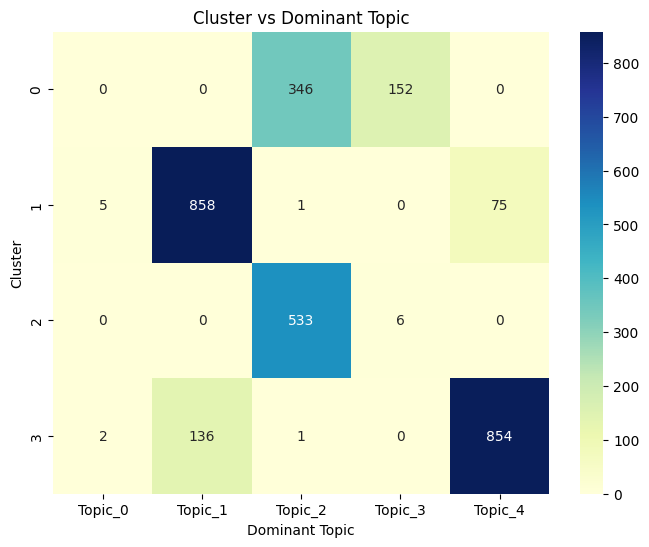

In [ ]:
# Group by cluster and dominant topic
cluster_topic_counts = doc_table.groupby(['cluster', 'dominant_topic']).size().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_topic_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Cluster vs Dominant Topic')
plt.xlabel('Dominant Topic')
plt.ylabel('Cluster')
plt.show()

Cluster vs. Dominant Topic Heatmap
- Observation: Certain clusters correlate strongly with specific topics. For instance, Cluster 1 is heavily associated with Topic_0, while Cluster 3 aligns with Topic_4. This suggests that clustering effectively segments documents based on their dominant topics.

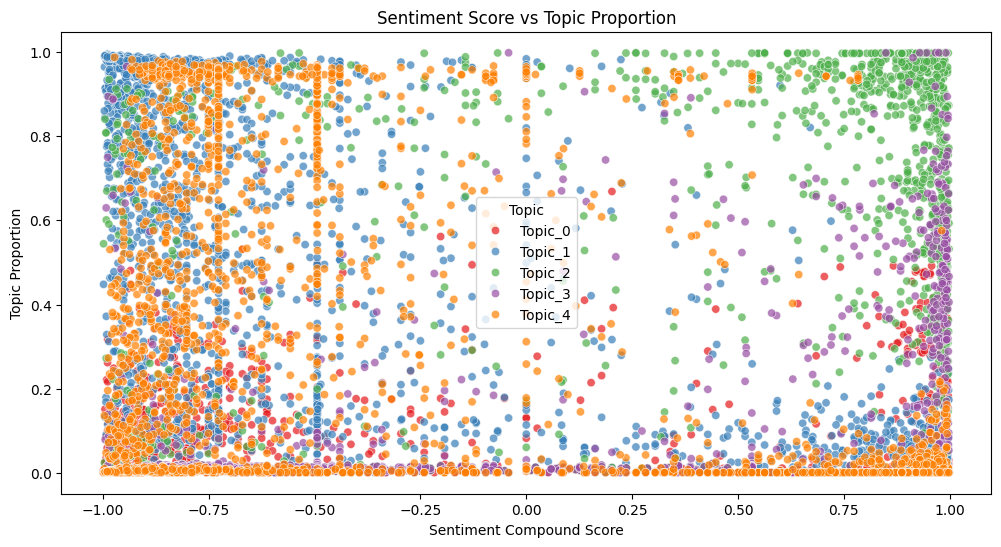

In [ ]:
# Melt topic proportions for long-form DataFrame
topic_sentiment = doc_table.melt(
    id_vars=['doc_id', 'sentiment_compound'], 
    value_vars=[f'Topic_{i}' for i in range(n_topics)], 
    var_name='Topic', 
    value_name='Proportion'
)

# Plot scatterplot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=topic_sentiment, 
    x='sentiment_compound', y='Proportion', 
    hue='Topic', palette='Set1', alpha=0.7
)
plt.title('Sentiment Score vs Topic Proportion')
plt.xlabel('Sentiment Compound Score')
plt.ylabel('Topic Proportion')
plt.legend(title='Topic')
plt.show()


Sentiment Score vs. Topic Proportion
- Observation: Topic proportions span the full range of sentiment scores. Certain topics (e.g., Topic_4) dominate in highly negative sentiment regions, while others (e.g., Topic_0) are more prevalent in positive regions. This plot reveals a clear relationship between topics and sentiment polarity.

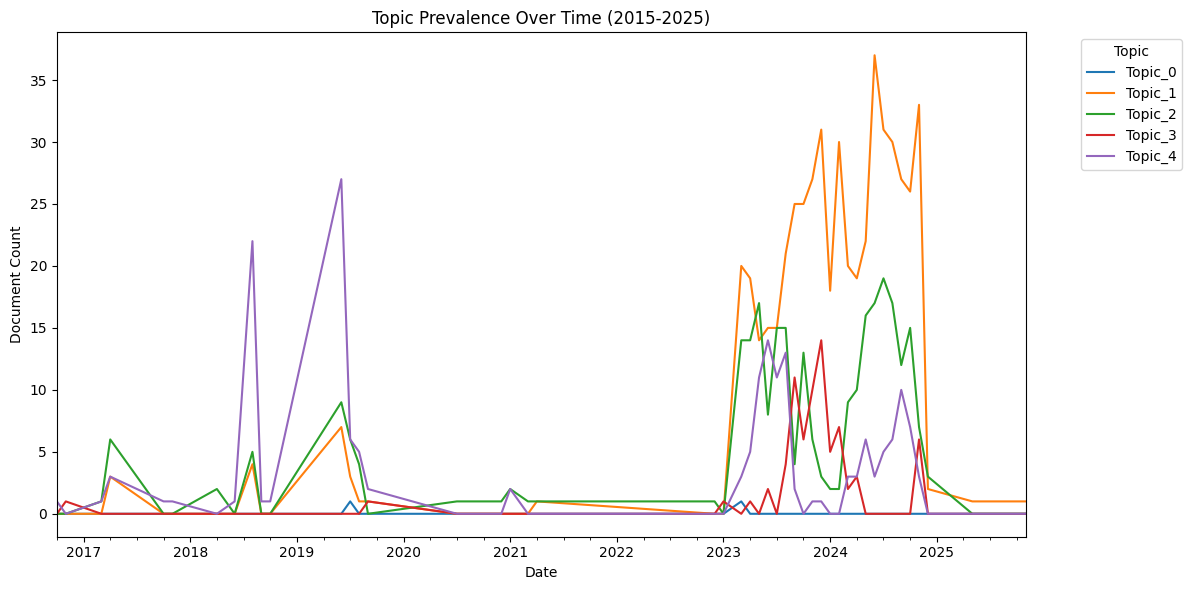

In [ ]:
# Convert incident_date to datetime if not already
doc_table['incident_date'] = pd.to_datetime(doc_table['incident_date'])

# Filter data to only include incident dates between 2015 and 2025
filtered_doc_table = doc_table[(doc_table['incident_date'].dt.year >= 2015) & (doc_table['incident_date'].dt.year <= 2025)]

# Group by date and dominant topic
time_topic_counts = filtered_doc_table.groupby([filtered_doc_table['incident_date'].dt.to_period('M'), 'dominant_topic']).size().unstack(fill_value=0)

time_topic_counts.plot(kind='line', figsize=(12, 6))
plt.title('Topic Prevalence Over Time (2015-2025)')
plt.xlabel('Date')
plt.ylabel('Document Count')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

 Topic Prevalence Over Time
- Observation: The prevalence of topics shifts significantly over time. For instance, Topic_0 and Topic_3 spike in specific years, indicating bursts of thematic relevance. Topic_4 shows steady dominance across multiple time periods, suggesting it represents an ongoing theme or issue.

### Term Table

In [ ]:
# Create a DataFrame for topic-term distributions
topic_term_df = pd.DataFrame(
    topic_term_matrix,
    columns=terms,
    index=[f'Topic_{i}' for i in range(n_topics)]
)

# For each topic, get the top terms
top_terms_per_topic = {}
for topic_idx, topic_terms in enumerate(topic_term_matrix):
    top_terms = [(terms[i], topic_terms[i]) for i in topic_terms.argsort()[:-11:-1]]  # Top 10 terms
    top_terms_per_topic[f'Topic_{topic_idx}'] = top_terms

# Convert to DataFrame
top_terms_df = pd.DataFrame([
    {'Topic': topic, 'Term': term, 'Weight': weight}
    for topic, terms in top_terms_per_topic.items()
    for term, weight in terms
])

top_terms_df.head()

Topic       Term      Weight
0  Topic_0       call  563.910144
1  Topic_0      covid  332.198988
2  Topic_0  reporting  306.522575
3  Topic_0  telephone  253.883829
4  Topic_0     ticket  247.591866

In [ ]:
# Create a DataFrame for topic-term distributions
topic_term_df = pd.DataFrame(
    topic_term_matrix,
    columns=terms,
    index=[f'Topic_{i}' for i in range(n_topics)]
)

# For each topic, get the top terms
top_terms_per_topic = {}
for topic_idx, topic_terms in enumerate(topic_term_matrix):
    top_terms = [(terms[i], topic_terms[i]) for i in topic_terms.argsort()[:-11:-1]]  # Top 10 terms
    top_terms_per_topic[f'Topic_{topic_idx}'] = top_terms

# Convert to DataFrame
top_terms_df = pd.DataFrame([
    {'Topic': topic, 'Term': term, 'Weight': weight}
    for topic, terms in top_terms_per_topic.items()
    for term, weight in terms
])

top_terms_df.head()

Topic       Term      Weight
0  Topic_0       call  563.910144
1  Topic_0      covid  332.198988
2  Topic_0  reporting  306.522575
3  Topic_0  telephone  253.883829
4  Topic_0     ticket  247.591866

In [ ]:
# Calculate topic frequency for terms
term_topic_freq = topic_term_df.sum(axis=0).reset_index()
term_topic_freq.columns = ['term_text', 'topic_frequency']

# Merge with the VOCAB table
term_table = term_table.merge(term_topic_freq, on='term_text', how='left')

# Fill NaN with 0 for terms not associated with topics
term_table['topic_frequency'] = term_table['topic_frequency'].fillna(0)
term_table.head()

term_id term_text  document_frequency  collection_frequency  negative_freq  \
0        1  domestic                  18                    23             22   
1        2   assault                 225                   337            300   
2        3   francis                  28                    32             12   
3        4      noel                   6                    10              8   
4        5       way                  82                    99             40   

   neutral_freq  positive_freq  average_tfidf  topic_frequency  
0             0              1       0.166215             24.0  
1             1             36       0.151244            338.0  
2             0             20       0.120350             33.0  
3             0              2       0.230270             11.0  
4             1             58       0.116271            100.0

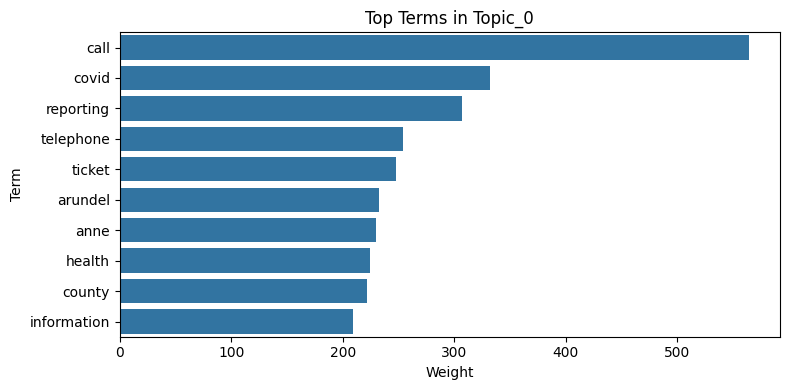

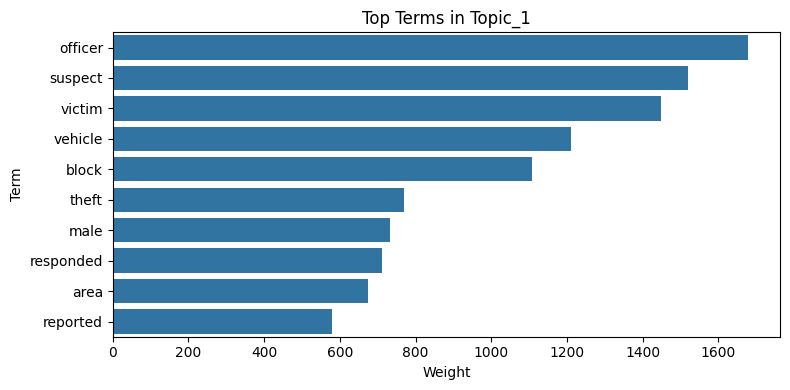

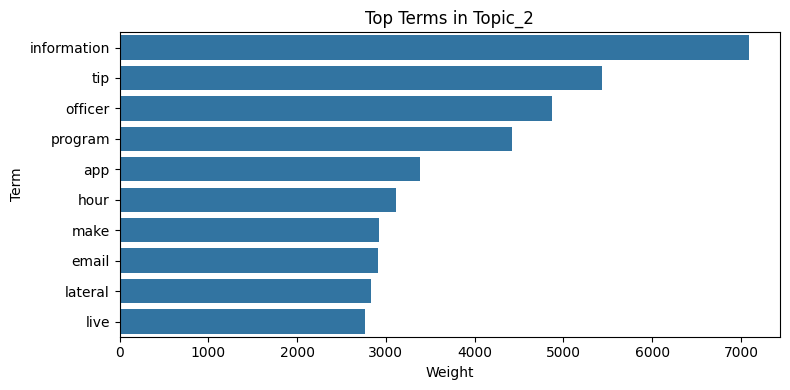

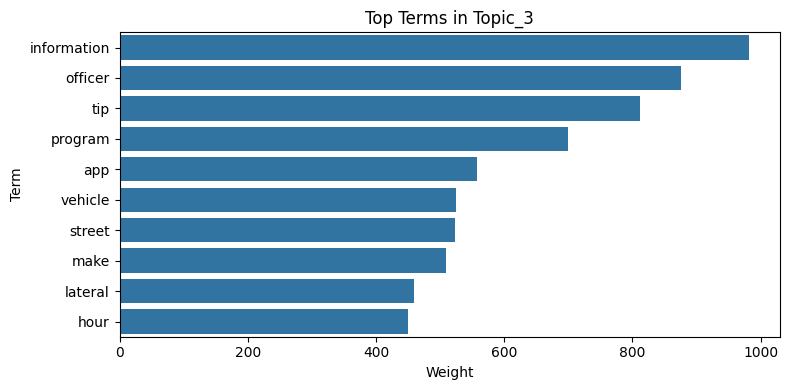

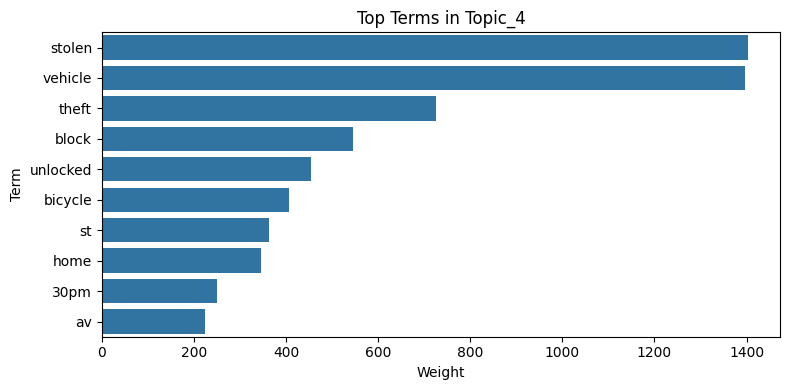

In [ ]:
# Visualize top terms per topic
for topic in top_terms_df['Topic'].unique():
    plt.figure(figsize=(8, 4))
    subset = top_terms_df[top_terms_df['Topic'] == topic]
    sns.barplot(data=subset, x='Weight', y='Term')
    plt.title(f"Top Terms in {topic}")
    plt.xlabel("Weight")
    plt.ylabel("Term")
    plt.tight_layout()
    plt.show()

In [ ]:
# Normalize doc_topic_matrix to get proportions
doc_topic_normalized = (doc_topic_matrix.T / doc_topic_matrix.sum(axis=1)).T

# Add topic proportions to doc_table
for i in range(n_topics):
    doc_table[f'Topic_{i}_proportion'] = doc_topic_normalized[:, i]

# Example: Check the first few documents
doc_table[['doc_id'] + [f'Topic_{i}_proportion' for i in range(n_topics)]].head()

doc_id  Topic_0_proportion  Topic_1_proportion  Topic_2_proportion  \
0       1            0.000811            0.093971            0.903584   
1       2            0.008356            0.965928            0.008364   
2       3            0.009821            0.715334            0.009587   
3       4            0.000833            0.058119            0.939378   
4       5            0.000795            0.038969            0.928517   

   Topic_3_proportion  Topic_4_proportion  
0            0.000825            0.000808  
1            0.008679            0.008673  
2            0.009995            0.255263  
3            0.000840            0.000829  
4            0.000806            0.030913

In [ ]:
# Get top topic for each document
doc_table['dominant_topic'] = doc_topic_matrix.argmax(axis=1)

# Example: Documents most associated with Topic_0
topic_0_docs = doc_table[doc_table['dominant_topic'] == 0]
topic_0_docs.head()

doc_id               document_id          section  \
828      829  6755cb5d93a273b79e58441a  Incident Report   
1007    1008  6755cb5d93a273b79e5846ad  Incident Report   
1176    1177  6755cb5d93a273b79e58471d  Incident Report   
1264    1265  6755cb5d93a273b79e584746  Incident Report   
1265    1266  6755cb5d93a273b79e584746  Incident Report   

                                          mdu_id   incident_id incident_date  \
828   6755cb5d93a273b79e58441a-Incident Report-6  202300014710    2023-03-17   
1007  6755cb5d93a273b79e5846ad-Incident Report-8  202000002590           NaT   
1176  6755cb5d93a273b79e58471d-Incident Report-1  202000000264           NaT   
1264  6755cb5d93a273b79e584746-Incident Report-1  202000000093           NaT   
1265  6755cb5d93a273b79e584746-Incident Report-2  202000000111           NaT   

     report_date                                               link  \
828   2023-06-09  https://www.annapolis.gov/CivicSend/ViewMessag...   
1007  2020-07-06  https://www.annapolis.gov/CivicSend/ViewMessag...   
1176  2020-03-02  https://www.annapolis.gov/CivicSend/ViewMessag...   
1264  2020-01-08  https://www.annapolis.gov/CivicSend/ViewMessag...   
1265  2020-01-08  https://www.annapolis.gov/CivicSend/ViewMessag...   

      sentiment_compound  sentiment_pos  ...   Topic_1   Topic_2   Topic_3  \
828              -0.9413          0.000  ...  0.246323  0.004950  0.004956   
1007             -0.4939          0.000  ...  0.014893  0.014367  0.014879   
1176             -0.1280          0.110  ...  0.322780  0.007085  0.007062   
1264             -0.2023          0.044  ...  0.424534  0.004584  0.004649   
1265             -0.6705          0.033  ...  0.457874  0.003462  0.003576   

       Topic_4 dominant_topic Topic_0_proportion  Topic_1_proportion  \
828   0.306099              0           0.437671            0.246323   
1007  0.458504              0           0.497356            0.014893   
1176  0.168737              0           0.494336            0.322780   
1264  0.004755              0           0.561478            0.424534   
1265  0.003513              0           0.531576            0.457874   

      Topic_2_proportion  Topic_3_proportion  Topic_4_proportion  
828             0.004950            0.004956            0.306099  
1007            0.014367            0.014879            0.458504  
1176            0.007085            0.007062            0.168737  
1264            0.004584            0.004649            0.004755  
1265            0.003462            0.003576            0.003513  

[5 rows x 28 columns]

## LDA

Number of Topics: 2, Coherence Score: 0.4803
Number of Topics: 3, Coherence Score: 0.4766
Number of Topics: 4, Coherence Score: 0.4935
Number of Topics: 5, Coherence Score: 0.5381
Number of Topics: 6, Coherence Score: 0.5961
Number of Topics: 7, Coherence Score: 0.6083
Number of Topics: 8, Coherence Score: 0.5476
Number of Topics: 9, Coherence Score: 0.5774
Number of Topics: 10, Coherence Score: 0.5491
Number of Topics: 11, Coherence Score: 0.5412
Number of Topics: 12, Coherence Score: 0.5504
Number of Topics: 13, Coherence Score: 0.5827
Number of Topics: 14, Coherence Score: 0.5416
Number of Topics: 15, Coherence Score: 0.5278


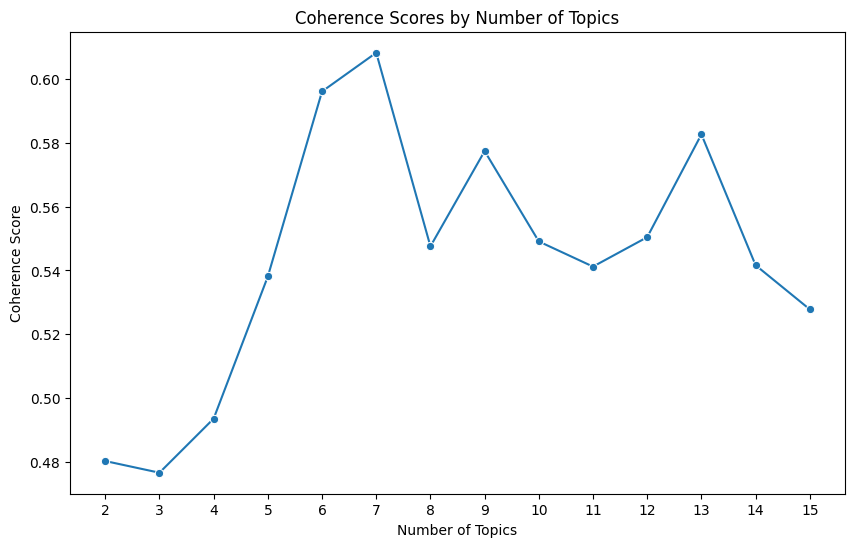

Optimal number of topics: 7


In [ ]:
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import spacy

# Initialize spaCy
nlp = spacy.load('en_core_web_sm')

# Define stopwords and punctuations (if not already defined)
stop_words = set(nltk.corpus.stopwords.words('english'))

# Apply preprocessing
reconstructed_text['processed_text'] = reconstructed_text['reconstructed_text'].apply(preprocess_for_lda)

# Create Gensim Dictionary and Corpus
dictionary = corpora.Dictionary(reconstructed_text['processed_text'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in reconstructed_text['processed_text']]

# Determine Optimal Number of Topics using Coherence Scores
coherence_scores = []
topic_range = range(2, 16)

for num in topic_range:
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num,
                         random_state=42,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    coherence_model = CoherenceModel(model=lda_model, texts=reconstructed_text['processed_text'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    print(f"Number of Topics: {num}, Coherence Score: {coherence_score:.4f}")

# Plot Coherence Scores
plt.figure(figsize=(10,6))
sns.lineplot(x=list(topic_range), y=coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores by Number of Topics')
plt.xticks(list(topic_range))
plt.show()

# Select the number of topics with the highest coherence score
optimal_num_topics = topic_range[np.argmax(coherence_scores)]
print(f"Optimal number of topics: {optimal_num_topics}")

In [ ]:
optimal_num_topics = 6  # As per your analysis

final_lda_model = LdaModel(corpus=corpus,
                           id2word=dictionary,
                           num_topics=optimal_num_topics,
                           random_state=42,
                           update_every=1,
                           chunksize=100,
                           passes=20,        # Increased passes for better convergence
                           iterations=400,   # Increased iterations
                           alpha='symmetric',  # Experiment with 'symmetric', 'asymmetric', or specific values
                           eta='auto',
                           per_word_topics=True)


In [ ]:
def display_topics(model, num_words=10):
    for idx, topic in model.print_topics(-1, num_words=num_words):
        print(f"Topic {idx + 1}: {topic}\n")

display_topics(final_lda_model, num_words=10)

Topic 1: 0.035*"information" + 0.026*"tip" + 0.021*"program" + 0.021*"u" + 0.015*"hour" + 0.015*"email" + 0.015*"make" + 0.013*"live" + 0.013*"job" + 0.013*"share"

Topic 2: 0.021*"eastport" + 0.017*"event" + 0.017*"work" + 0.016*"resident" + 0.016*"available" + 0.016*"free" + 0.016*"pm" + 0.016*"citizen" + 0.015*"monday" + 0.015*"food"

Topic 3: 0.044*"suspect" + 0.025*"home" + 0.022*"st" + 0.020*"pm" + 0.019*"area" + 0.018*"unlocked" + 0.018*"open" + 0.018*"locate" + 0.016*"text" + 0.014*"door"

Topic 4: 0.032*"information" + 0.031*"call" + 0.026*"county" + 0.023*"arundel" + 0.023*"anne" + 0.021*"scholarship" + 0.019*"pm" + 0.017*"please" + 0.017*"detective" + 0.017*"public"

Topic 5: 0.025*"male" + 0.023*"handgun" + 0.022*"one" + 0.021*"juvenile" + 0.018*"old" + 0.018*"year" + 0.016*"get" + 0.015*"leave" + 0.014*"degree" + 0.014*"foot"

Topic 6: 0.043*"pm" + 0.036*"attend" + 0.034*"bicycle" + 0.029*"inside" + 0.021*"fire" + 0.020*"follow" + 0.018*"st" + 0.018*"dr" + 0.017*"shot" + 0

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(final_lda_model, corpus, dictionary)
#pyLDAvis.display(vis)

# To save the visualization
#pyLDAvis.save_html(vis, 'lda_visualization.html')

## LDA Bigrams

Training bigram and trigram models...
Applying bigrams...
Applying trigrams...
Creating Gensim dictionary...
Creating Gensim corpus...
Calculating coherence scores for different numbers of topics...


Topics:   8%|▊         | 1/12 [00:16<02:59, 16.31s/it]

Number of Topics: 2, Coherence Score: 0.4698


Topics:  17%|█▋        | 2/12 [00:33<02:47, 16.80s/it]

Number of Topics: 3, Coherence Score: 0.4896


Topics:  25%|██▌       | 3/12 [00:51<02:35, 17.26s/it]

Number of Topics: 4, Coherence Score: 0.5317


Topics:  33%|███▎      | 4/12 [01:08<02:18, 17.29s/it]

Number of Topics: 5, Coherence Score: 0.6091


Topics:  42%|████▏     | 5/12 [01:25<02:00, 17.24s/it]

Number of Topics: 6, Coherence Score: 0.6208


Topics:  50%|█████     | 6/12 [01:44<01:45, 17.60s/it]

Number of Topics: 7, Coherence Score: 0.5626


Topics:  58%|█████▊    | 7/12 [02:01<01:28, 17.63s/it]

Number of Topics: 8, Coherence Score: 0.5966


Topics:  67%|██████▋   | 8/12 [02:19<01:10, 17.71s/it]

Number of Topics: 9, Coherence Score: 0.5993


Topics:  75%|███████▌  | 9/12 [02:39<00:55, 18.39s/it]

Number of Topics: 10, Coherence Score: 0.5826


Topics:  83%|████████▎ | 10/12 [02:58<00:36, 18.43s/it]

Number of Topics: 11, Coherence Score: 0.5710


Topics:  92%|█████████▏| 11/12 [03:16<00:18, 18.48s/it]

Number of Topics: 12, Coherence Score: 0.5486


Topics: 100%|██████████| 12/12 [03:38<00:00, 18.17s/it]

Number of Topics: 13, Coherence Score: 0.4850


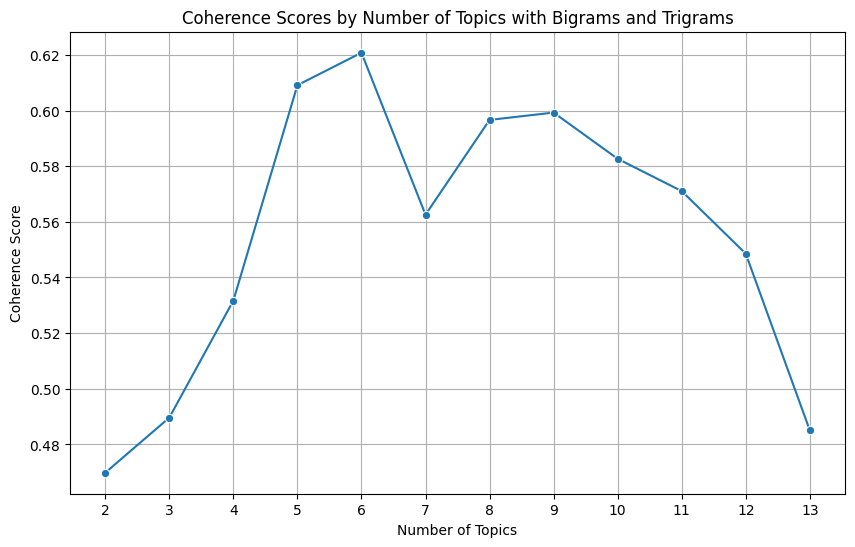

Optimal number of topics: 6
Topic 1: 0.026*"pm" + 0.025*"bicycle" + 0.025*"text" + 0.019*"leave" + 0.018*"av" + 0.016*"home" + 0.016*"window" + 0.015*"see" + 0.015*"burglary" + 0.015*"ct"

Topic 2: 0.041*"pm" + 0.033*"event" + 0.028*"avenue" + 0.027*"street" + 0.026*"park" + 0.016*"locate" + 0.014*"shot_fire" + 0.012*"city" + 0.012*"october" + 0.011*"national_night"

Topic 3: 0.043*"food" + 0.029*"man" + 0.018*"pm" + 0.016*"september" + 0.015*"donation" + 0.014*"remove" + 0.013*"item" + 0.013*"sign_force_entry" + 0.011*"taylor" + 0.010*"public"

Topic 4: 0.035*"information" + 0.025*"tip" + 0.021*"u" + 0.021*"program" + 0.015*"hour" + 0.014*"make" + 0.014*"email" + 0.013*"live" + 0.012*"job" + 0.012*"submit"

Topic 5: 0.056*"home" + 0.055*"pm" + 0.045*"unlocked" + 0.040*"resident" + 0.039*"eastport" + 0.038*"st" + 0.035*"monday" + 0.035*"open" + 0.030*"adult" + 0.019*"door"

Topic 6: 0.076*"suspect" + 0.036*"male" + 0.033*"area" + 0.028*"locate" + 0.024*"charge" + 0.021*"report" + 0.021

In [ ]:
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from tqdm import tqdm
import numpy as np

# Define preprocessing function (assumes initial preprocessing has been done)
def preprocess_for_lda(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and token.is_alpha]
    return tokens

# Apply preprocessing to 'reconstructed_text' DataFrame
reconstructed_text['processed_text'] = reconstructed_text['reconstructed_text'].apply(preprocess_for_lda)

# Convert processed_text to list for bigram/trigram modeling
processed_text = reconstructed_text['processed_text'].tolist()

# Build bigram and trigram models
print("Training bigram and trigram models...")
bigram = Phrases(processed_text, min_count=5, threshold=100)
trigram = Phrases(bigram[processed_text], threshold=100)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Function to apply bigrams and trigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Apply bigrams and trigrams to the processed_text
print("Applying bigrams...")
processed_text_bigrams = make_bigrams(processed_text)

print("Applying trigrams...")
processed_text_trigrams = make_trigrams(processed_text_bigrams)

# Update the 'processed_text' in 'reconstructed_text' DataFrame
reconstructed_text['processed_text'] = processed_text_trigrams

# Create Gensim Dictionary
print("Creating Gensim dictionary...")
dictionary = corpora.Dictionary(reconstructed_text['processed_text'])

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create Corpus: Bag-of-Words
print("Creating Gensim corpus...")
corpus = [dictionary.doc2bow(text) for text in reconstructed_text['processed_text']]

# Determine Optimal Number of Topics using Coherence Scores
coherence_scores = []
topic_range = range(2, 14)

print("Calculating coherence scores for different numbers of topics...")
for num in tqdm(topic_range, desc="Topics"):
    # Initialize LDA model
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num,
                         random_state=42,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    
    # Calculate Coherence Score using 'c_v' metric
    coherence_model = CoherenceModel(model=lda_model, texts=reconstructed_text['processed_text'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    
    print(f"Number of Topics: {num}, Coherence Score: {coherence_score:.4f}")

# Plot Coherence Scores
plt.figure(figsize=(10,6))
sns.lineplot(x=list(topic_range), y=coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores by Number of Topics with Bigrams and Trigrams')
plt.xticks(list(topic_range))
plt.grid(True)
plt.show()

# Select the number of topics with the highest coherence score
optimal_num_topics = topic_range[np.argmax(coherence_scores)]
print(f"Optimal number of topics: {optimal_num_topics}")

# Train the final LDA model with optimal number of topics
final_lda_model = LdaModel(corpus=corpus,
                           id2word=dictionary,
                           num_topics=optimal_num_topics,
                           random_state=42,
                           update_every=1,
                           chunksize=100,
                           passes=20,        # Increased passes for better convergence
                           iterations=400,   # Increased iterations
                           alpha='symmetric',  # Experiment with 'symmetric', 'asymmetric', or specific values
                           eta='auto',
                           per_word_topics=True)

# Save the final LDA model
final_lda_model.save("final_lda_model_with_bigrams_trigrams.model")

# Display the topics
def display_topics(model, num_words=10):
    for idx, topic in model.print_topics(-1, num_words=num_words):
        print(f"Topic {idx + 1}: {topic}\n")

display_topics(final_lda_model, num_words=10)

# Visualize the topics with pyLDAvis
vis = gensimvis.prepare(final_lda_model, corpus, dictionary)
pyLDAvis.display(vis)

# Integrate topic distributions into doc_table
print("Extracting topic distributions...")
topic_distributions = final_lda_model.get_document_topics(corpus, minimum_probability=0.0)

# Convert topic distributions to a DataFrame
topic_df = pd.DataFrame(topic_distributions)
topic_df = topic_df.apply(lambda row: dict(row), axis=1)
topic_df = pd.json_normalize(topic_df)
topic_df.columns = [f"LDA_topic_{i+1}" for i in range(optimal_num_topics)]

# Combine with reconstructed_text DataFrame
reconstructed_text = pd.concat([reconstructed_text, topic_df], axis=1)

# Merge with doc_table
doc_table = doc_table.merge(reconstructed_text[['doc_id'] + [f"LDA_topic_{i+1}" for i in range(optimal_num_topics)]], on='doc_id', how='left')

# Save the updated DOC table with LDA topics
doc_table.to_csv('DOC_LDA_with_bigrams_trigrams.csv', index=False)
print("LDA topics successfully integrated into DOC table and saved as 'DOC_LDA_with_bigrams_trigrams.csv'.")

# Pick Up Here Friday

## Word 2 vec

In [ ]:
print("Term table columns:", term_table.columns.tolist())

Term table columns: ['term_id', 'term_text', 'document_frequency', 'collection_frequency', 'sentiment_score_x', 'negative_emotion', 'positive_emotion', 'pos_tag', 'named_entity', 'sentiment_score_y']


In [ ]:
term_table.head()

term_id   term_text  document_frequency  collection_frequency  \
0        1  theftfraud                   4                     4   
1        2       block                1507                  2046   
2        3    margaret                   4                     4   
3        4         ave                 135                   157   
4        5    24victim                  53                    54   

   sentiment_score_x  negative_emotion  positive_emotion pos_tag named_entity  \
0           0.155250                34                48      NN            O   
1           0.159719             23141             36348      NN            O   
2           0.172750                54                82      NN            O   
3           0.123376              1878              3100     VBP            O   
4           0.147889               417               578      CD            O   

   sentiment_score_y  
0          -0.381075  
1          -0.334984  
2          -0.427075  
3          -0.202346  
4          -0.350824

In [ ]:
print("Term table columns:", doc_table.columns.tolist())

Term table columns: ['doc_id', 'document_id', 'section', 'mdu_id', 'incident_id', 'incident_date', 'report_date', 'source_url', 'sentiment_compound', 'sentiment_pos', 'sentiment_neu', 'sentiment_neg', 'negative_emotion', 'positive_emotion']


In [ ]:
doc_table.head(1)

doc_id               document_id          section  \
0       1  66f0d1df263e89bdcfb782bf  Incident Report   

                                       mdu_id   incident_id incident_date  \
0  66f0d1df263e89bdcfb782bf-Incident Report-1  202400019815    2024-09-19   

  report_date                                         source_url  \
0        None  https://www.annapolis.gov/CivicSend/ViewMessag...   

   sentiment_compound  sentiment_pos  sentiment_neu  sentiment_neg  \
0               0.249          0.751            0.0        -0.8225   

   negative_emotion  positive_emotion  
0                 3                 0

### Some More Sentiment Stuff

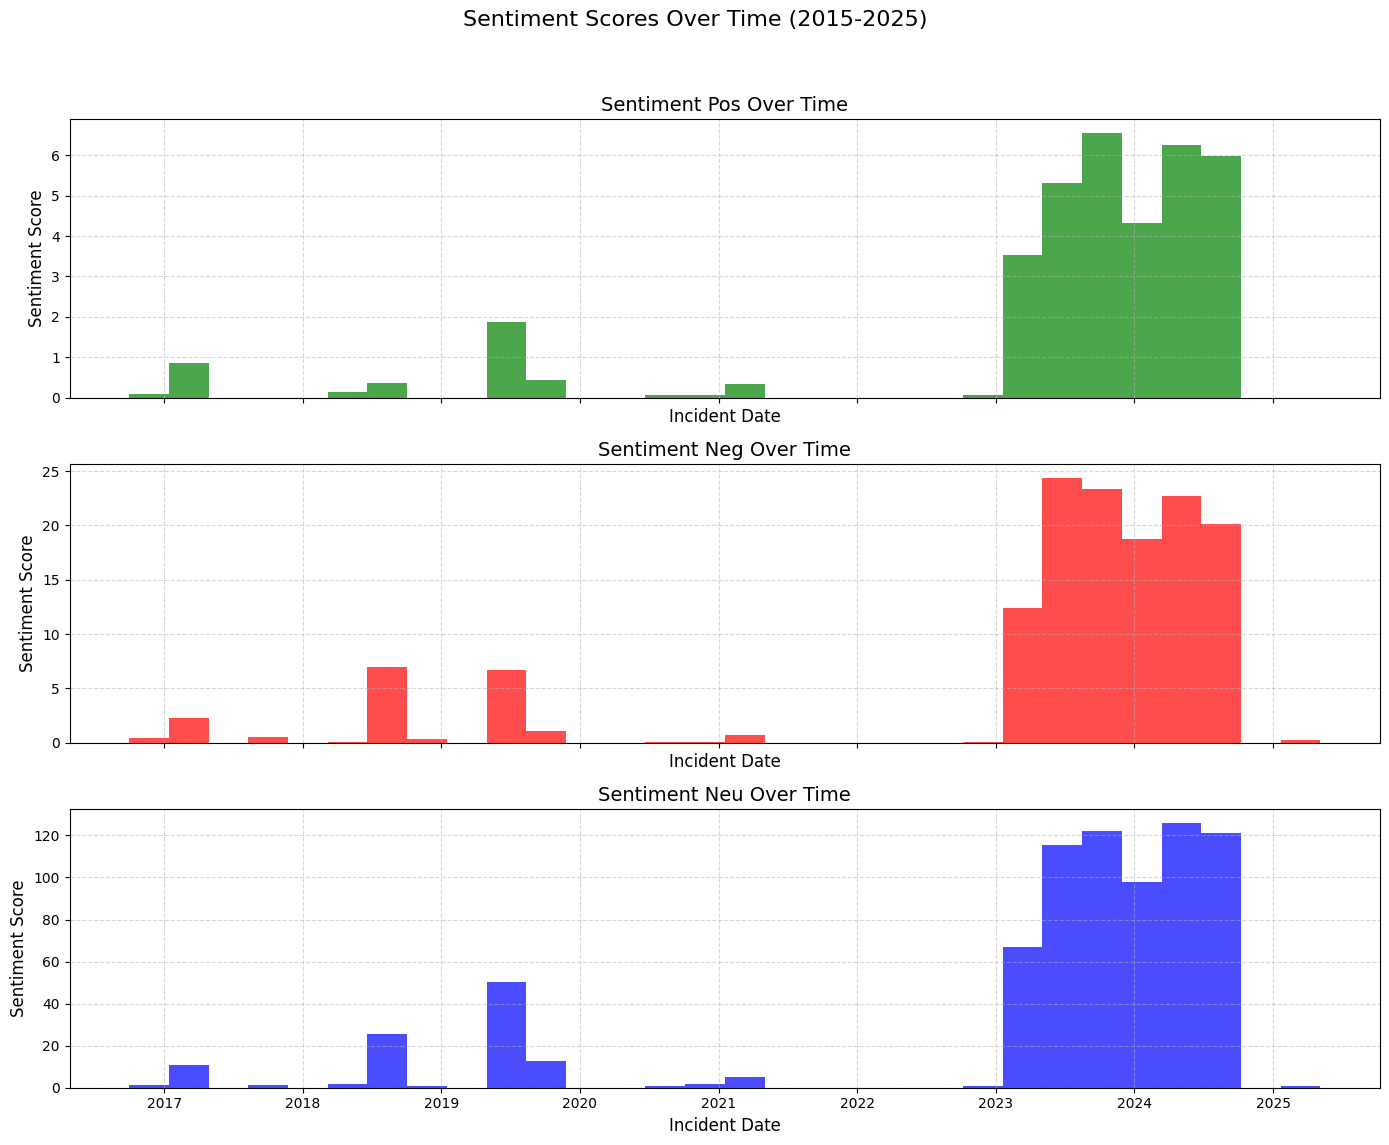

In [ ]:
# Define date range
start_date = datetime(2015, 1, 1)
end_date = datetime(2025, 12, 31)

# Filter data within the date range
filtered_doc_table = doc_table[
    (doc_table['incident_date'] >= start_date) & 
    (doc_table['incident_date'] <= end_date)
].copy()

# Optional: Drop rows with NaT in incident_date if any
filtered_doc_table.dropna(subset=['incident_date'], inplace=True)

# Plot sentiment scores over time using histograms
fig, ax = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot each sentiment score
sentiments = ['sentiment_pos', 'sentiment_neg', 'sentiment_neu']
colors = ['green', 'red', 'blue']  # Assign distinct colors for clarity

for i, (sentiment, color) in enumerate(zip(sentiments, colors)):
    ax[i].hist(
        filtered_doc_table['incident_date'], 
        weights=filtered_doc_table[sentiment], 
        bins=30, 
        color=color,
        alpha=0.7
    )
    ax[i].set_title(f'{sentiment.replace("_", " ").title()} Over Time', fontsize=14)
    ax[i].set_xlabel('Incident Date', fontsize=12)
    ax[i].set_ylabel('Sentiment Score', fontsize=12)
    ax[i].grid(True, linestyle='--', alpha=0.5)

# Enhance the plot
fig.suptitle('Sentiment Scores Over Time (2015-2025)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Viz

Number of top terms selected: 50
Feature matrix shape: (50, 10)
Linkage matrix shape: (49, 4)


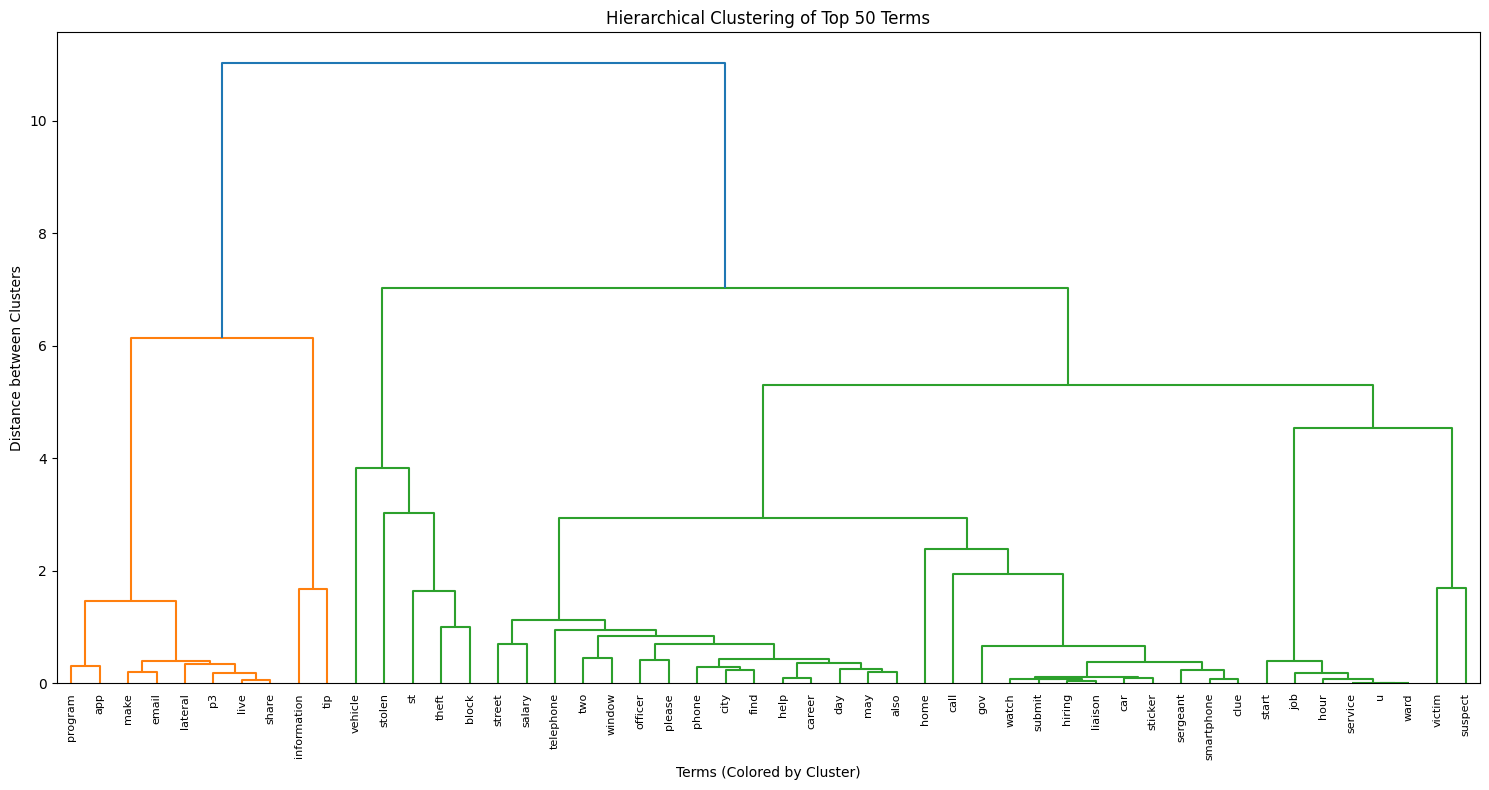

In [ ]:
# First, let's be explicit about how many terms we want to cluster
N_TERMS = 50  # We want exactly 50 terms

# Get the top N terms
top_terms = term_table.nlargest(N_TERMS, 'collection_frequency')

# Verify our selection
print(f"Number of top terms selected: {len(top_terms)}")

# Create features for these exact terms
features_for_clustering = top_terms[[f'PC{i}' for i in range(1, 11)]].values
print(f"Feature matrix shape: {features_for_clustering.shape}")

# Create linkage matrix
linkage_matrix = linkage(features_for_clustering, method='ward')
print(f"Linkage matrix shape: {linkage_matrix.shape}")

# Create the dendrogram with verified dimensions
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, 
          labels=top_terms['term_text'].values,
          leaf_rotation=90,
          leaf_font_size=8,
          color_threshold=0.7*max(linkage_matrix[:,2]))

plt.title('Hierarchical Clustering of Top 50 Terms')
plt.xlabel('Terms (Colored by Cluster)')
plt.ylabel('Distance between Clusters')
plt.tight_layout()
plt.show()

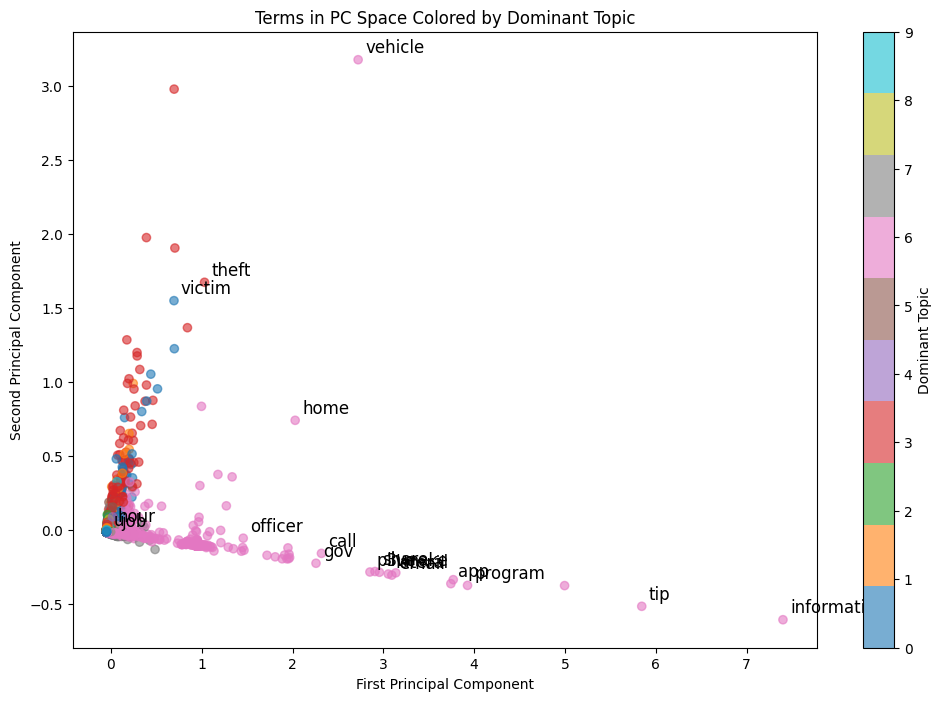

In [ ]:
# Create a scatter plot of PC1 vs PC2 colored by topics
plt.figure(figsize=(12, 8))
# Get the dominant topic for each term
dominant_topic = term_table[[f'Topic{i}' for i in range(1, 11)]].idxmax(axis=1)

plt.scatter(term_table['PC1'], term_table['PC2'], 
           c=dominant_topic.astype('category').cat.codes, 
           cmap='tab10', alpha=0.6)

# Add labels for interesting terms
top_terms = term_table.nlargest(20, 'collection_frequency')
for _, term in top_terms.iterrows():
    plt.annotate(term['term_text'], 
                (term['PC1'], term['PC2']),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=12)

plt.title('Terms in PC Space Colored by Dominant Topic')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Dominant Topic')

# Word2Vec

In [ ]:
from gensim.models import Word2Vec
import numpy as np

# First, we need to prepare our text data as sequences of tokens
# We'll use the mdu_content from f1_data and tokenize it
documents = []
for text in f1_data['mdu_content']:
    # Split text into tokens - we'll keep it simple for the base implementation
    tokens = text.lower().split()
    documents.append(tokens)

# Train the Word2Vec model
# vector_size=100 creates 100-dimensional vectors for each word
# window=5 looks at 5 words before and after each target word
# min_count=1 includes all words, even if they appear only once
w2v_model = Word2Vec(documents, 
                    vector_size=100, 
                    window=5, 
                    min_count=1, 
                    workers=4)

# Now let's add these embeddings to our term table
# We'll start by creating a matrix of embeddings
embedding_features = []
for term in term_table['term_text']:
    try:
        # Get the embedding vector for the term
        vec = w2v_model.wv[term.lower()]
    except KeyError:
        # If term isn't in vocabulary, use zeros
        vec = np.zeros(100)
    embedding_features.append(vec)

# Convert to numpy array for easier handling
embedding_matrix = np.vstack(embedding_features)

# Add the first 10 dimensions to term_table for visualization
for i in range(10):
    term_table[f'w2v_dim_{i}'] = embedding_matrix[:, i]

Exploring semantic relationships in police reports:

Terms most similar to 'vehicle':
  - residence: 0.581
  - vehicles: 0.531
  - store: 0.530
  - home: 0.523
  - business: 0.518

Terms most similar to 'victim':
  - address: 0.803
  - female: 0.773
  - complainant: 0.765
  - said: 0.755
  - man: 0.751

Terms most similar to 'theft':
  - amount: 0.637
  - prevent: 0.626
  - motor: 0.613
  - westbound: 0.601
  - small: 0.599

Terms most similar to 'officer':
  - becoming: 0.660
  - interested: 0.623
  - some: 0.610
  - wants: 0.562
  - work: 0.547


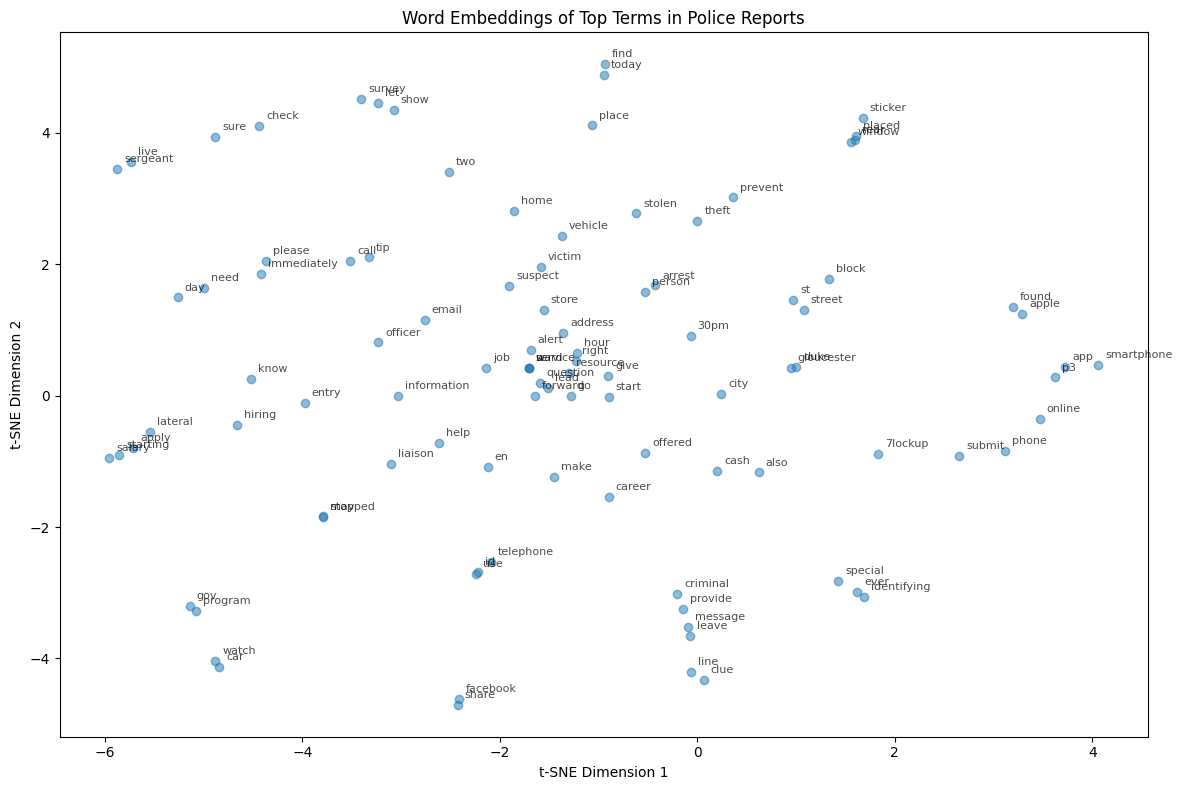

In [ ]:
# 1. Find semantically similar terms for important police report words
important_terms = ['vehicle', 'victim', 'theft', 'officer']

print("Exploring semantic relationships in police reports:")
for term in important_terms:
    try:
        similar_terms = w2v_model.wv.most_similar(term.lower())
        print(f"\nTerms most similar to '{term}':")
        for similar_term, score in similar_terms[:5]:
            print(f"  - {similar_term}: {score:.3f}")
    except KeyError:
        print(f"'{term}' not found in vocabulary")

# 2. Let's visualize the embeddings for top terms using t-SNE
from sklearn.manifold import TSNE

# Get embeddings for the most frequent terms
top_n = 100
top_terms = term_table.nlargest(top_n, 'collection_frequency')
top_term_embeddings = embedding_matrix[top_terms.index]

# Reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(top_term_embeddings)

# Create the visualization
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

# Add labels for these terms
for i, term in enumerate(top_terms['term_text']):
    plt.annotate(term, 
                (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=8,
                alpha=0.7)

plt.title('Word Embeddings of Top Terms in Police Reports')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Exploring Police Report Language Categories:

Crime Types:

Terms associated with 'theft':
  - amount: 0.637
  - prevent: 0.626
  - motor: 0.613
  Context analysis ('theft' + 'victim' - 'officer'):
  → attempted: 0.665

Terms associated with 'robbery':
  - armed: 0.924
  - assault: 0.915
  - burglary: 0.911
  Context analysis ('robbery' + 'victim' - 'officer'):
  → complainant: 0.768

Terms associated with 'assault':
  - robbery: 0.915
  - armed: 0.895
  - degree: 0.870
  Context analysis ('assault' + 'victim' - 'officer'):
  → robbery: 0.834

Terms associated with 'burglary':
  - robbery: 0.911
  - armed: 0.855
  - destruction: 0.853
  Context analysis ('burglary' + 'victim' - 'officer'):
  → robbery: 0.822

Terms associated with 'vandalism':
  - bestgate: 0.737
  - pinkish: 0.729
  - urban: 0.728
  Context analysis ('vandalism' + 'victim' - 'officer'):
  → flee: 0.711

Locations:

Terms associated with 'vehicle':
  - residence: 0.581
  - vehicles: 0.531
  - store: 0.530

Terms associ

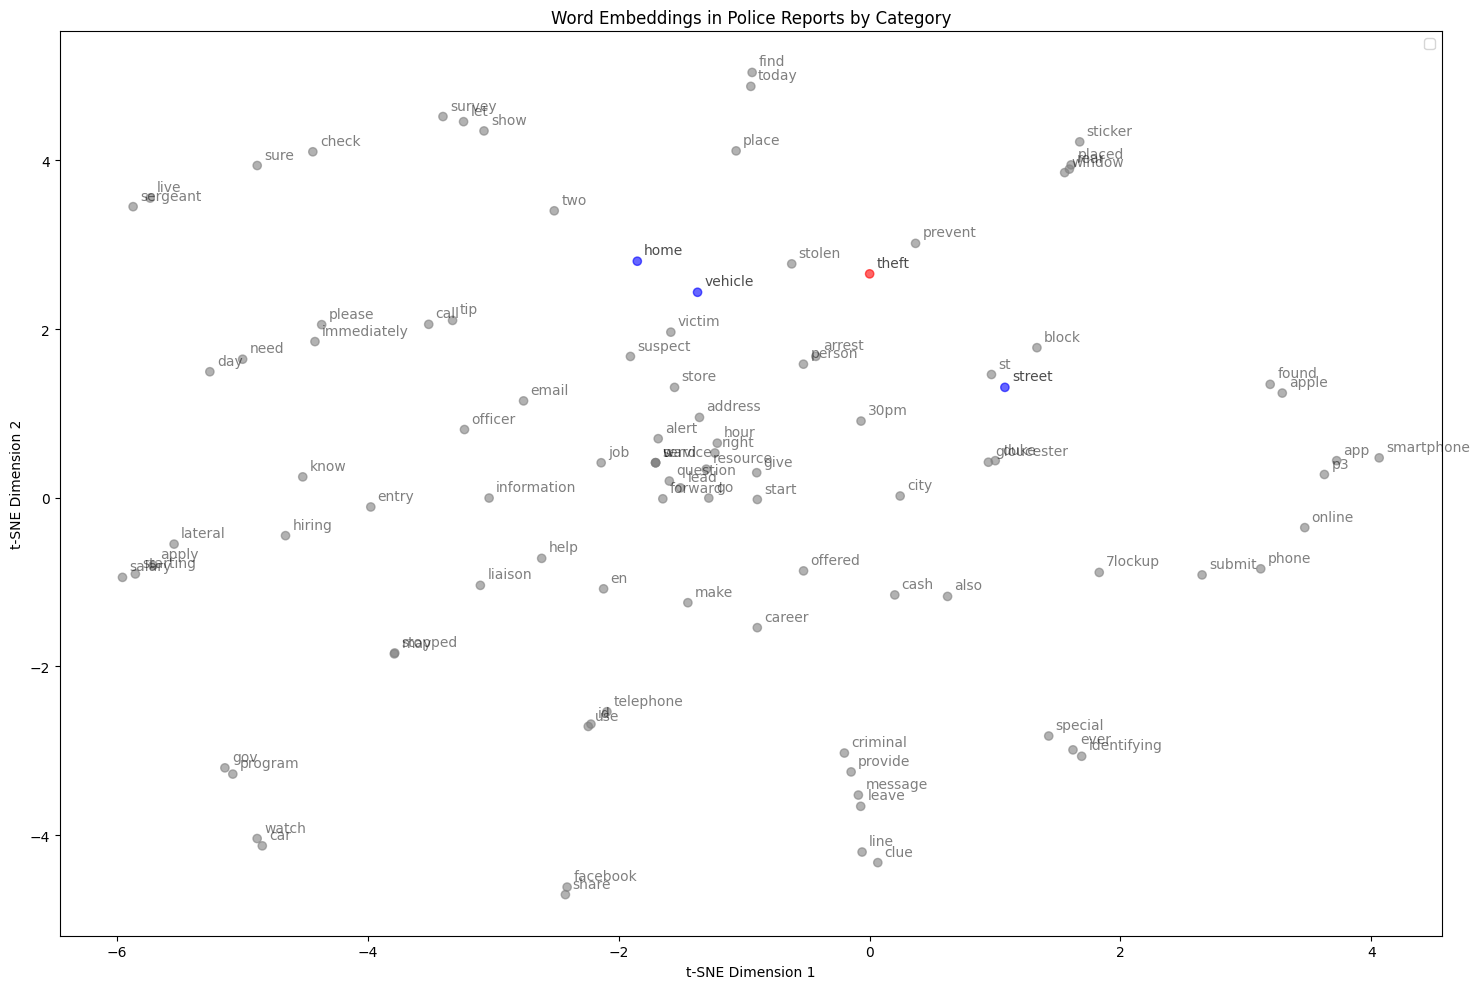

In [ ]:
# Let's explore more targeted semantic relationships
crime_terms = ['theft', 'robbery', 'assault', 'burglary', 'vandalism']
location_terms = ['vehicle', 'residence', 'street', 'business', 'home']
action_terms = ['arrested', 'reported', 'investigated', 'responded', 'searched']

print("Exploring Police Report Language Categories:")

# Analyze each category
for category, terms in [("Crime Types", crime_terms), 
                       ("Locations", location_terms), 
                       ("Police Actions", action_terms)]:
    print(f"\n{category}:")
    for term in terms:
        try:
            # Get similar terms
            similar = w2v_model.wv.most_similar(term.lower())
            print(f"\nTerms associated with '{term}':")
            for similar_term, score in similar[:3]:
                print(f"  - {similar_term}: {score:.3f}")
                
            # Try to find analogy relationships
            if category == "Crime Types":
                try:
                    result = w2v_model.wv.most_similar(
                        positive=[term, 'victim'],
                        negative=['officer']
                    )
                    print(f"  Context analysis ('{term}' + 'victim' - 'officer'):")
                    print(f"  → {result[0][0]}: {result[0][1]:.3f}")
                except KeyError:
                    pass
        except KeyError:
            print(f"'{term}' not found in vocabulary")

# Enhanced visualization with categorical coloring
plt.figure(figsize=(15, 10))

# Create category labels for terms
categories = {
    'crime': crime_terms,
    'location': location_terms,
    'action': action_terms,
    'other': []  # For terms not in our categories
}

# Assign colors to each term based on category
colors = []
category_labels = []
for term in top_terms['term_text']:
    term_lower = term.lower()
    category = 'other'
    for cat, terms in categories.items():
        if term_lower in [t.lower() for t in terms]:
            category = cat
            break
    category_labels.append(category)

# Create scatter plot with categorical colors
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                     c=[{'crime': 'red', 'location': 'blue', 
                         'action': 'green', 'other': 'gray'}[cat] 
                        for cat in category_labels],
                     alpha=0.6)

# Add labels with improved positioning
for i, term in enumerate(top_terms['term_text']):
    plt.annotate(term, 
                (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=10,
                alpha=0.7 if category_labels[i] != 'other' else 0.5)

plt.title('Word Embeddings in Police Reports by Category')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(handles=scatter.legend_elements()[0],
          labels=list(categories.keys()))
plt.tight_layout()
plt.show()

In [ ]:
from collections import defaultdict

# First, let's find terms related to vehicles in our word embeddings
vehicle_related = w2v_model.wv.most_similar(['vehicle', 'car'], topn=10)
print("Terms most similar to 'vehicle' and 'car':")
for term, score in vehicle_related:
    print(f"  - {term}: {score:.3f}")

# Now, let's look for actual mentions of vehicle types in theft contexts
# We'll search through our original documents for patterns
theft_vehicle_mentions = []

for text in f1_data['mdu_content']:
    # Convert to lowercase for consistent matching
    text_lower = text.lower()
    
    # Check if this is about vehicle theft
    if 'theft' in text_lower and ('vehicle' in text_lower or 'car' in text_lower):
        # Add to our collection
        theft_vehicle_mentions.append(text)

print(f"\nFound {len(theft_vehicle_mentions)} mentions of vehicle theft")

# Let's look for specific car makes/models
# Common car manufacturers
car_makes = ['toyota', 'honda', 'ford', 'chevrolet', 'chevy', 'nissan', 
             'hyundai', 'kia', 'bmw', 'mercedes', 'audi', 'volkswagen', 'vw']

make_counts = defaultdict(int)
for text in theft_vehicle_mentions:
    text_lower = text.lower()
    for make in car_makes:
        if make in text_lower:
            make_counts[make] += 1

# Show results
print("\nMentions of specific car makes in theft reports:")
for make, count in sorted(make_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  - {make.title()}: {count}")


# Let's also look at the broader context of vehicle-related terms
# Get a sample of contexts where vehicles are mentioned
vehicle_contexts = []
context_window = 5  # words before and after

for text in f1_data['mdu_content']:
    words = text.lower().split()
    for i, word in enumerate(words):
        if word in ['vehicle', 'car']:
            start = max(0, i - context_window)
            end = min(len(words), i + context_window + 1)
            context = ' '.join(words[start:end])
            vehicle_contexts.append(context)

print("\nSample contexts where vehicles are mentioned:")
for context in vehicle_contexts[:5]:
    print(f"  - ...{context}...")

Terms most similar to 'vehicle' and 'car':
  - watch: 0.691
  - helps: 0.630
  - takehome: 0.592
  - vehiclethere: 0.564
  - kddz76: 0.561
  - blow: 0.555
  - rolex: 0.534
  - handbags: 0.505
  - home: 0.504
  - prevent: 0.503

Found 1674 mentions of vehicle theft

Mentions of specific car makes in theft reports:
  - Ford: 65
  - Toyota: 36
  - Honda: 36
  - Audi: 25
  - Hyundai: 18
  - Nissan: 14
  - Chevrolet: 14
  - Volkswagen: 8
  - Kia: 8
  - Vw: 7
  - Chevy: 6
  - Mercedes: 4
  - Bmw: 4

Sample contexts where vehicles are mentioned:
  - ...purse that was in her vehicle there are no cameras in...
  - ...the victim requested that her vehicle not be processed no suspect...
  - ...a child struck by a vehicle upon officers arrival the juvenile...
  - ...is currently looking for the vehicle involved in this tragic anyone...
  - ...theft from vehicle block sixth st 24victim advised...



Types of Vehicle Incidents:
  - Theft: 548
  - Accident: 49
  - Break In: 138
  - Recovery: 73


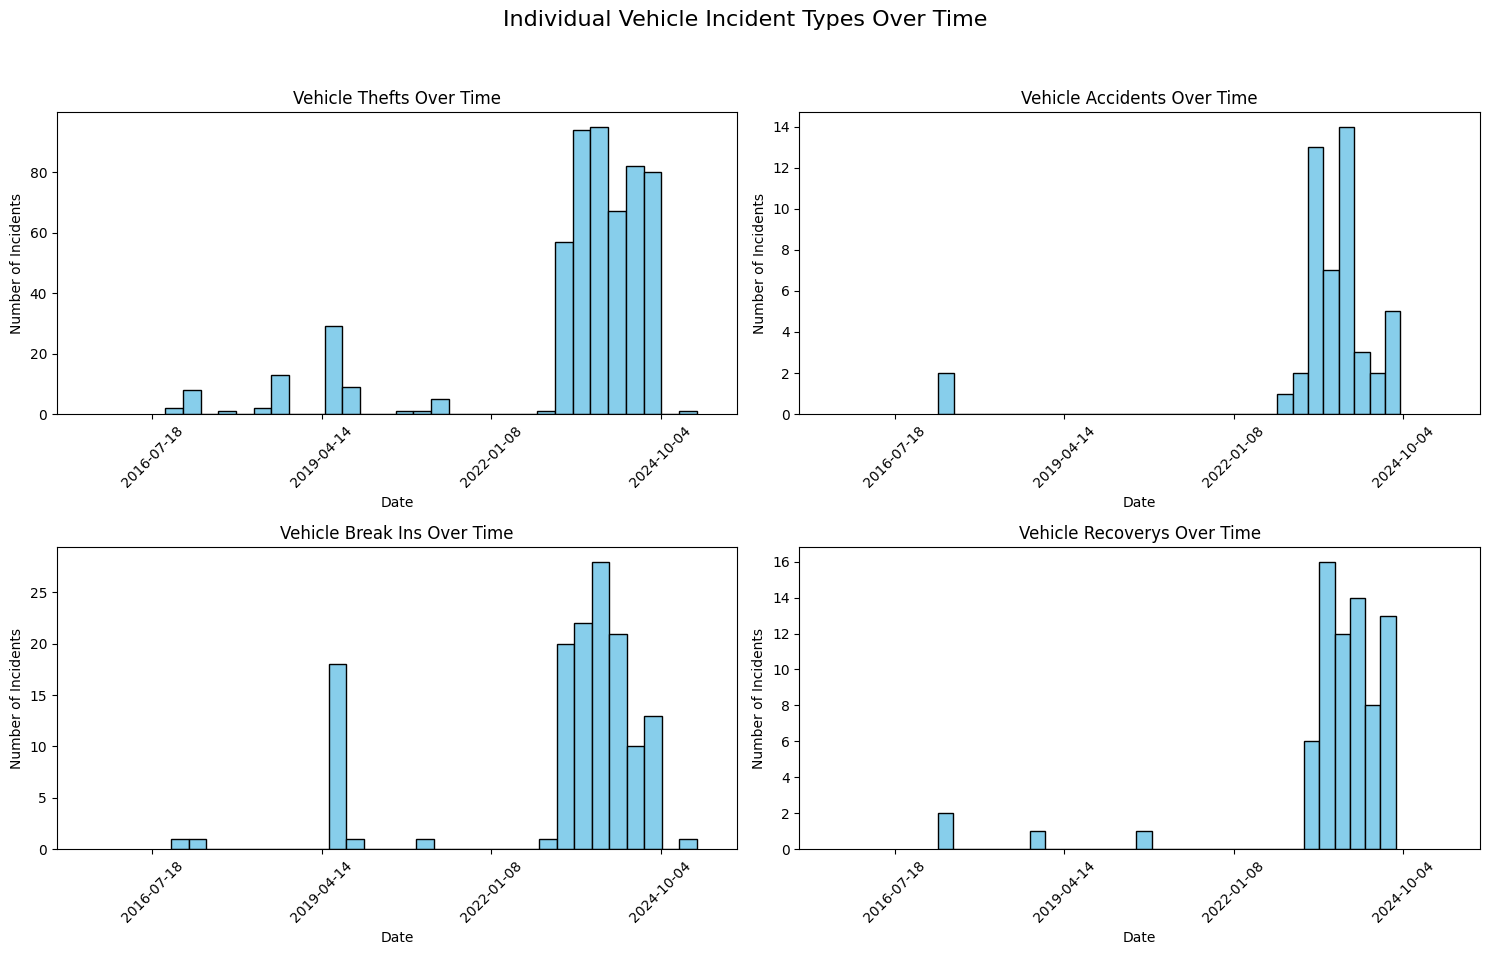

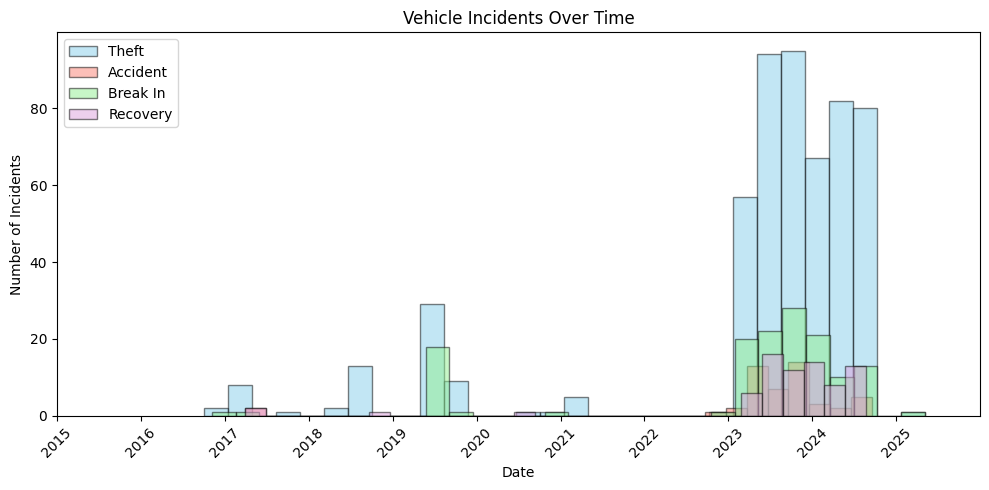

In [ ]:
# Ensure 'incident_date' is in datetime format
f1_data['incident_date'] = pd.to_datetime(f1_data['incident_date'], errors='coerce')

# Initialize dictionaries to store counts and dates
vehicle_incidents = {
    'theft': 0,
    'accident': 0,
    'break_in': 0,
    'recovery': 0
}

incident_dates = {
    'theft': [],
    'accident': [],
    'break_in': [],
    'recovery': []
}

# Define date range
start_date = datetime(2015, 1, 1)
end_date = datetime(2025, 12, 31)

# Categorize incidents and collect dates
for idx, row in f1_data.iterrows():
    text = row['mdu_content'].lower()
    incident_date = row['incident_date']
    
    if pd.notnull(incident_date) and start_date <= incident_date <= end_date:
        if 'vehicle' in text or 'car' in text:
            if 'theft' in text:
                vehicle_incidents['theft'] += 1
                incident_dates['theft'].append(incident_date)
            if 'accident' in text or 'struck' in text:
                vehicle_incidents['accident'] += 1
                incident_dates['accident'].append(incident_date)
            if 'break' in text or 'entered' in text:
                vehicle_incidents['break_in'] += 1
                incident_dates['break_in'].append(incident_date)
            if 'recovered' in text or 'recovery' in text:
                vehicle_incidents['recovery'] += 1
                incident_dates['recovery'].append(incident_date)

# Print categorized incident counts
print("\nTypes of Vehicle Incidents:")
for incident_type, count in vehicle_incidents.items():
    print(f"  - {incident_type.replace('_', ' ').title()}: {count}")

# Define plotting function for individual histograms
def plot_incident_histogram(ax, dates, incident_type, start, end):
    if dates:
        ax.hist(dates, bins=30, color='skyblue', edgecolor='black')
        ax.set_title(f'Vehicle {incident_type.replace("_", " ").title()}s Over Time')
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Incidents')
        ax.tick_params(axis='x', rotation=45)
        ax.set_xlim(start, end)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Limit number of ticks for readability
    else:
        ax.text(0.5, 0.5, f'No {incident_type.replace("_", " ").title()}s', 
                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f'Vehicle {incident_type.replace("_", " ").title()}s Over Time')
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Incidents')

# Create a 2x2 subplot grid for individual incident histograms
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Individual Vehicle Incident Types Over Time', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each incident type in its respective subplot
for idx, (incident_type, dates) in enumerate(incident_dates.items()):
    plot_incident_histogram(axes[idx], dates, incident_type, start_date, end_date)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the suptitle
plt.show()

# Combined Visualization: Overlapping Histograms
plt.figure(figsize=(10, 5))

# Define colors for each incident type
colors = {
    'theft': 'skyblue',
    'accident': 'salmon',
    'break_in': 'lightgreen',
    'recovery': 'plum'
}

# Plot each incident type
for incident_type, dates in incident_dates.items():
    if dates:
        plt.hist(dates, bins=30, alpha=0.5, label=incident_type.replace('_', ' ').title(),
                 color=colors.get(incident_type, 'gray'), edgecolor='black')

plt.title('Vehicle Incidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.xlim(start_date, end_date)
plt.legend()
plt.tight_layout()
plt.show()


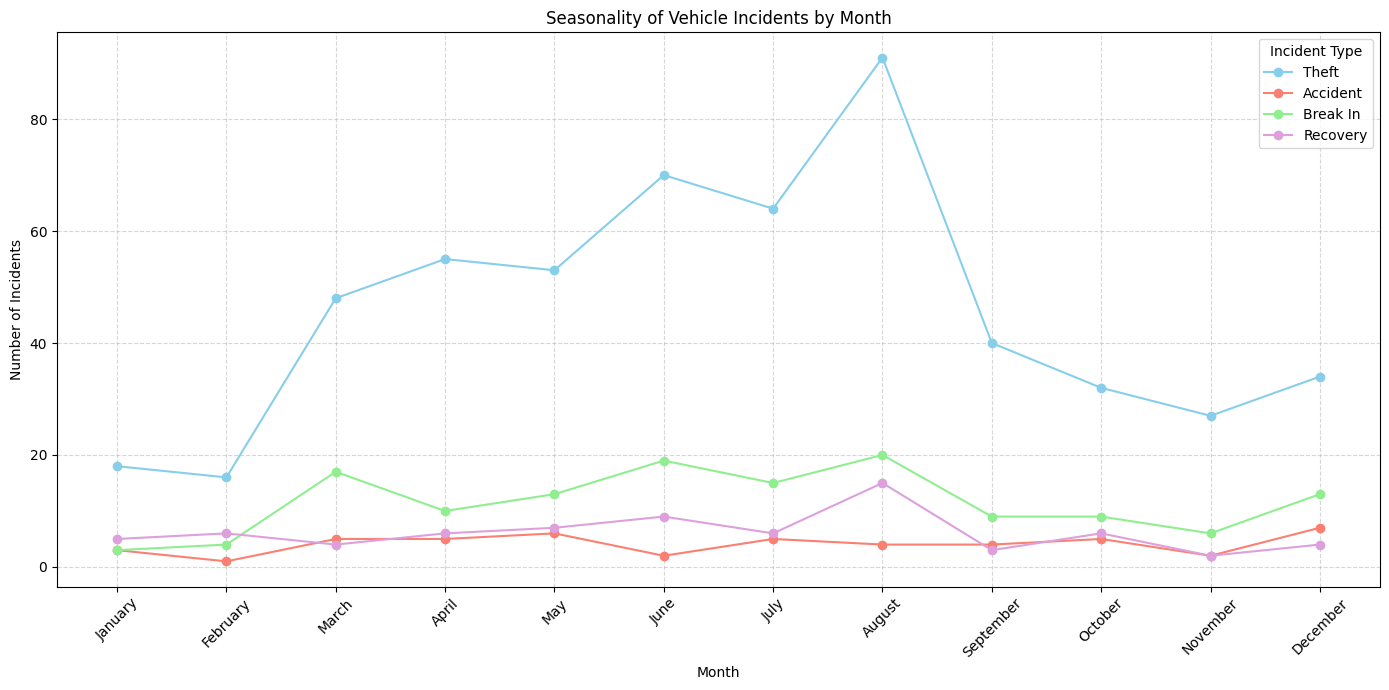

In [ ]:
# Initialize a dictionary to store month-wise counts for each incident type
incident_month_counts = {
    'theft': [0]*12,
    'accident': [0]*12,
    'break_in': [0]*12,
    'recovery': [0]*12
}

# Populate the month-wise counts
for incident_type, dates in incident_dates.items():
    for date in dates:
        month = date.month  # Extract month as integer (1-12)
        incident_month_counts[incident_type][month - 1] += 1  # Adjust index to 0-11

# Create a DataFrame for plotting
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']
seasonality_df = pd.DataFrame(incident_month_counts, index=months)


plt.figure(figsize=(14, 7))

# Plot each incident type with distinct colors
for incident_type, color in colors.items():
    if incident_type in seasonality_df.columns:
        plt.plot(seasonality_df.index, seasonality_df[incident_type], marker='o',
                 label=incident_type.replace('_', ' ').title(), color=color)

plt.title('Seasonality of Vehicle Incidents by Month')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.legend(title='Incident Type')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

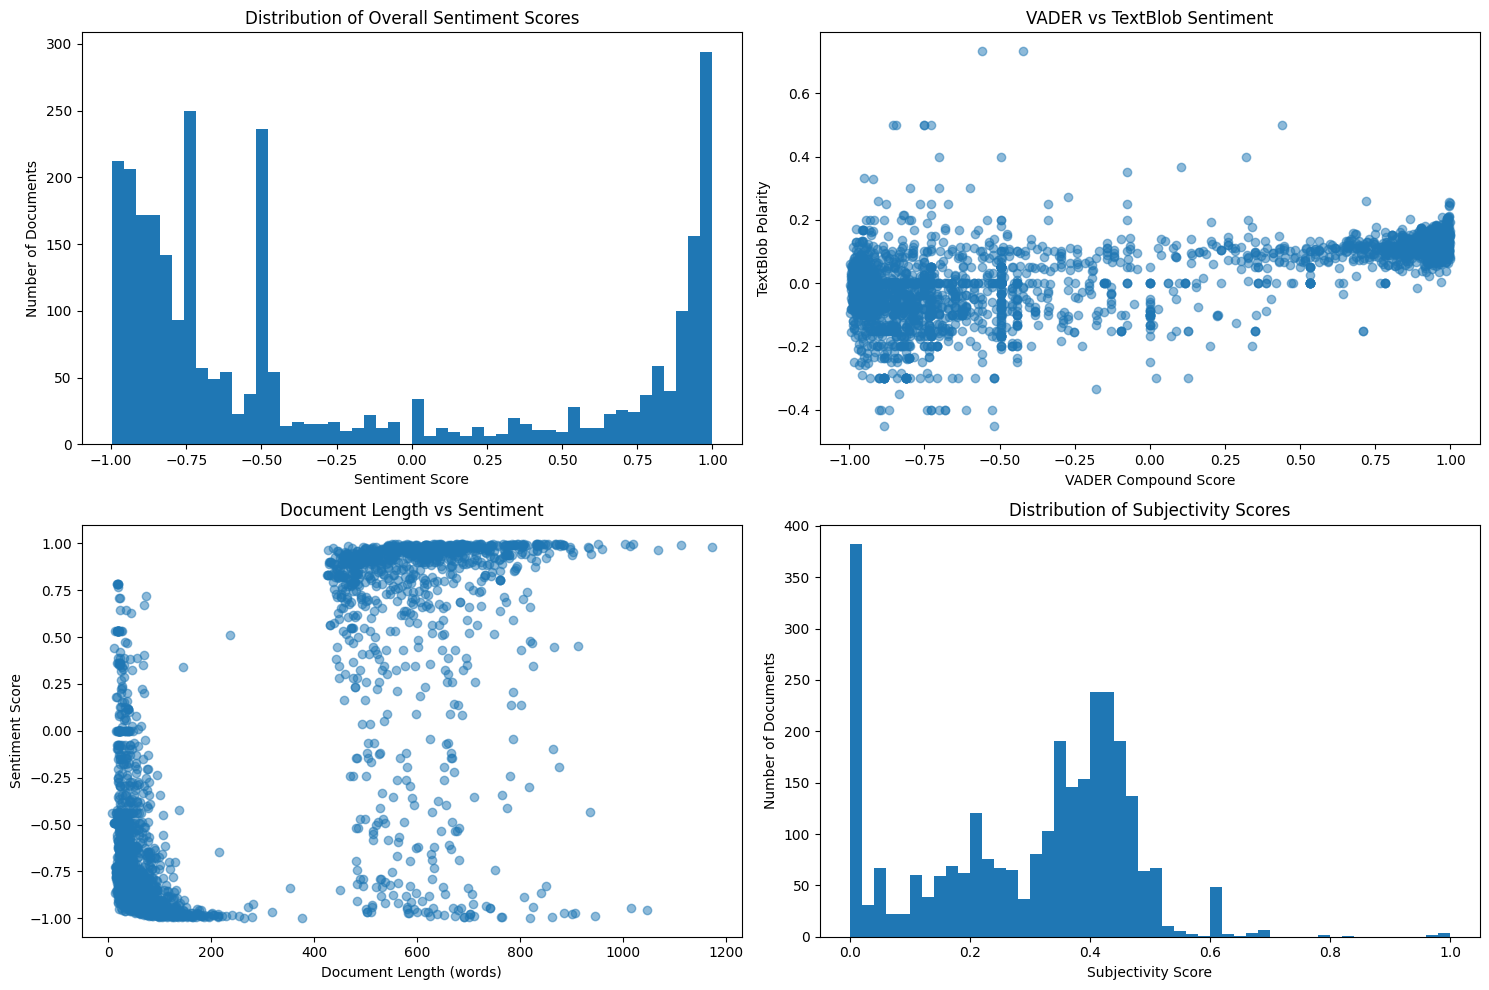


Sentiment Analysis Summary:
Average sentiment (VADER): -0.221
Median sentiment (VADER): -0.557
Standard deviation: 0.751

Document counts by sentiment category:
Positive (>0.05): 937
Neutral (-0.05 to 0.05): 36
Negative (<-0.05): 1907


In [ ]:
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize our sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Create document sentiment analysis
doc_sentiments = []

# Analyze each document
for idx, row in f1_data.iterrows():
    text = row['mdu_content']
    
    # Get VADER sentiment scores - this handles negations and modifiers well
    vader_scores = sia.polarity_scores(text)
    
    # Get TextBlob sentiment for additional perspective
    blob = TextBlob(text)
    
    # Create a rich sentiment record for each document
    sentiment_record = {
        'doc_id': row['doc_id'],
        'incident_id': row['incident_id'],
        'vader_compound': vader_scores['compound'],  # Overall sentiment
        'vader_pos': vader_scores['pos'],           # Positive aspect
        'vader_neg': vader_scores['neg'],           # Negative aspect
        'vader_neu': vader_scores['neu'],           # Neutral aspect
        'textblob_polarity': blob.sentiment.polarity,
        'textblob_subjectivity': blob.sentiment.subjectivity,
        'text_length': len(text.split())  # For context
    }
    doc_sentiments.append(sentiment_record)

# Create a DataFrame for analysis
doc_sentiment_df = pd.DataFrame(doc_sentiments)

# Let's create some visualizations to understand sentiment patterns
plt.figure(figsize=(15, 10))

# Create a subplot grid
plt.subplot(2, 2, 1)
plt.hist(doc_sentiment_df['vader_compound'], bins=50)
plt.title('Distribution of Overall Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Documents')

# Show relationship between different sentiment measures
plt.subplot(2, 2, 2)
plt.scatter(doc_sentiment_df['vader_compound'], 
           doc_sentiment_df['textblob_polarity'],
           alpha=0.5)
plt.title('VADER vs TextBlob Sentiment')
plt.xlabel('VADER Compound Score')
plt.ylabel('TextBlob Polarity')

# Show how document length relates to sentiment
plt.subplot(2, 2, 3)
plt.scatter(doc_sentiment_df['text_length'],
           doc_sentiment_df['vader_compound'],
           alpha=0.5)
plt.title('Document Length vs Sentiment')
plt.xlabel('Document Length (words)')
plt.ylabel('Sentiment Score')

# Show the distribution of subjectivity
plt.subplot(2, 2, 4)
plt.hist(doc_sentiment_df['textblob_subjectivity'], bins=50)
plt.title('Distribution of Subjectivity Scores')
plt.xlabel('Subjectivity Score')
plt.ylabel('Number of Documents')

plt.tight_layout()
plt.show()

# Calculate some summary statistics
print("\nSentiment Analysis Summary:")
print(f"Average sentiment (VADER): {doc_sentiment_df['vader_compound'].mean():.3f}")
print(f"Median sentiment (VADER): {doc_sentiment_df['vader_compound'].median():.3f}")
print(f"Standard deviation: {doc_sentiment_df['vader_compound'].std():.3f}")
print("\nDocument counts by sentiment category:")
print("Positive (>0.05):", sum(doc_sentiment_df['vader_compound'] > 0.05))
print("Neutral (-0.05 to 0.05):", 
      sum((doc_sentiment_df['vader_compound'] >= -0.05) & 
          (doc_sentiment_df['vader_compound'] <= 0.05)))
print("Negative (<-0.05):", sum(doc_sentiment_df['vader_compound'] < -0.05))

# Document Sentiment

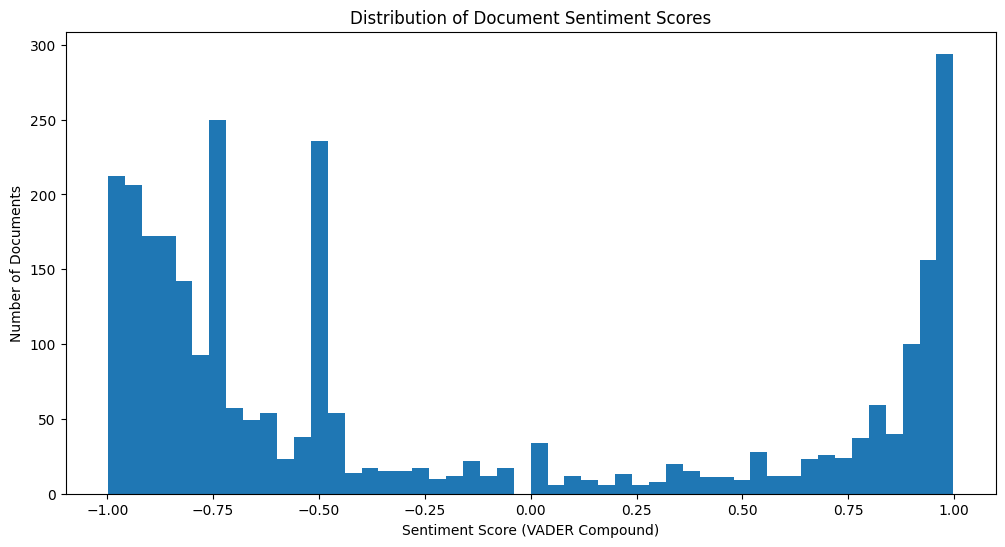

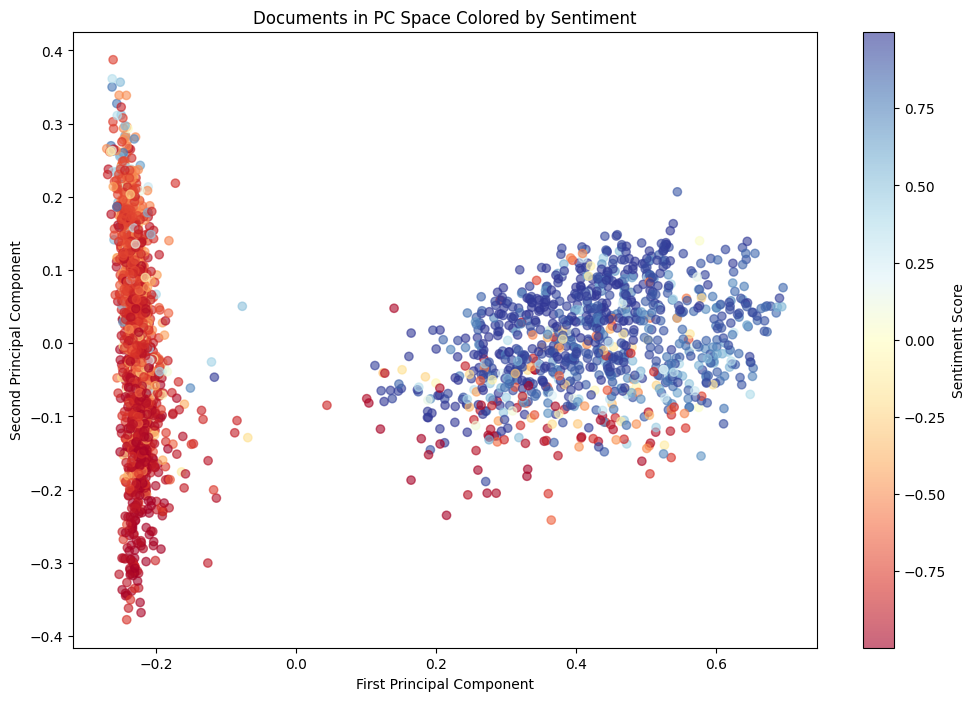

In [ ]:
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize our sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Create a document sentiment table
doc_sentiments = []

for idx, row in f1_data.iterrows():
    text = row['mdu_content']
    
    # Get VADER sentiment scores
    vader_scores = sia.polarity_scores(text)
    
    # Get TextBlob sentiment for additional perspective
    blob = TextBlob(text)
    
    # Combine sentiment metrics
    sentiment_record = {
        'doc_id': row['doc_id'],
        'vader_compound': vader_scores['compound'],
        'vader_pos': vader_scores['pos'],
        'vader_neg': vader_scores['neg'],
        'vader_neu': vader_scores['neu'],
        'textblob_polarity': blob.sentiment.polarity,
        'textblob_subjectivity': blob.sentiment.subjectivity
    }
    doc_sentiments.append(sentiment_record)

# Create document sentiment table
doc_sentiment_table = pd.DataFrame(doc_sentiments)

# Save as separate table
doc_sentiment_table.to_csv('document_sentiments.csv', index=False)

# Let's visualize the distribution of sentiment across documents
plt.figure(figsize=(12, 6))
plt.hist(doc_sentiment_table['vader_compound'], bins=50)
plt.title('Distribution of Document Sentiment Scores')
plt.xlabel('Sentiment Score (VADER Compound)')
plt.ylabel('Number of Documents')
plt.show()

# We can also look at how sentiment relates to our document clusters
plt.figure(figsize=(12, 8))
plt.scatter(doc_pca[:, 0], doc_pca[:, 1], 
           c=doc_sentiment_table['vader_compound'],
           cmap='RdYlBu',
           alpha=0.6)
plt.colorbar(label='Sentiment Score')
plt.title('Documents in PC Space Colored by Sentiment')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# F3 Next Steps

In [ ]:
#!pip install textblob
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
# Calculate sentiment polarity for each document
f1_data['sentiment'] = f1_data['mdu_content'].apply(lambda text: TextBlob(text).sentiment.polarity)

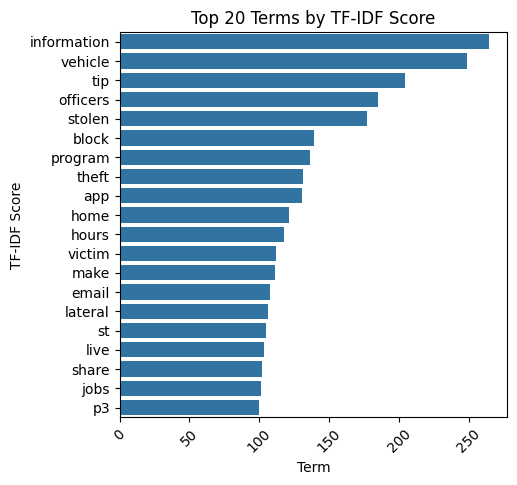

In [ ]:
# Prepare the documents
documents = f1_data['mdu_content'].fillna('').tolist()

# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(documents)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Sum the TF-IDF scores for each term across all documents
tfidf_scores = tfidf_matrix.sum(axis=0).A1

# Create a DataFrame with terms and their TF-IDF scores
tfidf_df = pd.DataFrame({'term': feature_names, 'score': tfidf_scores})

# Get the top 20 terms
top_tfidf_terms = tfidf_df.sort_values(by='score', ascending=False).head(20)

plt.figure(figsize=(5, 5))
sns.barplot(y='term', x='score', data=top_tfidf_terms)
plt.xticks(rotation=45)
plt.title('Top 20 Terms by TF-IDF Score')
plt.ylabel('TF-IDF Score')
plt.xlabel('Term')
plt.show()

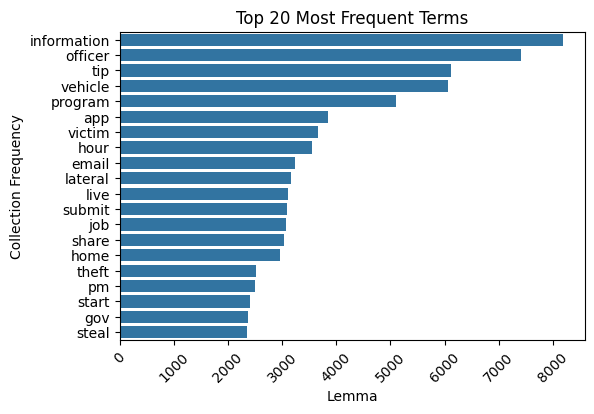

In [ ]:
# Get the top 20 most frequent terms
top_terms = term_table.sort_values(by='collection_frequency', ascending=False).head(20)

plt.figure(figsize=(6, 4))
sns.barplot(y='lemma', x='collection_frequency', data=top_terms)
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Terms')
plt.ylabel('Collection Frequency')
plt.xlabel('Lemma')
plt.show()

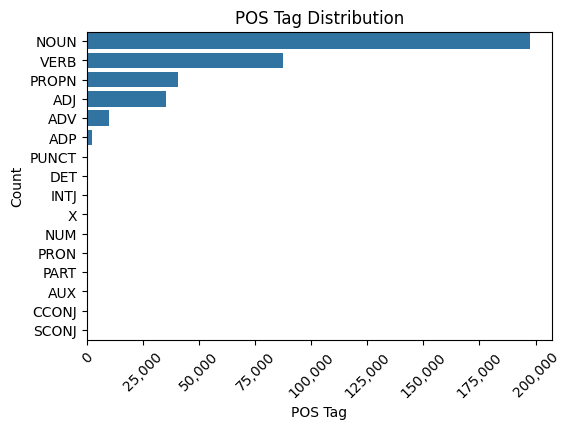

In [ ]:
pos_counts = token_table['pos'].value_counts().reset_index()
pos_counts.columns = ['pos', 'count']

# Function to format the x-axis labels with commas
def thousands_formatter(x, pos):
    return f'{int(x):,}'

plt.figure(figsize=(6, 4))
sns.barplot(y='pos', x='count', data=pos_counts)
plt.title('POS Tag Distribution')
plt.ylabel('Count')
plt.xlabel('POS Tag')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.show()

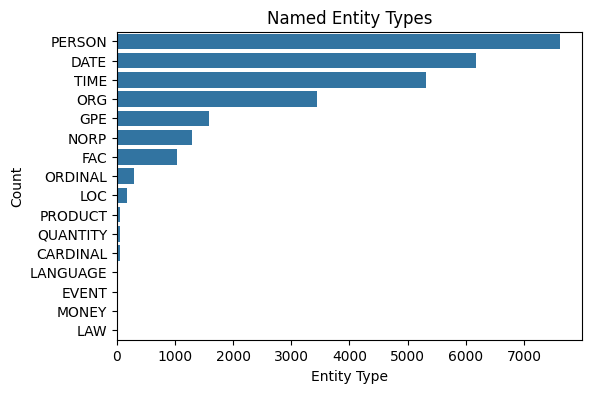

In [ ]:
# Filter tokens that are part of named entities
entity_tokens = token_table[token_table['ent_type'] != '']

# Count entity types
entity_counts = entity_tokens['ent_type'].value_counts().reset_index()
entity_counts.columns = ['entity_type', 'count']

plt.figure(figsize=(6, 4))
sns.barplot(y='entity_type', x='count', data=entity_counts)
plt.title('Named Entity Types')
plt.ylabel('Count')
plt.xlabel('Entity Type')
plt.show()

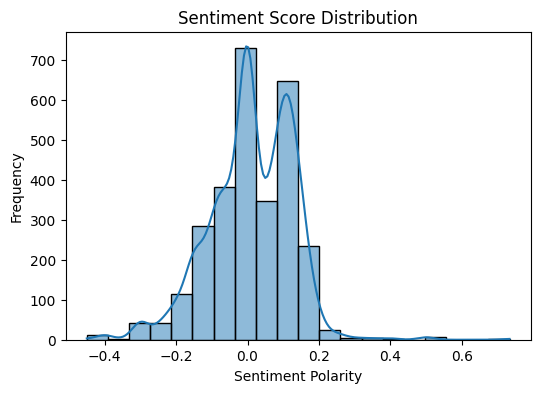

In [ ]:
# Histogram of sentiment scores
plt.figure(figsize=(6, 4))
sns.histplot(f1_data['sentiment'], bins=20, kde=True)
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

# F5: Apply Unsupervised Methods (PCA, LDA, word2vec)

# Word2Vec (Now Fasttext)

## First Model

In [ ]:
# Create labels from the 'section' column
f1_data['label'] = f1_data['section']

def assign_label(text):
    text = text.lower()  # Convert text to lowercase

    if re.search(r'\btheft\b', text):
        return 'Theft'
    elif re.search(r'\brobbery\b', text):
        return 'Robbery'
    elif re.search(r'\bshot\b', text) or re.search(r'\bshooting\b', text):
        return 'Shooting'
    elif re.search(r'\bassault\b', text):
        return 'Assault'
    else:
        return 'Other'

f1_data['label'] = f1_data['mdu_content'].apply(assign_label)

In [ ]:
f1_data['label'].value_counts()

label
Theft       1860
Other        705
Robbery      163
Assault       90
Shooting      62
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# Features and target variable
X = f1_data['mdu_content']
y = f1_data['label']

# Check for unique classes
print("Label Distribution:\n", y.value_counts())

if y.nunique() < 2:
    raise ValueError("Target variable must have at least two unique classes.")

# Vectorize the text data
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_vect = vectorizer.fit_transform(X)

# Inspect TF-IDF Matrix
print("TF-IDF Matrix Shape:", X_vect.shape)

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_vect, y, test_size=0.2, random_state=42, stratify=y
)

# Train the model
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

Label Distribution:
 label
Theft       1860
Other        705
Robbery      163
Assault       90
Shooting      62
Name: count, dtype: int64
TF-IDF Matrix Shape: (2880, 5000)
              precision    recall  f1-score   support

     Assault       0.71      0.94      0.81        18
       Other       0.75      0.97      0.85       141
     Robbery       0.82      0.94      0.87        33
    Shooting       0.85      0.92      0.88        12
       Theft       0.99      0.85      0.92       372

    accuracy                           0.89       576
   macro avg       0.82      0.92      0.87       576
weighted avg       0.91      0.89      0.89       576



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Unigram analysis
vectorizer = CountVectorizer(stop_words='english', max_features=100)
X_counts = vectorizer.fit_transform(f1_data['mdu_content'])
terms = vectorizer.get_feature_names_out()
term_frequencies = X_counts.toarray().sum(axis=0)
term_freq_df = pd.DataFrame({'term': terms, 'frequency': term_frequencies})
term_freq_df.sort_values(by='frequency', ascending=False, inplace=True)
print(term_freq_df.head(20))

           term  frequency
34  information       8179
91          tip       6118
94      vehicle       5737
51     officers       5678
59      program       4086
2           app       3838
28        hours       3524
45         make       3347
18        email       3233
38      lateral       3165
44         live       3104
72        share       3029
35         jobs       3027
53           p3       2913
27         home       2889
90        theft       2406
24          gov       2375
96      victims       2197
8           car       2121
98        watch       2091


# NER

- PhraseMatcher: This is a tool provided by spaCy to find sequences of words (multi-word phrases) in a document.
- nlp.vocab: Passes the vocabulary of your spaCy model to the matcher.
- Stop Phrases: A list of phrases you want to exclude during processing (e.g., "the annapolis police department" and "joe hudson").
- patterns: Converts the stop phrases into spaCy Doc objects so they can be matched in text.
- matcher.add: Adds the stop phrases to the matcher under the label 'STOP_PHRASES'.

In [ ]:
import re
digit_pattern = re.compile(r'\d')

In [ ]:
from spacy.matcher import PhraseMatcher
from nltk.corpus import stopwords
import nltk
import pandas as pd
import re
from tqdm import tqdm

# Download stopwords if not already done
nltk.download('stopwords')

# Initialize stop words in lowercase
stop_words = set(stopwords.words('english'))
stop_words_lower = {word.lower() for word in stop_words}

# Create a PhraseMatcher
matcher = PhraseMatcher(nlp.vocab)

# Add multi-word stop phrases
stop_phrases = ['the annapolis police department', 'joe hudson']
patterns = [nlp(text) for text in stop_phrases]
matcher.add('STOP_PHRASES', None, *patterns)

# Define digit pattern
digit_pattern = re.compile(r'\d')

# Initialize lists to store records
token_records = []
entity_records = []

# Assuming f1_data is your DataFrame
for _, row in tqdm(f1_data.iterrows(), total=f1_data.shape[0]):
    doc_id = row['doc_id']
    incident_id = row['incident_id']
    content = row['mdu_content']
    
    # Process the document with spaCy
    doc = nlp(content)
    
    # Find matches for stop phrases
    matches = matcher(doc)
    spans_to_exclude = [doc[start:end] for match_id, start, end in matches]
    
    # Exclude tokens within stop phrases
    tokens_to_exclude = set()
    for span in spans_to_exclude:
        tokens_to_exclude.update(range(span.start, span.end))
    
    # Map entity labels, excluding stop phrases
    ent_labels = {}
    for ent in doc.ents:
        if not any(idx in tokens_to_exclude for idx in range(ent.start, ent.end)):
            entity_text = ent.text.lower()
            if (entity_text not in stop_words_lower and
                not digit_pattern.search(entity_text)):
                # Collect entity records
                entity_records.append({
                    'doc_id': doc_id,
                    'incident_id': incident_id,
                    'entity_text': ent.text,
                    'entity_label': ent.label_,
                    'start_char': ent.start_char,
                    'end_char': ent.end_char
                })
                # Map entity labels to tokens
                for idx in range(ent.start, ent.end):
                    ent_labels[idx] = ent.label_
    
    # Iterate over tokens
    for idx, token in enumerate(doc):
        token_text_lower = token.text.lower()
        if (idx not in tokens_to_exclude and
            token_text_lower not in stop_words_lower and
            not digit_pattern.search(token_text_lower)):
            token_ent_type = ent_labels.get(idx, '')
            token_records.append({
                'doc_id': doc_id,
                'incident_id': incident_id,
                'position': idx + 1,  # Positions start at 1
                'token_text': token.text,
                'lemma': token.lemma_,
                'pos': token.pos_,
                'tag': token.tag_,       # Detailed POS tag
                'is_stop': token.is_stop,
                'is_punct': token.is_punct,
                'is_alpha': token.is_alpha,
                'ent_type': token_ent_type,  # Named entity type
                'dep': token.dep_,           # Dependency label
                'head_text': token.head.text,  # Head word
                'head_pos': token.head.pos_,   # POS of head word
            })

# Convert records to DataFrames
token_table = pd.DataFrame(token_records)
entity_table = pd.DataFrame(entity_records)

# Now, you can count the frequency of each entity type
entity_type_counts = entity_table['entity_label'].value_counts().reset_index()
entity_type_counts.columns = ['entity_label', 'count']

print("Entity Type Counts:")
print(entity_type_counts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bengb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 2880/2880 [00:46<00:00, 61.57it/s]


Entity Type Counts:
   entity_label  count
0          DATE   4174
1        PERSON   3621
2          TIME   2895
3           ORG   2103
4          NORP   1261
5      CARDINAL   1106
6           GPE    975
7       ORDINAL    519
8           FAC    450
9           LOC     75
10      PRODUCT     44
11     LANGUAGE     15
12     QUANTITY     14
13          LAW      3
14        EVENT      2
15        MONEY      2


In [ ]:
# Count the frequency of each entity type
entity_type_counts = entity_table['entity_label'].value_counts().reset_index()
entity_type_counts.columns = ['entity_label', 'count']

print("Entity Type Counts:")
print(entity_type_counts)

Entity Type Counts:
   entity_label  count
0          DATE   4174
1        PERSON   3621
2          TIME   2895
3           ORG   2103
4          NORP   1261
5      CARDINAL   1106
6           GPE    975
7       ORDINAL    519
8           FAC    450
9           LOC     75
10      PRODUCT     44
11     LANGUAGE     15
12     QUANTITY     14
13          LAW      3
14        EVENT      2
15        MONEY      2


In [ ]:
# Count the frequency of each entity text
entity_text_counts = entity_table['entity_text'].value_counts().reset_index()
entity_text_counts.columns = ['entity_text', 'count']

# Get the top 20 most common entities
top_entities = entity_text_counts.head(20)

print("\nTop 20 Entities:")
print(top_entities)


Top 20 Entities:
            entity_text  count
0                 today   1023
1               spanish   1022
2   less than two hours   1007
3             the hours   1005
4               android    914
5          kevin krauss    730
6                   two    538
7                monday    375
8        robert galusha    318
9               tuesday    284
10        angelo watson    237
11        taylor avenue    227
12                hours    199
13                first    190
14            bay ridge    189
15               second    187
16       bernie bennett    185
17             saturday    184
18  anne arundel county    180
19                three    166


In [ ]:
# Group entities by document
entities_by_doc = entity_table.groupby('doc_id')['entity_text'].apply(list).reset_index()

print("\nEntities in Documents:")
entities_by_doc.head()


Entities in Documents:


doc_id                                        entity_text
0       1                                         [margaret]
1       2  [one month ago, monroe st victim, bay ridge, a...
2       3                                               [us]
3       4  [android, less than two hours, today, spanish,...
4       5                                 [approximately pm]

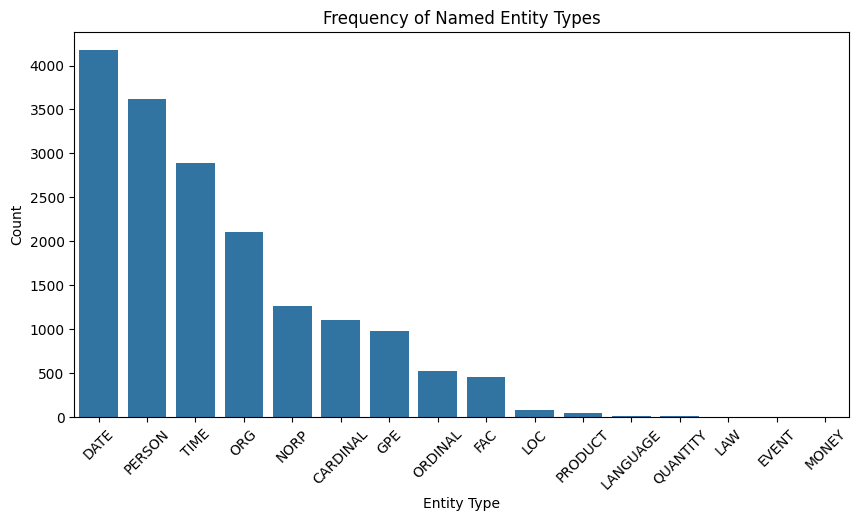

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x='entity_label', y='count', data=entity_type_counts)
plt.title('Frequency of Named Entity Types')
plt.ylabel('Count')
plt.xlabel('Entity Type')
plt.xticks(rotation=45)
plt.show()

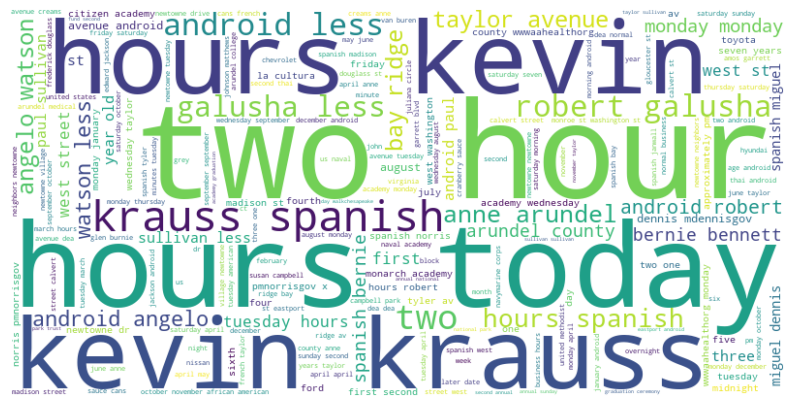

In [ ]:
from wordcloud import WordCloud

# Generate a word cloud for entities
text = ' '.join(entity_table['entity_text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Merge entity types into token_table
token_table = token_table.merge(entity_table[['doc_id', 'entity_text', 'entity_label']], 
                                left_on=['doc_id', 'token_text'], 
                                right_on=['doc_id', 'entity_text'], 
                                how='left')

# Update the TERM table to include whether the term is a named entity and its type
term_entity_info = token_table.groupby('lemma').agg({
    'entity_label': lambda x: x.mode()[0] if not x.mode().empty else ''
}).reset_index()

# Merge with term_table
term_table = term_table.merge(term_entity_info, on='lemma', how='left')

In [ ]:
from itertools import combinations
from collections import Counter

# Create a list of entity sets per document
entity_sets = entity_table.groupby('doc_id')['entity_text'].apply(set)

# Count co-occurrences
co_occurrence_counts = Counter()

for entities in entity_sets:
    for pair in combinations(entities, 2):
        co_occurrence_counts[frozenset(pair)] += 1

# Convert to DataFrame
co_occurrence_df = pd.DataFrame([(list(k), v) for k, v in co_occurrence_counts.items()], 
                                columns=['entity_pair', 'count'])

# Expand entity pairs into separate columns
co_occurrence_df[['entity1', 'entity2']] = pd.DataFrame(co_occurrence_df['entity_pair'].tolist(), index=co_occurrence_df.index)
co_occurrence_df = co_occurrence_df.drop(columns=['entity_pair'])

# Display top co-occurring entity pairs
top_co_occurrences = co_occurrence_df.sort_values(by='count', ascending=False).head(20)

print("\nTop Co-occurring Entities:")
print(top_co_occurrences[['entity1', 'entity2', 'count']])


Top Co-occurring Entities:
                   entity1              entity2  count
0      less than two hours              spanish   1007
9                    today              spanish   1007
3                    today  less than two hours   1007
45               the hours                today   1005
34               the hours              spanish   1005
31               the hours  less than two hours   1005
2                  android  less than two hours    906
8                  android              spanish    906
18                 android                today    906
44                 android            the hours    904
1714          kevin krauss  less than two hours    730
1715          kevin krauss              spanish    730
1717          kevin krauss                today    730
1718          kevin krauss            the hours    730
1716          kevin krauss              android    629
16787       robert galusha  less than two hours    318
16788       robert galusha           

Still showing that the pre processing steps are not working, domain stop words and caps.

# Create Vector Representations F4

# F5 Extend with Unsupervised Methods (F5)

In [ ]:
# Use 'mdu_content' as 'combined_text'
f1_data['combined_text'] = f1_data['mdu_content'].fillna('')

# Proceed with vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_vect = vectorizer.fit_transform(f1_data['combined_text'])

# Extract feature names (terms)
terms = vectorizer.get_feature_names_out()

In [ ]:
print(f1_data.columns.tolist())
# Should now include 'combined_text'

['document_id', 'section', 'mdu_id', 'incident_id', 'incident_date', 'report_date', 'mdu_content', 'source_url', 'doc_id', 'sentiment', 'label', 'combined_text']


In [ ]:
#from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text data
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_vect = vectorizer.fit_transform(f1_data['combined_text'])

# Get feature names (terms)
terms = vectorizer.get_feature_names_out()

In [ ]:
#from sklearn.decomposition import PCA

# Convert the sparse matrix to a dense array
X_dense = X_vect.toarray()

# Apply PCA
pca = PCA(n_components=10, random_state=42)
principal_components = pca.fit_transform(X_dense)

# Create a DataFrame for principal components
pc_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(10)])
pc_df['doc_id'] = f1_data['doc_id']

In [ ]:
# Percentage of variance explained by each component
explained_variance = pca.explained_variance_ratio_
print("Explained variance by each principal component:")
for i, variance in enumerate(explained_variance):
    print(f"PC{i+1}: {variance:.4f}")

Explained variance by each principal component:
PC1: 0.1062
PC2: 0.0147
PC3: 0.0120
PC4: 0.0118
PC5: 0.0091
PC6: 0.0083
PC7: 0.0075
PC8: 0.0073
PC9: 0.0062
PC10: 0.0059


In [ ]:
# Save principal components for each document
#pc_df.to_csv('document_principal_components.csv', index=False)

# Get the loadings (contribution of each term to the components)
loadings = pca.components_.T  # Transpose to align terms with components
loadings_df = pd.DataFrame(loadings, index=terms, columns=[f'PC{i+1}' for i in range(10)])

# Save loadings
#loadings_df.to_csv('term_loadings.csv')

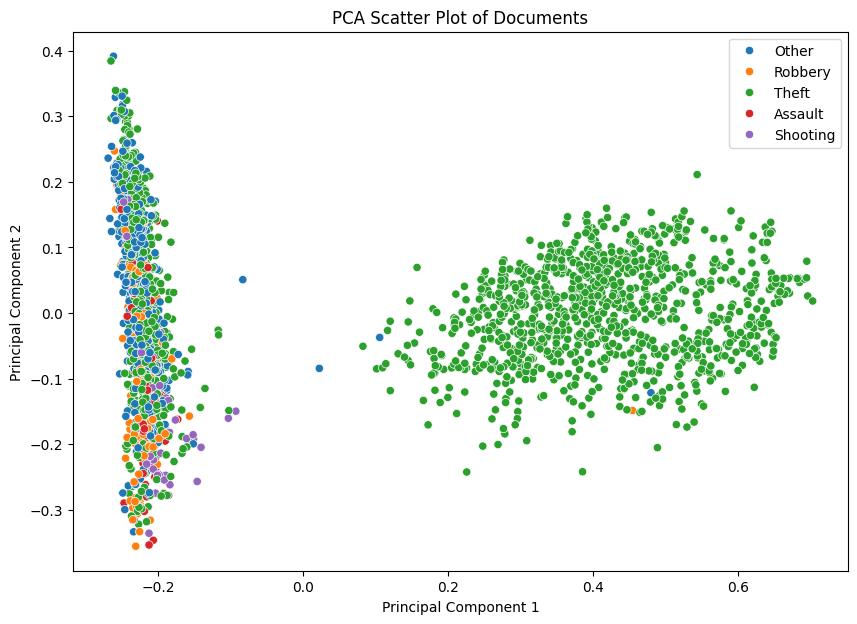

In [ ]:
# Merge with labels
pc_df_with_labels = pc_df.merge(f1_data[['doc_id', 'label']], on='doc_id')

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pc_df_with_labels, x='PC1', y='PC2', hue='label')
plt.title('PCA Scatter Plot of Documents')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Topic Modeling with Latent Dirichlet Allocation (LDA)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Number of topics
n_topics = 10

lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_topics = lda.fit_transform(X_vect)

# Each row corresponds to a document, each column to a topic
doc_topic_df = pd.DataFrame(lda_topics, columns=[f'Topic{i+1}' for i in range(n_topics)])
doc_topic_df['doc_id'] = f1_data['doc_id']
doc_topic_df.to_csv('document_topics.csv', index=False)

# Each row corresponds to a topic, each column to a term
topic_term_df = pd.DataFrame(lda.components_, columns=terms, index=[f'Topic{i+1}' for i in range(n_topics)])
topic_term_df.to_csv('topic_terms.csv')

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display top 10 words for each topic
display_topics(lda, terms, 10)

Topic 1:
victim officers suspect male area suspects located responded block adult
Topic 2:
bicycle stolen st vehicle bike black burglary block fired av
Topic 3:
information tip program app make email lateral hours officers live
Topic 4:
rosecrest gate catalytic garden converter haro deceased papers ashford womens
Topic 5:
vehicle stolen unlocked block theft entered burglary forced st door
Topic 6:
information tip program app hours make email lateral officers live
Topic 7:
placard merryman bmx woods 00am drivesometime dewey lake heron tuckahoe
Topic 8:
food toys cans canned thanksgiving position september bags donations local
Topic 9:
la boxwood cultura heights familia sobre latino janwall family cir
Topic 10:
hill matthews glenwood purple gorman television table 2023a employees steele


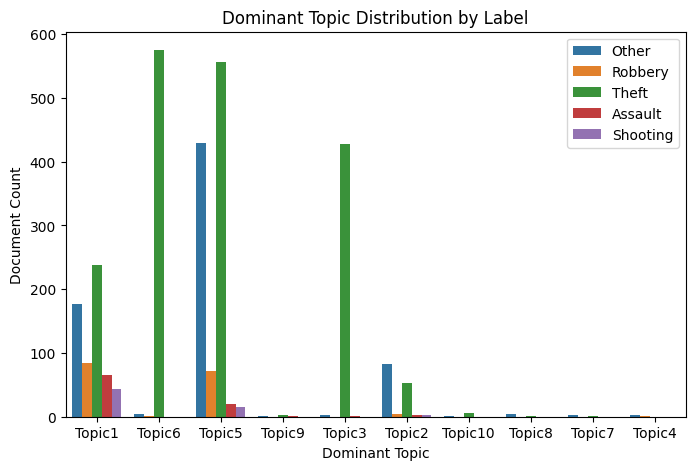

In [ ]:
# Merge document-topic distributions with labels
doc_topic_with_labels = doc_topic_df.merge(f1_data[['doc_id', 'label']], on='doc_id')

# Plot the dominant topic for each document
doc_topic_with_labels['Dominant_Topic'] = doc_topic_with_labels.drop(['doc_id', 'label'], axis=1).idxmax(axis=1)

plt.figure(figsize=(8, 5))
sns.countplot(x='Dominant_Topic', hue='label', data=doc_topic_with_labels)
plt.title('Dominant Topic Distribution by Label')
plt.xlabel('Dominant Topic')
plt.ylabel('Document Count')
plt.legend()
plt.show()

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Compute sentiment for each document
f1_data['sentiment'] = f1_data['combined_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Save sentiment scores
#f1_data[['doc_id', 'sentiment']].to_csv('document_sentiments.csv', index=False)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bengb\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


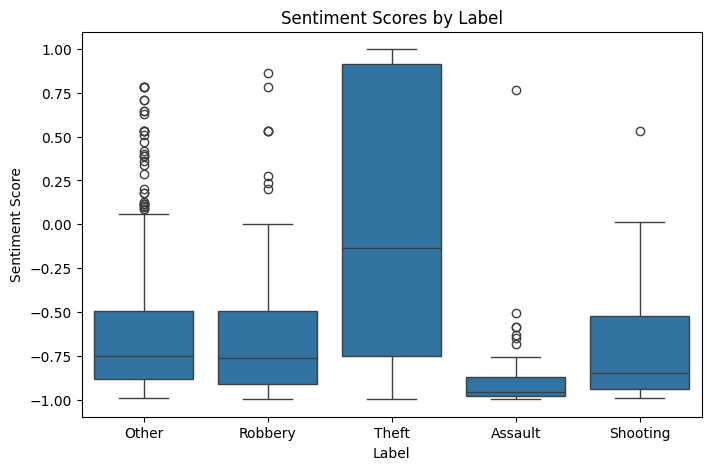

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='label', y='sentiment', data=f1_data)
plt.title('Sentiment Scores by Label')
plt.xlabel('Label')
plt.ylabel('Sentiment Score')
plt.show()

# Convert

1. Convert​ the collection from their source formats (F0) into a set of tables that conform to
the Standard Text Analytic Data Model (F2) and to the Machine Learning Corpus Format
(F1).


F0 Source Format. The initial source format of a text, which varies by
collection, e.g. XML (e.g. TEI and RSS), HTML, plain text (e.g.
Gutenberg), JSON, and CSV.

F1 Machine Learning Corpus Format (MLCF). Ideally a table of
minimum discursive units indexed by document content hierarchy.

F2 Standard Text Analytic Data Model (STADM). A normalized set of
tables including DOC, TOKEN, and TERM tables. Produced by the
tokenization of F1 data.

Exploratory Text Analytics Final Project
Overview
The goal of your final project is to apply and integrate what you have learned in this course to
create ​a digital critical edition of a corpus​ that will support exploration of the cultural contents of
that corpus. Cultural content is broadly conceived​—it may be about language use, social events,
cultural categories, sentiments, identity, taste, etc.
Specifically, you will acquire a collection of long-form texts and perform the following operations:
1. Convert​ the collection from their source formats (F0) into a set of tables that conform to
the Standard Text Analytic Data Model (F2) and to the Machine Learning Corpus Format
(F1).
2. Annotate​ these tables with statistical and linguistic features using NLP libraries such as
NLTK (F3).
3. Create​ a vector representation of the corpus to generate TFIDF values to add to the TOKEN
and VOCAB tables (F4).
4. Extend​ the annotated and vectorized model with tables and features derived from the
application of various unsupervised methods, including PCA, LDA, and word2vec (F5).
5. Explore​ your results using statistical and visualization methods.
6. Present​ conclusions about cultural patterns observed in the corpus by means of these
operations.
Deliverables
To receive full credit for the assignment, you must produce ​a digital analytical edition​ of a corpus.
This edition should include the following deliverables to be uploaded or linked to the Assignment
for the Final Project in Collab.
● A ​collection of source files​ ​compressed​ in an archive (e.g., zip or tar.gz) and ​hosted​ on
your UVA Box account.
o A ​manifest​ file describing those sources files, including their:
▪ Provenance​: Where did they come from? Describe the website or other
source and provide relevant URLs.
▪ Location​: Provide a link to the source files in UVA Box.
▪ Description​: What is the general subject matter of the corpus?
▪ Format​: A description of both the ​file formats​ of the source files, e.g.,
plaintext, XML, CSV, etc., and the ​internal structure​ where applicable. For
example, if XML then specify document type (e.g., TEI or XHTML).
● A collection of ​data files​, in either CSV or SQLite format, containing the F2 through F5 data
you extracted from the corpus.

o These files should include, at a minimum, the following core tables:
▪ LIBRARY.csv — Metadata for the source files
▪ TOKEN.csv — Annotated with statistical and linguistic features
▪ VOCAB.csv — Annotated with statistical and linguistic features
o In addition, you should include the following data in your files, either as features in
the appropriate core table or as separate tables. Note that all tables should have an
appropriate index and, where appropriate, an OCHO index.
▪ Principal Components
▪ Table of documents and components.
▪ Table of components and word counts (i.e., the “loadings”), either
added to the VOCAB table or as a separate table with a shared index
with the VOCAB table.
▪ Topic Models (LDA)
▪ Table of document and topic concentrations.
▪ Table of topics and term counts, either added to the VOCAB table or
as a separate table with a shared index with the VOCAB table.

▪ Word Embeddings (word2vec)
▪ Terms and embeddings, either added to the VOCAB table or as a
separate table with a shared index with the VOCAB table.

▪ Sentiment Analysis
▪ Sentiment and emotion values as features in VOCAB or as a
separate table with a shared index with the VOCAB table.
▪ Sentiment polarity and emotions for each document.
● The ​Jupyter notebooks​ used to perform all operations that produced the data in your
tables.
● One or more ​Jupyter notebooks​ that explore, visualize, and interpret the data. You should
use at least three of the following visualization types (beyond simple bar and pie charts):

▪ Hierarchical cluster diagrams
▪ Heatmaps showing correlations
▪ Scatter plots
▪ KDE plots
▪ Dispersion plots
▪ t-SNE plots

● Any ​Python files ​written (e.g., `.py` files) written to support your work.

● Any ​other assets​—e.g., images, stylesheets, JavaScript libraries, etc.​—required by your
notebooks.
● A ​two- to four-page final report ​presenting and interpreting the results of your work​. ​This
document can contain as many visualizations as necessary to make your points, but the
page count refers to text only.
Format and Style Guides
Any nondata files you produce, such as a Jupyter notebook, a manifest, or a Python program,
should contain a header stating your name and email address, the name of this class (DS 5001),
and the date. It should look something like this (depending on the document):
Rafael Alvarado (rca2t@virginia.edu)
DS 5001
26 January 2020
Jupyter notebooks should be properly outlined with headers and explanatory text where necessary
to follow what is happening.
The final report may be written using any word processor (e.g., Word or Google Docs), but please
upload it as a PDF. The document should have 12-point font and 1-inch margins, and should
contain images. The images, however, do not count toward the final page count.
Group Work
Students may work in groups. Ideally, these will be composed of three students, but may contain
two or four if necessary. In these groups, students may collaborate on the work of acquiring,
consolidating, and modifying the source data. In addition, students in groups are free to share
code and ideas. However, each student is responsible for ​their own deliverables​. In particular, the
observations made in the final report must be unique to each student. Of course, there will be
some overlap of ideas, but students must demonstrate that they have engaged individually with the
material by writing up their own conclusions and expressing them in their own language.
Grading Rubric
Given that the focus of this course is on method and not domain knowledge per se (although we
have covered a good bit of that), you may be liberal in your interpretations. That is, do not worry
about whether they will meet high scholarly and scientific standards. Remember, the purpose of
ETA is to open up texts so that you may ​explore​ them and extract possibly significant patterns
from them. However, you are expected to present your conclusions in a coherent and compelling
manner. And, if you do find that you have discovered something interesting about your data beyond
the requirements of the assignment, by all means consider pursuing it beyond this course.
● Deliverables 50%
● Legibility and meeting of format standards 10%
● Quality of Final Report 40%

Appendix: Forms of Text Data

F0 Source Format. The initial source format of a text, which varies by
collection, e.g. XML (e.g. TEI and RSS), HTML, plain text (e.g.
Gutenberg), JSON, and CSV.

F1 Machine Learning Corpus Format (MLCF). Ideally a table of
minimum discursive units indexed by document content hierarchy.

F2 Standard Text Analytic Data Model (STADM). A normalized set of
tables including DOC, TOKEN, and TERM tables. Produced by the
tokenization of F1 data.

F3 NLP Annotated STADM. STADM with annotations added to token
and term records indicating stopwords, parts-of-speech, stems and
lemmas, named entities, grammatical dependencies, sentiments,
etc.

F4 STADM with Vector Space models. Vector space representations
of TOKEN data and resulting statistical data, such as term
frequency and TFIDF.

F5 STADM with analytical models. STADM with columns and tables
added for outputs of fitting and transforming models with the data.

F6 STADM converted into interactive visualization. STADM
represented as a database-driven application with interactive
visualization, .e.g. Jupyter notebooks and web applications.